In [2]:
from urllib.parse import urljoin
import datetime as datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import csv
from csv import reader
import numpy as np 
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn import metrics 
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd 
import math

In [3]:
def df_info(df):
    len_df = len(df)
    sample = []
    p_nan = []
    corrSP = []
    all_uniq = []
    feature = df.columns[3]
    for i in df.columns:
        head_col = str(list(df[i].head(5)))
        sample.append(head_col)
        all_nan = df[i].isna().sum() #.sum()
        if all_nan == len_df:
            p_nan.append(100)
        elif all_nan == 0:
            p_nan.append(0)
        else:
            p_nan.append(round(all_nan / len_df * 100, 2))
         
        if df[i].nunique() <= 5:
            all_uniq.append(str(list(set(df[i]))))
        else:
            all_uniq.append("Several")
 
    if "Imbalance_price" in df:
        corrSP = df.corr(method='pearson').Imbalance_price
    else:
        corrSP = np.nan

    list_of_numerics = df.select_dtypes(include = ['float','int']).columns
    outl = df.apply(lambda x: sum(
                     (x<(x.quantile(0.05) - 1.5 * (x.quantile(0.95)-x.quantile(0.05)))) |
                     (x>(x.quantile(0.95) + 1.5 * (x.quantile(0.95)-x.quantile(0.05))))
                     if x.name in list_of_numerics else '') )

    df_resume = pd.DataFrame({ 
                        'type': list(df.dtypes),
                        'Sample': sample,
                        "% of NaN": p_nan,
                        "Corr_with_y": corrSP,
                        'Duplicates' : (df.duplicated()).sum(),
                        'Amount Uniques' : df.nunique(),
                        'Uniques' : all_uniq,                        
                        'Outliers' : outl } , index = df.columns)
    
    return df_resume

pd.set_option('max_rows', None)


In [39]:
def make_dt_index(df, timestamp_col, dt_offset=None):
    df.index = pd.to_datetime(
        df.loc[:, timestamp_col], format='%Y-%m-%dT%H:%M:%S.%f'
    )

    if dt_offset:
        df.index = df.index + dt_offset

    df.drop(timestamp_col, axis=1, inplace=True)

    df.sort_index(inplace=True)

    return df


def check_duplicate_index(df, verbose=True):
    """ checks for duplicates in the index of a dataframe """
    dupes = df[df.index.duplicated()]
    num = dupes.shape[0]
    print('{} index duplicates'.format(num))

    if verbose == True:
        print('duplicates are:')
        print(dupes.head(3))

    return df[df.index.duplicated(keep=False)]


def drop_duplicate_index(df):
    return df[~df.index.duplicated(keep='first')]


def check_duplicate_rows(df, verbose=True):
    duplicated_bools = df.duplicated()
    num = np.sum(duplicated_bools)
    print('{} row duplicates'.format(num))

    if verbose:
        df[duplicated_bools].head(3)

    return df[df.duplicated(keep=False)]


def check_nans(df, verbose=True):
    """ checks for NANs in a dataframe """
    nans = df[df.isnull().any(axis=1)]
    num = nans.shape[0]

    print('{} nan rows'.format(num))
    if verbose:
        print('nan values are:')
        print(nans.head())

    return nans


def check_index_length(df, freq, verbose=True):
    """ compare a DatetimeIndex with the expected length """
    ideal = pd.DatetimeIndex(start=df.index[0],
                             end=df.index[-1],
                             freq=freq)

    ideal_len = ideal.shape[0]
    actual_len = df.shape[0]
    num_missing = ideal_len - actual_len
    print('ideal index len {} actual {} missing {}'.format(
        ideal_len, actual_len, num_missing))

    if ideal.shape[0] != df.shape[0]:
        missing = set(df.index).symmetric_difference(set(ideal))

        if verbose:
            print('missing are:')
            print(missing)

        return missing, ideal

    else:
        return None, df.index


def make_df_fill_dt_index(df, freq, method='ffill'):

    missing, ideal = check_index_length(df, freq)

    ideal_idx_df = pd.DataFrame(index=ideal)

    df = pd.concat([ideal_idx_df, df], axis=1)

    return df.fillna(method=method)


def check_dataframe(df, freq, verbose=False):
    """ wraps together all the checks """
    duplicate_index = check_duplicate_index(df, verbose)

    duplicate_rows = check_duplicate_rows(df, verbose)

    nans = check_nans(df, verbose)

    missing_index, ideal_index = check_index_length(df, freq, verbose)

    return {
        'duplicate_index': duplicate_index,
        'duplicate_rows': duplicate_rows,
        'nans': nans,
        'missing_index': missing_index,
        'ideal_index': ideal_index
    }
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [40]:
all_data = pd.read_csv('All_data.csv')

scada_data  = pd.read_csv('scada.csv')

scada_data.head(50)
columns_data_scada =  scada_data.columns
scada_data[columns_data_scada[0]] = pd.to_datetime(scada_data[columns_data_scada[0]])
scada_data.set_index(columns_data_scada[0], drop=True, inplace=True)
scada_data.index.name = None

scada_data.head()
total_imports = scada_data["TOTAL IMPORTS"]
total_exports = scada_data["TOTAL EXPORTS"]

scada_data.tail()

#scada_data = scada_data.loc[scada_data.index <= datetime.datetime(2022,4,17)]
scada_data.tail()


,ΑΛΒΑΝΙΑ_IMP,ΒΟΥΛΓΑΡΙΑ_IMP,FYROM_IMP,ΙΤΑΛΙΑ_IMP,ΤΟΥΡΚΙΑ_IMP,TOTAL IMPORTS,ΑΛΒΑΝΙΑ_EXP,ΒΟΥΛΓΑΡΙΑ_EXP,FYROM_EXP,ΙΤΑΛΙΑ_EXP,ΤΟΥΡΚΙΑ_EXP,TOTAL EXPORTS,EXPORTS-IMPORTS
2022-05-12 19:00:00,15.0,165.0,112.0,320.0,383.0,995.0,9.0,0.0,0.0,0.0,0.0,9.0,-986.0
2022-05-12 20:00:00,10.0,119.0,34.0,481.0,321.0,965.0,10.0,0.0,1.0,0.0,0.0,11.0,-954.0
2022-05-12 21:00:00,24.0,113.0,25.0,481.0,341.0,984.0,4.0,0.0,3.0,0.0,0.0,7.0,-977.0
2022-05-12 22:00:00,2.0,147.0,35.0,480.0,358.0,1022.0,61.0,0.0,5.0,0.0,0.0,66.0,-956.0
2022-05-12 23:00:00,91.0,250.0,254.0,482.0,414.0,1491.0,0.0,0.0,0.0,0.0,0.0,0.0,-1491.0


In [41]:
scada_data_all_countries = scada_data.drop(['TOTAL IMPORTS','TOTAL EXPORTS','EXPORTS-IMPORTS'],axis=1)
scada_data_all_countries.head()

,ΑΛΒΑΝΙΑ_IMP,ΒΟΥΛΓΑΡΙΑ_IMP,FYROM_IMP,ΙΤΑΛΙΑ_IMP,ΤΟΥΡΚΙΑ_IMP,ΑΛΒΑΝΙΑ_EXP,ΒΟΥΛΓΑΡΙΑ_EXP,FYROM_EXP,ΙΤΑΛΙΑ_EXP,ΤΟΥΡΚΙΑ_EXP
2021-08-15 00:00:00,0.0,229.0,2.0,0.0,368.0,482.0,0.0,51.0,0.0,0.0
2021-08-15 01:00:00,0.0,246.0,140.0,0.0,349.0,337.0,0.0,0.0,0.0,0.0
2021-08-15 02:00:00,0.0,294.0,233.0,0.0,370.0,315.0,0.0,0.0,0.0,0.0
2021-08-15 03:00:00,0.0,335.0,306.0,0.0,400.0,295.0,0.0,0.0,0.0,0.0
2021-08-15 04:00:00,0.0,355.0,332.0,0.0,409.0,293.0,0.0,0.0,0.0,0.0


In [42]:
total_imports = scada_data["TOTAL IMPORTS"]
total_exports = scada_data["TOTAL EXPORTS"]

In [43]:
columns_data = all_data.columns

In [44]:
all_data[columns_data[0]] = pd.to_datetime(all_data[columns_data[0]])
all_data.set_index(columns_data[0], drop=True, inplace=True)
all_data.index.name = None

In [45]:
all_data.head()
all_data["total_imports"] = total_imports
all_data["total_esxports"] = total_exports

all_data.tail(450)


,Total Activated Balancing Energy UP (MWh),Total Activated Balancing Energy Down (MWh),Total Activated Balancing Energy (MWh),Imbalance Price (€/MWh),mFRR Price UP (€/MWh),mFRR Price Down (€/MWh),Uplift Account 1 (€/MWh),Uplift Account 2 (€/MWh),Uplift Account 3 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Day_ahead_price,Day_ahead_Balancing_diff,Diff_direction,Date,total_imports,total_esxports
2022-03-30 06:00:00,152.482308,52.666560,99.815748,310.836503,310.597500,163.430000,8.456965,2.836429,-4.223903,825.0,5617.0,191.0,1516.0,238.33,-72.506503,0,2022-03-30 06:00:00,726.0,546.0
2022-03-30 07:00:00,136.209628,76.623523,59.586105,329.992330,328.440000,168.220000,7.998100,3.277172,-1.164401,1340.0,6058.0,162.0,1456.0,275.90,-54.092330,0,2022-03-30 07:00:00,483.0,831.0
2022-03-30 08:00:00,147.438440,102.026580,45.411860,222.646554,298.210000,168.220000,6.301708,2.117166,2.349569,2000.0,6274.0,68.0,1416.0,306.58,83.933446,1,2022-03-30 08:00:00,429.0,847.0
2022-03-30 09:00:00,205.718575,91.151898,114.566677,259.888234,259.505000,168.220000,4.968965,0.684754,-5.946626,2575.0,6252.5,17.0,1466.0,308.72,48.831766,1,2022-03-30 09:00:00,394.0,899.0
2022-03-30 10:00:00,279.180780,95.656715,183.524065,282.508490,282.485000,126.165000,4.277988,0.227011,-5.523290,3035.0,6200.0,15.0,1481.0,239.53,-42.978490,0,2022-03-30 10:00:00,421.0,854.0
2022-03-30 11:00:00,316.817015,63.436928,253.380088,263.205356,263.205000,127.115000,4.505055,0.191708,-3.079360,3365.0,6123.5,13.0,1486.0,216.83,-46.375356,0,2022-03-30 11:00:00,403.0,833.0
2022-03-30 12:00:00,306.240985,46.548935,259.692050,272.280000,272.280000,0.000000,4.061490,0.204173,0.323249,3545.0,5926.5,19.0,1501.0,211.44,-60.840000,0,2022-03-30 12:00:00,393.0,825.0
2022-03-30 13:00:00,246.038700,28.943867,217.094832,244.042502,242.795000,0.000000,4.387697,0.264021,-1.883698,3540.0,5734.0,26.0,1511.0,202.00,-42.042502,0,2022-03-30 13:00:00,401.0,832.0
2022-03-30 14:00:00,176.898783,34.476265,142.422517,228.571781,228.070000,0.000000,3.987576,0.301001,-0.528983,3335.0,5587.0,13.0,1496.0,190.88,-37.691781,0,2022-03-30 14:00:00,448.0,885.0
2022-03-30 15:00:00,126.453258,23.130250,103.323008,219.467943,214.670000,91.065000,3.706217,0.302684,-5.358372,2970.0,5387.0,0.0,1511.0,188.70,-30.767943,0,2022-03-30 15:00:00,403.0,869.0


In [46]:
#all_data = all_data.join(scada_data_all_countries)

In [47]:
all_data[columns_data[15]].loc[all_data[columns_data[15]]<= -600 ] = -600

In [48]:
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[7],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()


from holidays import Greece
greek_holidays = Greece()
# Have a look at all the holidays
[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]
def get_holiday(date):
  try:
    day_type = greek_holidays[date]
  except KeyError:
    day_type = 'None'
  return day_type

x['Holidays'] = x.index.map(lambda x: get_holiday(x))

x.head()
holidays=[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]


x.loc[x['Holidays'] =='None','Holidays'] = 0
x.loc[x["Holidays"].isin(holidays),'Holidays'] = 1
x.head()

x["Date"] = pd.to_datetime(x.index)
x["IsWeekend"] = x["Date"].dt.weekday >= 5

x.replace({False: 0, True: 1}, inplace=True)

x = x.drop("Date",axis=1)
# display the dataframe


x.head()

y = all_data['Day_ahead_Balancing_diff']
max(y)

385.1311791999999

In [49]:
x.tail()

,RES,Load,Mandatory Hydro,Total FRR,total_imports,total_esxports,Holidays,IsWeekend
2022-04-17 19:00:00,2390.0,5708.0,498.5,1791.0,1829.0,0.0,0,1
2022-04-17 20:00:00,2395.0,5485.0,405.0,1766.0,1839.0,0.0,0,1
2022-04-17 21:00:00,2370.0,5065.0,140.0,1701.0,1502.0,97.0,0,1
2022-04-17 22:00:00,2320.0,4551.5,15.0,1606.0,1499.0,414.0,0,1
2022-04-17 23:00:00,2280.0,4201.0,0.0,1586.0,1501.0,468.0,0,1


In [60]:
#data_before_april.to_csv("Data_before_April.csv")
#april_data.to_csv("Aprli_data_17.csv")

$\textbf{We are going to add the total generation forecast}$

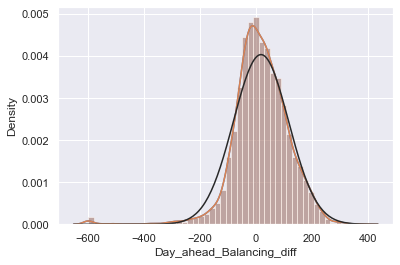

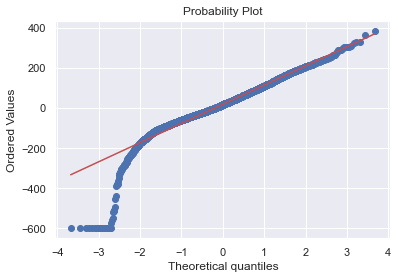

In [36]:
from scipy.stats import norm
from scipy import stats
sns.distplot(y);
sns.distplot(y, fit=norm)
fig = plt.figure()
res = stats.probplot(y, plot=plt)



In [39]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score


train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

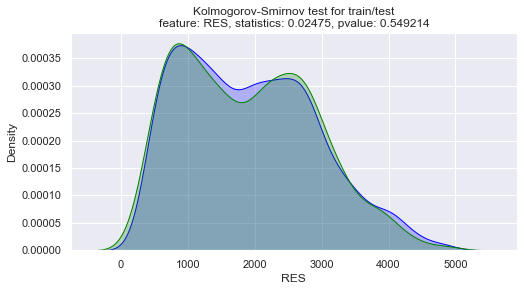

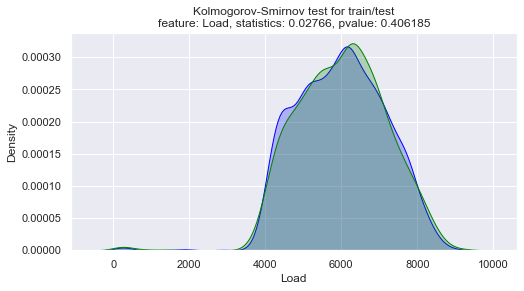

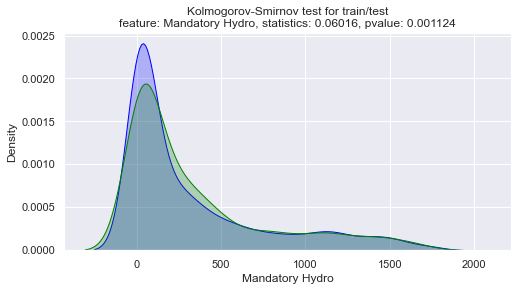

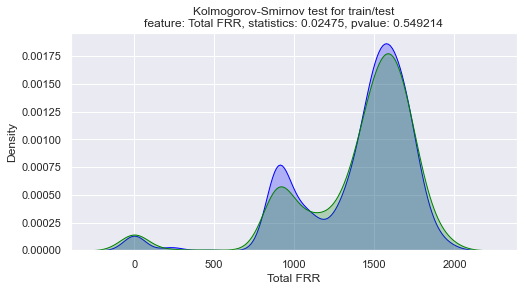

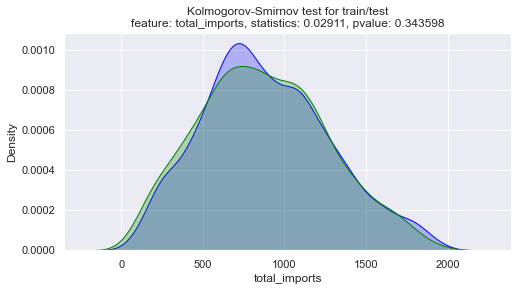

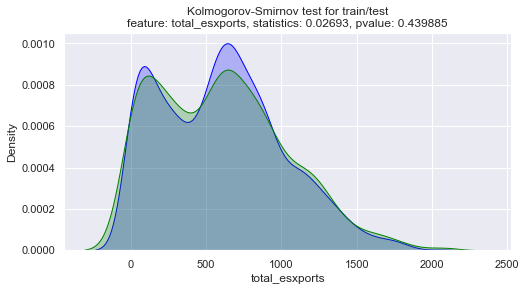

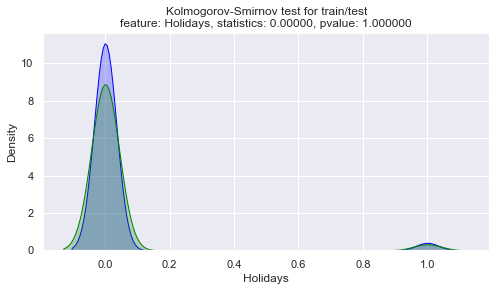

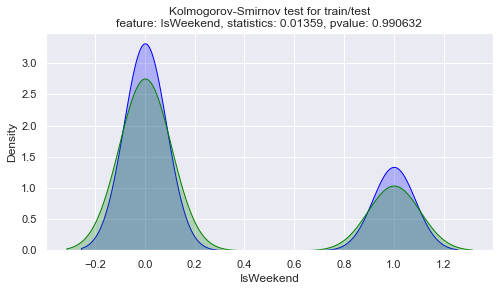

In [40]:
from scipy.stats import ks_2samp
hypothesisnotrejected = []
hypothesisrejected = []

for col in train_X.columns:
    statistic, pvalue = ks_2samp(train_X[col], test_X[col])
    if pvalue>=statistic:
        hypothesisnotrejected.append(col)
    if pvalue<statistic:
        hypothesisrejected.append(col)
        
    plt.figure(figsize=(8,4))
    plt.title("Kolmogorov-Smirnov test for train/test\n"
              "feature: {}, statistics: {:.5f}, pvalue: {:5f}".format(col, statistic, pvalue))
    sns.kdeplot(train_X[col], color='blue', shade=True, label='Train')
    sns.kdeplot(test_X[col], color='green', shade=True, label='Test')

    plt.show()

$\textbf{I want to test the distribution between Test and Train Dataset after the Split}$

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = ["RES","Load","Mandatory Hydro","Total FRR","total_imports","total_esxports"]
ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

$\textbf{CatBoost Regression}$

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMS:  84.18906216125019


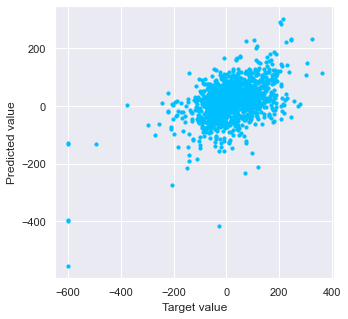

In [42]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(train_X, 
                  train_y)
test_pool = Pool(test_X) 


####{'colsample_bylevel': 4, 'learning_rate': 5, 'max_depth': 4}, 

#### Grid Search 
# {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
modelCB = CatBoostRegressor(iterations=8000,
                           depth=4,
                           learning_rate=0.08,
                           loss_function='RMSE',
                           silent=True)

modelCB.fit(train_pool,plot=True)

preds1 = modelCB.predict(test_pool)

preds_train=modelCB.predict(train_pool)
# evaluate predictions
rms1 = mean_squared_error(test_y, preds1, squared=False) #np.sqrt(np.mean((preds1 - test_y) ** 2))
print("RMS: ", rms1)
#print(preds1)



plt.figure(figsize=(5,5))
plt.scatter(test_y, preds1, s=10, color="deepskyblue")
plt.xlabel("Target value")
plt.ylabel("Predicted value")
print(train_pool)

In [44]:
val_preds = modelCB.predict(test_X)
MAPE=np.mean(np.abs((test_y - val_preds) / test_y)) * 100
# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, test_y))
print("Accuracy is : ",  100-MAPE)
MAPE

Accuracy is :  -382.89177497196204


482.89177497196204

In [45]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6)):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

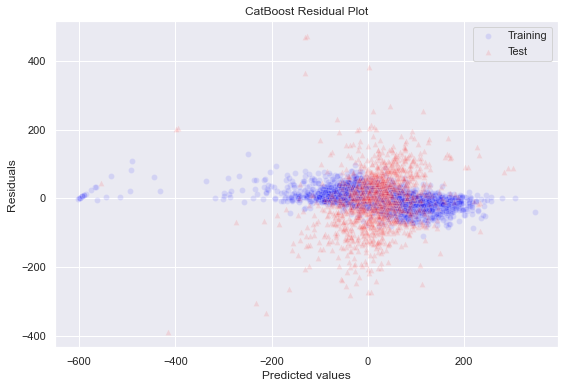

In [46]:
train_preds = modelCB.predict(train_X)

residual_plot(train_y, train_preds, 
              test_y, val_preds, 
              title="CatBoost Residual Plot")

Evaluation on test data
RMSE: 84.19
R2: 0.19
Adjusted R2: 0.19


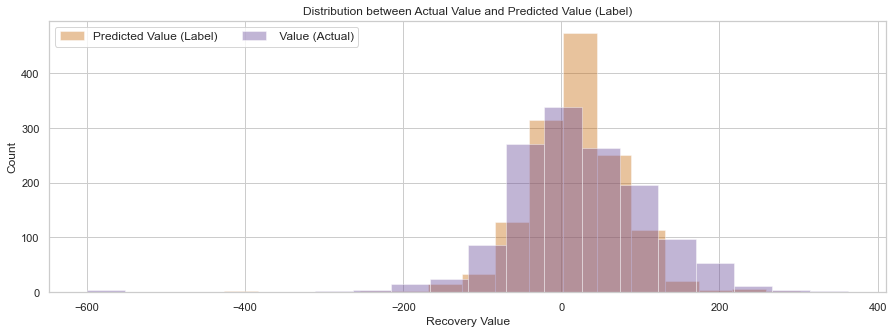

In [47]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_CATBOOST = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_CATBOOST["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_CATBOOST["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")
plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



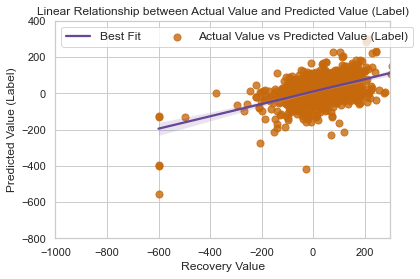

In [48]:
# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="Real", y="Prediction", data=output_data_CATBOOST, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Recovery Value")
plt.xlim([-1000, 300])
plt.ylim([-800,400])
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

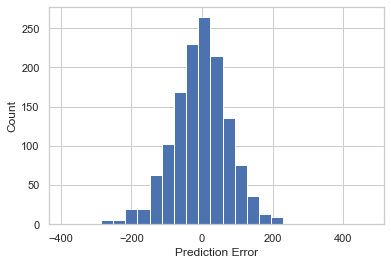

In [49]:
error = preds1 - test_y
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [50]:
output_data_CATBOOST.head(50)
output_data_CATBOOST["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Prediction"]]
output_data_CATBOOST["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Real"]]

In [51]:
output_data_CATBOOST.head(50)
comparison_column = np.where(output_data_CATBOOST["Prediction_sign"] == output_data_CATBOOST["Real_sign"], True, False)

In [52]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  890


In [53]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6477438136826783


In [54]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from catboost import cv
def cross_val(model):
    pred = cross_val_score(model, x, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square
#### Cat Boost
print('Test set evaluation:\n_____________________________________')
print_evaluate(test_y, val_preds)
print('Train set evaluation:\n_____________________________________')
print_evaluate(train_y, train_preds)


#### Light GBM 
results_bsic_Catboost = pd.DataFrame(data=[["Cat Boost", *evaluate(train_y, train_preds) ,cross_val(CatBoostRegressor())]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_bsic_Catboost




Test set evaluation:
_____________________________________
MAE: 63.20756400080058
MSE: 7087.798187590848
RMSE: 84.18906216125019
R2 Square 0.19242093252373638
__________________________________
Train set evaluation:
_____________________________________
MAE: 17.008246370303933
MSE: 532.2414416022951
RMSE: 23.07035850615016
R2 Square 0.9432015453994429
__________________________________
Learning rate set to 0.051877
0:	learn: 99.8546843	total: 4.37ms	remaining: 4.36s
1:	learn: 99.5554873	total: 8.36ms	remaining: 4.17s
2:	learn: 99.3381515	total: 12.2ms	remaining: 4.07s
3:	learn: 99.1298942	total: 16.5ms	remaining: 4.1s
4:	learn: 98.8264442	total: 20.4ms	remaining: 4.05s
5:	learn: 98.6186158	total: 24.1ms	remaining: 3.99s
6:	learn: 98.3411974	total: 28ms	remaining: 3.97s
7:	learn: 98.1839090	total: 32.7ms	remaining: 4.06s
8:	learn: 97.9337004	total: 36.5ms	remaining: 4.02s
9:	learn: 97.6375503	total: 40.4ms	remaining: 4s
10:	learn: 97.4023602	total: 44.2ms	remaining: 3.97s
11:	learn: 97.

159:	learn: 83.0635142	total: 634ms	remaining: 3.33s
160:	learn: 82.9996324	total: 640ms	remaining: 3.33s
161:	learn: 82.9278055	total: 643ms	remaining: 3.33s
162:	learn: 82.8609590	total: 647ms	remaining: 3.32s
163:	learn: 82.8327041	total: 650ms	remaining: 3.31s
164:	learn: 82.7932992	total: 655ms	remaining: 3.31s
165:	learn: 82.6936707	total: 658ms	remaining: 3.31s
166:	learn: 82.6413357	total: 662ms	remaining: 3.3s
167:	learn: 82.5800703	total: 665ms	remaining: 3.29s
168:	learn: 82.5196539	total: 669ms	remaining: 3.29s
169:	learn: 82.4637344	total: 673ms	remaining: 3.29s
170:	learn: 82.3784544	total: 676ms	remaining: 3.28s
171:	learn: 82.3204442	total: 680ms	remaining: 3.27s
172:	learn: 82.2686895	total: 684ms	remaining: 3.27s
173:	learn: 82.2369327	total: 687ms	remaining: 3.26s
174:	learn: 82.1674426	total: 691ms	remaining: 3.25s
175:	learn: 82.1255507	total: 694ms	remaining: 3.25s
176:	learn: 82.0891691	total: 698ms	remaining: 3.24s
177:	learn: 82.0076727	total: 701ms	remaining: 

325:	learn: 75.1836167	total: 1.3s	remaining: 2.69s
326:	learn: 75.1469227	total: 1.31s	remaining: 2.69s
327:	learn: 75.1210331	total: 1.31s	remaining: 2.68s
328:	learn: 75.0882923	total: 1.31s	remaining: 2.68s
329:	learn: 75.0536856	total: 1.32s	remaining: 2.67s
330:	learn: 75.0208330	total: 1.32s	remaining: 2.67s
331:	learn: 74.9762946	total: 1.32s	remaining: 2.66s
332:	learn: 74.9398536	total: 1.33s	remaining: 2.66s
333:	learn: 74.9015830	total: 1.33s	remaining: 2.65s
334:	learn: 74.8539549	total: 1.33s	remaining: 2.65s
335:	learn: 74.8161244	total: 1.34s	remaining: 2.65s
336:	learn: 74.7781989	total: 1.34s	remaining: 2.64s
337:	learn: 74.7265157	total: 1.34s	remaining: 2.63s
338:	learn: 74.6841728	total: 1.35s	remaining: 2.63s
339:	learn: 74.6463393	total: 1.35s	remaining: 2.63s
340:	learn: 74.6139930	total: 1.36s	remaining: 2.63s
341:	learn: 74.5753908	total: 1.36s	remaining: 2.62s
342:	learn: 74.5375430	total: 1.36s	remaining: 2.62s
343:	learn: 74.4881155	total: 1.37s	remaining: 

518:	learn: 68.7307539	total: 1.97s	remaining: 1.83s
519:	learn: 68.7146665	total: 1.97s	remaining: 1.82s
520:	learn: 68.6994761	total: 1.98s	remaining: 1.82s
521:	learn: 68.6673779	total: 1.98s	remaining: 1.81s
522:	learn: 68.6569402	total: 1.99s	remaining: 1.81s
523:	learn: 68.6169727	total: 1.99s	remaining: 1.81s
524:	learn: 68.5854150	total: 1.99s	remaining: 1.8s
525:	learn: 68.5519618	total: 2s	remaining: 1.8s
526:	learn: 68.5246003	total: 2s	remaining: 1.79s
527:	learn: 68.4939834	total: 2s	remaining: 1.79s
528:	learn: 68.4699326	total: 2.01s	remaining: 1.79s
529:	learn: 68.4464124	total: 2.01s	remaining: 1.78s
530:	learn: 68.4271981	total: 2.01s	remaining: 1.78s
531:	learn: 68.3913922	total: 2.02s	remaining: 1.77s
532:	learn: 68.3652548	total: 2.02s	remaining: 1.77s
533:	learn: 68.3419018	total: 2.02s	remaining: 1.77s
534:	learn: 68.3193850	total: 2.03s	remaining: 1.76s
535:	learn: 68.2820661	total: 2.03s	remaining: 1.76s
536:	learn: 68.2384495	total: 2.04s	remaining: 1.75s
537:

699:	learn: 64.1084194	total: 2.64s	remaining: 1.13s
700:	learn: 64.0960097	total: 2.65s	remaining: 1.13s
701:	learn: 64.0685288	total: 2.65s	remaining: 1.13s
702:	learn: 64.0555943	total: 2.65s	remaining: 1.12s
703:	learn: 64.0394944	total: 2.66s	remaining: 1.12s
704:	learn: 64.0096244	total: 2.66s	remaining: 1.11s
705:	learn: 63.9975916	total: 2.67s	remaining: 1.11s
706:	learn: 63.9738200	total: 2.67s	remaining: 1.11s
707:	learn: 63.9600117	total: 2.67s	remaining: 1.1s
708:	learn: 63.9293980	total: 2.68s	remaining: 1.1s
709:	learn: 63.9021591	total: 2.68s	remaining: 1.09s
710:	learn: 63.8831173	total: 2.68s	remaining: 1.09s
711:	learn: 63.8547091	total: 2.69s	remaining: 1.09s
712:	learn: 63.8392449	total: 2.69s	remaining: 1.08s
713:	learn: 63.8115440	total: 2.7s	remaining: 1.08s
714:	learn: 63.7737672	total: 2.7s	remaining: 1.08s
715:	learn: 63.7512297	total: 2.7s	remaining: 1.07s
716:	learn: 63.7375369	total: 2.71s	remaining: 1.07s
717:	learn: 63.7188695	total: 2.71s	remaining: 1.06

899:	learn: 59.7395638	total: 3.48s	remaining: 387ms
900:	learn: 59.7291827	total: 3.48s	remaining: 383ms
901:	learn: 59.7115019	total: 3.49s	remaining: 379ms
902:	learn: 59.6931725	total: 3.49s	remaining: 375ms
903:	learn: 59.6846929	total: 3.49s	remaining: 371ms
904:	learn: 59.6457578	total: 3.5s	remaining: 367ms
905:	learn: 59.6305795	total: 3.5s	remaining: 363ms
906:	learn: 59.6050210	total: 3.5s	remaining: 359ms
907:	learn: 59.5757530	total: 3.51s	remaining: 356ms
908:	learn: 59.5556203	total: 3.51s	remaining: 352ms
909:	learn: 59.5295254	total: 3.52s	remaining: 348ms
910:	learn: 59.5085492	total: 3.52s	remaining: 344ms
911:	learn: 59.4902340	total: 3.52s	remaining: 340ms
912:	learn: 59.4642813	total: 3.53s	remaining: 336ms
913:	learn: 59.4472949	total: 3.53s	remaining: 332ms
914:	learn: 59.4296099	total: 3.54s	remaining: 328ms
915:	learn: 59.4239932	total: 3.54s	remaining: 325ms
916:	learn: 59.3943669	total: 3.54s	remaining: 321ms
917:	learn: 59.3819259	total: 3.55s	remaining: 31

96:	learn: 86.3603537	total: 369ms	remaining: 3.44s
97:	learn: 86.2691425	total: 373ms	remaining: 3.43s
98:	learn: 86.2100987	total: 376ms	remaining: 3.42s
99:	learn: 86.1312417	total: 379ms	remaining: 3.41s
100:	learn: 86.0622199	total: 383ms	remaining: 3.41s
101:	learn: 86.0063847	total: 386ms	remaining: 3.4s
102:	learn: 85.9556796	total: 390ms	remaining: 3.39s
103:	learn: 85.8916395	total: 393ms	remaining: 3.39s
104:	learn: 85.7859011	total: 397ms	remaining: 3.39s
105:	learn: 85.7303049	total: 401ms	remaining: 3.38s
106:	learn: 85.6359929	total: 404ms	remaining: 3.37s
107:	learn: 85.5868149	total: 408ms	remaining: 3.37s
108:	learn: 85.4961908	total: 413ms	remaining: 3.38s
109:	learn: 85.4052574	total: 417ms	remaining: 3.37s
110:	learn: 85.3168952	total: 420ms	remaining: 3.36s
111:	learn: 85.2576395	total: 424ms	remaining: 3.36s
112:	learn: 85.2035477	total: 429ms	remaining: 3.37s
113:	learn: 85.1430953	total: 432ms	remaining: 3.36s
114:	learn: 85.0805063	total: 436ms	remaining: 3.35

273:	learn: 77.4048854	total: 1.04s	remaining: 2.75s
274:	learn: 77.3569537	total: 1.04s	remaining: 2.75s
275:	learn: 77.3010353	total: 1.05s	remaining: 2.74s
276:	learn: 77.2537717	total: 1.05s	remaining: 2.74s
277:	learn: 77.2091897	total: 1.05s	remaining: 2.73s
278:	learn: 77.1943458	total: 1.06s	remaining: 2.73s
279:	learn: 77.1472668	total: 1.06s	remaining: 2.74s
280:	learn: 77.1042330	total: 1.07s	remaining: 2.74s
281:	learn: 77.0364393	total: 1.07s	remaining: 2.73s
282:	learn: 76.9965859	total: 1.08s	remaining: 2.73s
283:	learn: 76.9643726	total: 1.08s	remaining: 2.72s
284:	learn: 76.9330667	total: 1.08s	remaining: 2.72s
285:	learn: 76.8850312	total: 1.09s	remaining: 2.71s
286:	learn: 76.8473290	total: 1.09s	remaining: 2.71s
287:	learn: 76.8099476	total: 1.1s	remaining: 2.71s
288:	learn: 76.7816858	total: 1.1s	remaining: 2.71s
289:	learn: 76.7244352	total: 1.1s	remaining: 2.7s
290:	learn: 76.6823155	total: 1.11s	remaining: 2.7s
291:	learn: 76.6423056	total: 1.11s	remaining: 2.69

450:	learn: 71.0800567	total: 1.71s	remaining: 2.08s
451:	learn: 71.0385556	total: 1.71s	remaining: 2.07s
452:	learn: 71.0062498	total: 1.71s	remaining: 2.07s
453:	learn: 70.9836666	total: 1.72s	remaining: 2.07s
454:	learn: 70.9441075	total: 1.72s	remaining: 2.06s
455:	learn: 70.9201926	total: 1.73s	remaining: 2.06s
456:	learn: 70.8775016	total: 1.73s	remaining: 2.05s
457:	learn: 70.8615697	total: 1.73s	remaining: 2.05s
458:	learn: 70.8168759	total: 1.74s	remaining: 2.05s
459:	learn: 70.7672263	total: 1.74s	remaining: 2.04s
460:	learn: 70.7410193	total: 1.74s	remaining: 2.04s
461:	learn: 70.7204726	total: 1.75s	remaining: 2.03s
462:	learn: 70.6796919	total: 1.75s	remaining: 2.03s
463:	learn: 70.6340595	total: 1.75s	remaining: 2.03s
464:	learn: 70.6014765	total: 1.76s	remaining: 2.02s
465:	learn: 70.5561802	total: 1.76s	remaining: 2.02s
466:	learn: 70.5264515	total: 1.77s	remaining: 2.02s
467:	learn: 70.5022762	total: 1.77s	remaining: 2.01s
468:	learn: 70.4702726	total: 1.77s	remaining:

641:	learn: 65.9642005	total: 2.38s	remaining: 1.33s
642:	learn: 65.9460626	total: 2.39s	remaining: 1.33s
643:	learn: 65.9275339	total: 2.4s	remaining: 1.32s
644:	learn: 65.9138393	total: 2.4s	remaining: 1.32s
645:	learn: 65.8911874	total: 2.41s	remaining: 1.32s
646:	learn: 65.8596244	total: 2.42s	remaining: 1.32s
647:	learn: 65.8359338	total: 2.42s	remaining: 1.31s
648:	learn: 65.8150584	total: 2.43s	remaining: 1.31s
649:	learn: 65.7789158	total: 2.43s	remaining: 1.31s
650:	learn: 65.7579893	total: 2.44s	remaining: 1.31s
651:	learn: 65.7386788	total: 2.45s	remaining: 1.3s
652:	learn: 65.6847579	total: 2.45s	remaining: 1.3s
653:	learn: 65.6628232	total: 2.46s	remaining: 1.3s
654:	learn: 65.6495139	total: 2.46s	remaining: 1.3s
655:	learn: 65.6355673	total: 2.47s	remaining: 1.29s
656:	learn: 65.5988117	total: 2.48s	remaining: 1.29s
657:	learn: 65.5744382	total: 2.48s	remaining: 1.29s
658:	learn: 65.5447680	total: 2.48s	remaining: 1.29s
659:	learn: 65.5203952	total: 2.49s	remaining: 1.28s

819:	learn: 61.7752705	total: 3.21s	remaining: 706ms
820:	learn: 61.7570288	total: 3.22s	remaining: 702ms
821:	learn: 61.7429799	total: 3.22s	remaining: 698ms
822:	learn: 61.7157321	total: 3.23s	remaining: 694ms
823:	learn: 61.6997677	total: 3.23s	remaining: 690ms
824:	learn: 61.6718059	total: 3.23s	remaining: 686ms
825:	learn: 61.6595633	total: 3.24s	remaining: 682ms
826:	learn: 61.6458694	total: 3.24s	remaining: 678ms
827:	learn: 61.6259025	total: 3.24s	remaining: 674ms
828:	learn: 61.6151721	total: 3.25s	remaining: 670ms
829:	learn: 61.6016249	total: 3.25s	remaining: 666ms
830:	learn: 61.5782587	total: 3.25s	remaining: 662ms
831:	learn: 61.5418410	total: 3.26s	remaining: 658ms
832:	learn: 61.5057303	total: 3.26s	remaining: 654ms
833:	learn: 61.4986638	total: 3.27s	remaining: 650ms
834:	learn: 61.4790294	total: 3.27s	remaining: 646ms
835:	learn: 61.4470181	total: 3.27s	remaining: 642ms
836:	learn: 61.4229497	total: 3.28s	remaining: 638ms
837:	learn: 61.3904376	total: 3.28s	remaining:

997:	learn: 58.1945280	total: 3.89s	remaining: 7.79ms
998:	learn: 58.1766366	total: 3.89s	remaining: 3.9ms
999:	learn: 58.1528505	total: 3.9s	remaining: 0us
Learning rate set to 0.051877
0:	learn: 95.2619703	total: 4.04ms	remaining: 4.04s
1:	learn: 94.9296520	total: 8.71ms	remaining: 4.34s
2:	learn: 94.6409319	total: 12.1ms	remaining: 4.02s
3:	learn: 94.4238625	total: 15.7ms	remaining: 3.92s
4:	learn: 94.1883938	total: 19.8ms	remaining: 3.93s
5:	learn: 93.8650694	total: 23.9ms	remaining: 3.96s
6:	learn: 93.6318480	total: 27.5ms	remaining: 3.9s
7:	learn: 93.3437643	total: 30.9ms	remaining: 3.83s
8:	learn: 93.0737111	total: 34.7ms	remaining: 3.82s
9:	learn: 92.9005375	total: 38.8ms	remaining: 3.84s
10:	learn: 92.6581727	total: 43.6ms	remaining: 3.92s
11:	learn: 92.4132637	total: 49.5ms	remaining: 4.08s
12:	learn: 92.1997165	total: 54.4ms	remaining: 4.13s
13:	learn: 92.0217455	total: 57.8ms	remaining: 4.07s
14:	learn: 91.7509208	total: 61ms	remaining: 4s
15:	learn: 91.5541514	total: 64.5m

159:	learn: 78.4176118	total: 590ms	remaining: 3.1s
160:	learn: 78.3554037	total: 593ms	remaining: 3.09s
161:	learn: 78.3046814	total: 597ms	remaining: 3.09s
162:	learn: 78.2733793	total: 604ms	remaining: 3.1s
163:	learn: 78.2229936	total: 611ms	remaining: 3.11s
164:	learn: 78.1673088	total: 616ms	remaining: 3.12s
165:	learn: 78.1256779	total: 620ms	remaining: 3.11s
166:	learn: 78.0876333	total: 624ms	remaining: 3.11s
167:	learn: 78.0231335	total: 627ms	remaining: 3.11s
168:	learn: 77.9722906	total: 631ms	remaining: 3.1s
169:	learn: 77.9295601	total: 635ms	remaining: 3.1s
170:	learn: 77.8732337	total: 639ms	remaining: 3.1s
171:	learn: 77.8217539	total: 642ms	remaining: 3.09s
172:	learn: 77.7535790	total: 646ms	remaining: 3.09s
173:	learn: 77.6830653	total: 649ms	remaining: 3.08s
174:	learn: 77.6429868	total: 653ms	remaining: 3.08s
175:	learn: 77.5605729	total: 656ms	remaining: 3.07s
176:	learn: 77.4947508	total: 660ms	remaining: 3.07s
177:	learn: 77.4465282	total: 664ms	remaining: 3.06

324:	learn: 70.5757445	total: 1.27s	remaining: 2.64s
325:	learn: 70.5296083	total: 1.27s	remaining: 2.64s
326:	learn: 70.4881752	total: 1.28s	remaining: 2.63s
327:	learn: 70.4575315	total: 1.28s	remaining: 2.63s
328:	learn: 70.4217358	total: 1.29s	remaining: 2.63s
329:	learn: 70.3915411	total: 1.29s	remaining: 2.62s
330:	learn: 70.3710761	total: 1.29s	remaining: 2.62s
331:	learn: 70.3354309	total: 1.3s	remaining: 2.61s
332:	learn: 70.2880260	total: 1.3s	remaining: 2.61s
333:	learn: 70.2483350	total: 1.3s	remaining: 2.6s
334:	learn: 70.2074245	total: 1.31s	remaining: 2.6s
335:	learn: 70.1640588	total: 1.31s	remaining: 2.6s
336:	learn: 70.1450572	total: 1.32s	remaining: 2.59s
337:	learn: 70.0840116	total: 1.32s	remaining: 2.59s
338:	learn: 70.0355002	total: 1.32s	remaining: 2.58s
339:	learn: 69.9877743	total: 1.33s	remaining: 2.58s
340:	learn: 69.9536196	total: 1.33s	remaining: 2.57s
341:	learn: 69.9301898	total: 1.33s	remaining: 2.57s
342:	learn: 69.9018139	total: 1.34s	remaining: 2.56s

496:	learn: 65.2615009	total: 1.93s	remaining: 1.95s
497:	learn: 65.2299563	total: 1.93s	remaining: 1.95s
498:	learn: 65.2073137	total: 1.94s	remaining: 1.94s
499:	learn: 65.1793712	total: 1.94s	remaining: 1.94s
500:	learn: 65.1481460	total: 1.94s	remaining: 1.93s
501:	learn: 65.1149813	total: 1.95s	remaining: 1.93s
502:	learn: 65.0675144	total: 1.95s	remaining: 1.93s
503:	learn: 65.0529015	total: 1.95s	remaining: 1.92s
504:	learn: 65.0240720	total: 1.96s	remaining: 1.92s
505:	learn: 65.0044323	total: 1.96s	remaining: 1.91s
506:	learn: 64.9739978	total: 1.96s	remaining: 1.91s
507:	learn: 64.9570677	total: 1.97s	remaining: 1.91s
508:	learn: 64.9030017	total: 1.97s	remaining: 1.9s
509:	learn: 64.8926285	total: 1.98s	remaining: 1.9s
510:	learn: 64.8730749	total: 1.98s	remaining: 1.89s
511:	learn: 64.8178008	total: 1.98s	remaining: 1.89s
512:	learn: 64.7843788	total: 1.99s	remaining: 1.89s
513:	learn: 64.7529794	total: 1.99s	remaining: 1.88s
514:	learn: 64.7247086	total: 1.99s	remaining: 1

673:	learn: 60.7861499	total: 2.6s	remaining: 1.26s
674:	learn: 60.7514032	total: 2.6s	remaining: 1.25s
675:	learn: 60.7328977	total: 2.61s	remaining: 1.25s
676:	learn: 60.7091790	total: 2.61s	remaining: 1.25s
677:	learn: 60.6887944	total: 2.61s	remaining: 1.24s
678:	learn: 60.6611977	total: 2.62s	remaining: 1.24s
679:	learn: 60.6295163	total: 2.62s	remaining: 1.23s
680:	learn: 60.6163808	total: 2.63s	remaining: 1.23s
681:	learn: 60.5934827	total: 2.63s	remaining: 1.23s
682:	learn: 60.5624141	total: 2.64s	remaining: 1.22s
683:	learn: 60.5523127	total: 2.64s	remaining: 1.22s
684:	learn: 60.5259679	total: 2.64s	remaining: 1.22s
685:	learn: 60.5093274	total: 2.65s	remaining: 1.21s
686:	learn: 60.4944972	total: 2.65s	remaining: 1.21s
687:	learn: 60.4685552	total: 2.65s	remaining: 1.2s
688:	learn: 60.4497732	total: 2.66s	remaining: 1.2s
689:	learn: 60.4114888	total: 2.66s	remaining: 1.2s
690:	learn: 60.3995292	total: 2.67s	remaining: 1.19s
691:	learn: 60.3751196	total: 2.67s	remaining: 1.19

835:	learn: 57.1758673	total: 3.27s	remaining: 641ms
836:	learn: 57.1617802	total: 3.27s	remaining: 637ms
837:	learn: 57.1542179	total: 3.28s	remaining: 633ms
838:	learn: 57.1294375	total: 3.28s	remaining: 629ms
839:	learn: 57.1150909	total: 3.28s	remaining: 625ms
840:	learn: 57.0924506	total: 3.29s	remaining: 621ms
841:	learn: 57.0668543	total: 3.29s	remaining: 618ms
842:	learn: 57.0379759	total: 3.29s	remaining: 614ms
843:	learn: 57.0177712	total: 3.3s	remaining: 610ms
844:	learn: 57.0024149	total: 3.31s	remaining: 607ms
845:	learn: 56.9729058	total: 3.31s	remaining: 603ms
846:	learn: 56.9636023	total: 3.31s	remaining: 599ms
847:	learn: 56.9359744	total: 3.32s	remaining: 595ms
848:	learn: 56.9191275	total: 3.32s	remaining: 591ms
849:	learn: 56.8974933	total: 3.33s	remaining: 587ms
850:	learn: 56.8834680	total: 3.33s	remaining: 583ms
851:	learn: 56.8604433	total: 3.33s	remaining: 579ms
852:	learn: 56.8449574	total: 3.34s	remaining: 575ms
853:	learn: 56.8312276	total: 3.34s	remaining: 

1:	learn: 96.8338184	total: 12.8ms	remaining: 6.38s
2:	learn: 96.5757485	total: 16.6ms	remaining: 5.53s
3:	learn: 96.3972784	total: 20.7ms	remaining: 5.16s
4:	learn: 96.1506513	total: 24.7ms	remaining: 4.91s
5:	learn: 95.9221004	total: 27.8ms	remaining: 4.61s
6:	learn: 95.5966382	total: 30.8ms	remaining: 4.37s
7:	learn: 95.4040399	total: 34.4ms	remaining: 4.26s
8:	learn: 95.1310031	total: 38.7ms	remaining: 4.26s
9:	learn: 94.9210064	total: 42ms	remaining: 4.16s
10:	learn: 94.7236137	total: 45.5ms	remaining: 4.09s
11:	learn: 94.4978226	total: 49.6ms	remaining: 4.09s
12:	learn: 94.2832271	total: 53.9ms	remaining: 4.09s
13:	learn: 94.0739762	total: 57.5ms	remaining: 4.05s
14:	learn: 93.8722547	total: 60.9ms	remaining: 4s
15:	learn: 93.6538020	total: 64.5ms	remaining: 3.97s
16:	learn: 93.4694690	total: 69ms	remaining: 3.99s
17:	learn: 93.2121702	total: 73ms	remaining: 3.98s
18:	learn: 93.0549721	total: 76.6ms	remaining: 3.95s
19:	learn: 92.8854785	total: 80ms	remaining: 3.92s
20:	learn: 92

173:	learn: 79.9197286	total: 670ms	remaining: 3.18s
174:	learn: 79.8617703	total: 673ms	remaining: 3.17s
175:	learn: 79.8237383	total: 677ms	remaining: 3.17s
176:	learn: 79.7494688	total: 680ms	remaining: 3.16s
177:	learn: 79.6986233	total: 684ms	remaining: 3.16s
178:	learn: 79.6443802	total: 687ms	remaining: 3.15s
179:	learn: 79.6075095	total: 691ms	remaining: 3.15s
180:	learn: 79.5501019	total: 694ms	remaining: 3.14s
181:	learn: 79.4884509	total: 698ms	remaining: 3.14s
182:	learn: 79.4581925	total: 702ms	remaining: 3.13s
183:	learn: 79.3530771	total: 707ms	remaining: 3.13s
184:	learn: 79.2999406	total: 712ms	remaining: 3.13s
185:	learn: 79.2182591	total: 717ms	remaining: 3.14s
186:	learn: 79.1592087	total: 722ms	remaining: 3.14s
187:	learn: 79.1065802	total: 725ms	remaining: 3.13s
188:	learn: 79.0453420	total: 729ms	remaining: 3.13s
189:	learn: 78.9711332	total: 733ms	remaining: 3.12s
190:	learn: 78.9043858	total: 737ms	remaining: 3.12s
191:	learn: 78.8712860	total: 740ms	remaining:

343:	learn: 72.2270423	total: 1.35s	remaining: 2.57s
344:	learn: 72.1965107	total: 1.35s	remaining: 2.57s
345:	learn: 72.1618185	total: 1.36s	remaining: 2.57s
346:	learn: 72.1222428	total: 1.36s	remaining: 2.56s
347:	learn: 72.0759620	total: 1.37s	remaining: 2.56s
348:	learn: 72.0323842	total: 1.37s	remaining: 2.55s
349:	learn: 72.0022702	total: 1.37s	remaining: 2.55s
350:	learn: 71.9741845	total: 1.38s	remaining: 2.55s
351:	learn: 71.9350863	total: 1.38s	remaining: 2.54s
352:	learn: 71.8941177	total: 1.38s	remaining: 2.54s
353:	learn: 71.8709139	total: 1.39s	remaining: 2.53s
354:	learn: 71.8364081	total: 1.39s	remaining: 2.53s
355:	learn: 71.8009737	total: 1.4s	remaining: 2.52s
356:	learn: 71.7780702	total: 1.4s	remaining: 2.52s
357:	learn: 71.7162359	total: 1.4s	remaining: 2.51s
358:	learn: 71.6853888	total: 1.41s	remaining: 2.51s
359:	learn: 71.6562691	total: 1.41s	remaining: 2.5s
360:	learn: 71.6140117	total: 1.41s	remaining: 2.5s
361:	learn: 71.5731549	total: 1.42s	remaining: 2.5s

528:	learn: 66.2032858	total: 2.01s	remaining: 1.79s
529:	learn: 66.1660480	total: 2.01s	remaining: 1.78s
530:	learn: 66.1382127	total: 2.01s	remaining: 1.78s
531:	learn: 66.1157979	total: 2.02s	remaining: 1.77s
532:	learn: 66.0915080	total: 2.02s	remaining: 1.77s
533:	learn: 66.0528332	total: 2.02s	remaining: 1.77s
534:	learn: 66.0271545	total: 2.03s	remaining: 1.76s
535:	learn: 65.9991020	total: 2.03s	remaining: 1.76s
536:	learn: 65.9615294	total: 2.04s	remaining: 1.75s
537:	learn: 65.9308693	total: 2.04s	remaining: 1.75s
538:	learn: 65.9104242	total: 2.04s	remaining: 1.75s
539:	learn: 65.8766474	total: 2.05s	remaining: 1.74s
540:	learn: 65.8373155	total: 2.05s	remaining: 1.74s
541:	learn: 65.8097539	total: 2.05s	remaining: 1.74s
542:	learn: 65.7777939	total: 2.06s	remaining: 1.73s
543:	learn: 65.7414071	total: 2.06s	remaining: 1.73s
544:	learn: 65.7086734	total: 2.06s	remaining: 1.72s
545:	learn: 65.6915109	total: 2.07s	remaining: 1.72s
546:	learn: 65.6734975	total: 2.07s	remaining:

723:	learn: 61.2978204	total: 2.68s	remaining: 1.02s
724:	learn: 61.2763224	total: 2.68s	remaining: 1.02s
725:	learn: 61.2443295	total: 2.68s	remaining: 1.01s
726:	learn: 61.2097173	total: 2.69s	remaining: 1.01s
727:	learn: 61.1770412	total: 2.69s	remaining: 1s
728:	learn: 61.1526797	total: 2.69s	remaining: 1s
729:	learn: 61.1307674	total: 2.7s	remaining: 998ms
730:	learn: 61.1030555	total: 2.7s	remaining: 994ms
731:	learn: 61.0877290	total: 2.7s	remaining: 990ms
732:	learn: 61.0781894	total: 2.71s	remaining: 987ms
733:	learn: 61.0434537	total: 2.71s	remaining: 983ms
734:	learn: 61.0218664	total: 2.71s	remaining: 979ms
735:	learn: 61.0008805	total: 2.72s	remaining: 975ms
736:	learn: 60.9742303	total: 2.72s	remaining: 972ms
737:	learn: 60.9547753	total: 2.73s	remaining: 968ms
738:	learn: 60.9428301	total: 2.73s	remaining: 964ms
739:	learn: 60.9199324	total: 2.73s	remaining: 960ms
740:	learn: 60.8971974	total: 2.74s	remaining: 957ms
741:	learn: 60.8824824	total: 2.74s	remaining: 953ms
74

909:	learn: 57.4709025	total: 3.35s	remaining: 331ms
910:	learn: 57.4611718	total: 3.35s	remaining: 328ms
911:	learn: 57.4413344	total: 3.36s	remaining: 324ms
912:	learn: 57.4251038	total: 3.36s	remaining: 320ms
913:	learn: 57.4052408	total: 3.36s	remaining: 317ms
914:	learn: 57.3844507	total: 3.37s	remaining: 313ms
915:	learn: 57.3694313	total: 3.37s	remaining: 309ms
916:	learn: 57.3453032	total: 3.37s	remaining: 305ms
917:	learn: 57.3315730	total: 3.38s	remaining: 302ms
918:	learn: 57.3136147	total: 3.38s	remaining: 298ms
919:	learn: 57.2916707	total: 3.39s	remaining: 294ms
920:	learn: 57.2707749	total: 3.39s	remaining: 291ms
921:	learn: 57.2540010	total: 3.39s	remaining: 287ms
922:	learn: 57.2392626	total: 3.4s	remaining: 283ms
923:	learn: 57.2157286	total: 3.4s	remaining: 280ms
924:	learn: 57.2038778	total: 3.4s	remaining: 276ms
925:	learn: 57.1773164	total: 3.41s	remaining: 272ms
926:	learn: 57.1598982	total: 3.41s	remaining: 269ms
927:	learn: 57.1237332	total: 3.42s	remaining: 26

69:	learn: 85.9898304	total: 272ms	remaining: 3.62s
70:	learn: 85.8640472	total: 276ms	remaining: 3.61s
71:	learn: 85.7934542	total: 280ms	remaining: 3.61s
72:	learn: 85.7178065	total: 284ms	remaining: 3.61s
73:	learn: 85.6201562	total: 288ms	remaining: 3.61s
74:	learn: 85.5678064	total: 292ms	remaining: 3.6s
75:	learn: 85.4808934	total: 296ms	remaining: 3.6s
76:	learn: 85.4026654	total: 300ms	remaining: 3.59s
77:	learn: 85.3543496	total: 303ms	remaining: 3.58s
78:	learn: 85.2888979	total: 307ms	remaining: 3.57s
79:	learn: 85.1979448	total: 311ms	remaining: 3.57s
80:	learn: 85.1061881	total: 314ms	remaining: 3.57s
81:	learn: 84.9706523	total: 318ms	remaining: 3.56s
82:	learn: 84.9076489	total: 322ms	remaining: 3.56s
83:	learn: 84.8144504	total: 326ms	remaining: 3.56s
84:	learn: 84.6740915	total: 330ms	remaining: 3.55s
85:	learn: 84.6253046	total: 333ms	remaining: 3.54s
86:	learn: 84.5516440	total: 337ms	remaining: 3.54s
87:	learn: 84.4888314	total: 341ms	remaining: 3.54s
88:	learn: 84.

236:	learn: 75.7979137	total: 942ms	remaining: 3.03s
237:	learn: 75.7759811	total: 946ms	remaining: 3.03s
238:	learn: 75.7376635	total: 951ms	remaining: 3.03s
239:	learn: 75.7099542	total: 954ms	remaining: 3.02s
240:	learn: 75.6809839	total: 958ms	remaining: 3.02s
241:	learn: 75.6452017	total: 961ms	remaining: 3.01s
242:	learn: 75.6171945	total: 965ms	remaining: 3s
243:	learn: 75.5793505	total: 969ms	remaining: 3s
244:	learn: 75.5257548	total: 972ms	remaining: 3s
245:	learn: 75.4795805	total: 976ms	remaining: 2.99s
246:	learn: 75.4404377	total: 979ms	remaining: 2.98s
247:	learn: 75.3999365	total: 983ms	remaining: 2.98s
248:	learn: 75.3763434	total: 986ms	remaining: 2.97s
249:	learn: 75.3454599	total: 990ms	remaining: 2.97s
250:	learn: 75.2928756	total: 996ms	remaining: 2.97s
251:	learn: 75.2463452	total: 1s	remaining: 2.97s
252:	learn: 75.1916897	total: 1s	remaining: 2.96s
253:	learn: 75.1312969	total: 1.01s	remaining: 2.96s
254:	learn: 75.0844387	total: 1.01s	remaining: 2.96s
255:	lea

413:	learn: 69.0607113	total: 1.61s	remaining: 2.28s
414:	learn: 69.0316508	total: 1.61s	remaining: 2.27s
415:	learn: 68.9923337	total: 1.62s	remaining: 2.27s
416:	learn: 68.9533294	total: 1.62s	remaining: 2.26s
417:	learn: 68.8829887	total: 1.62s	remaining: 2.26s
418:	learn: 68.8271132	total: 1.63s	remaining: 2.26s
419:	learn: 68.8116632	total: 1.63s	remaining: 2.25s
420:	learn: 68.7793090	total: 1.63s	remaining: 2.25s
421:	learn: 68.7605068	total: 1.64s	remaining: 2.24s
422:	learn: 68.7385115	total: 1.64s	remaining: 2.24s
423:	learn: 68.7078356	total: 1.65s	remaining: 2.23s
424:	learn: 68.6819882	total: 1.65s	remaining: 2.23s
425:	learn: 68.6510786	total: 1.65s	remaining: 2.23s
426:	learn: 68.6366546	total: 1.66s	remaining: 2.22s
427:	learn: 68.6147705	total: 1.66s	remaining: 2.22s
428:	learn: 68.5729058	total: 1.66s	remaining: 2.21s
429:	learn: 68.5445516	total: 1.67s	remaining: 2.21s
430:	learn: 68.5164310	total: 1.67s	remaining: 2.21s
431:	learn: 68.4842879	total: 1.68s	remaining:

588:	learn: 63.9508604	total: 2.28s	remaining: 1.59s
589:	learn: 63.9247467	total: 2.28s	remaining: 1.59s
590:	learn: 63.9001628	total: 2.29s	remaining: 1.58s
591:	learn: 63.8838968	total: 2.29s	remaining: 1.58s
592:	learn: 63.8500075	total: 2.29s	remaining: 1.57s
593:	learn: 63.8318734	total: 2.3s	remaining: 1.57s
594:	learn: 63.8208386	total: 2.3s	remaining: 1.57s
595:	learn: 63.7967472	total: 2.31s	remaining: 1.56s
596:	learn: 63.7690700	total: 2.31s	remaining: 1.56s
597:	learn: 63.7372973	total: 2.31s	remaining: 1.55s
598:	learn: 63.7077415	total: 2.32s	remaining: 1.55s
599:	learn: 63.6805739	total: 2.32s	remaining: 1.55s
600:	learn: 63.6486307	total: 2.32s	remaining: 1.54s
601:	learn: 63.6222148	total: 2.33s	remaining: 1.54s
602:	learn: 63.6051908	total: 2.33s	remaining: 1.53s
603:	learn: 63.5720104	total: 2.33s	remaining: 1.53s
604:	learn: 63.5348516	total: 2.34s	remaining: 1.53s
605:	learn: 63.5124037	total: 2.34s	remaining: 1.52s
606:	learn: 63.4814334	total: 2.35s	remaining: 1

767:	learn: 60.0636103	total: 2.95s	remaining: 890ms
768:	learn: 60.0450239	total: 2.95s	remaining: 886ms
769:	learn: 60.0214210	total: 2.95s	remaining: 883ms
770:	learn: 60.0009579	total: 2.96s	remaining: 879ms
771:	learn: 59.9783800	total: 2.96s	remaining: 875ms
772:	learn: 59.9603480	total: 2.96s	remaining: 871ms
773:	learn: 59.9383240	total: 2.97s	remaining: 867ms
774:	learn: 59.9137960	total: 2.97s	remaining: 863ms
775:	learn: 59.8985316	total: 2.98s	remaining: 859ms
776:	learn: 59.8796886	total: 2.98s	remaining: 855ms
777:	learn: 59.8621886	total: 2.98s	remaining: 852ms
778:	learn: 59.8478442	total: 2.99s	remaining: 848ms
779:	learn: 59.8265958	total: 2.99s	remaining: 844ms
780:	learn: 59.7954750	total: 3s	remaining: 840ms
781:	learn: 59.7740258	total: 3s	remaining: 836ms
782:	learn: 59.7563931	total: 3s	remaining: 832ms
783:	learn: 59.7264012	total: 3.01s	remaining: 828ms
784:	learn: 59.7159266	total: 3.01s	remaining: 824ms
785:	learn: 59.6964325	total: 3.01s	remaining: 821ms
78

949:	learn: 56.5617931	total: 3.62s	remaining: 190ms
950:	learn: 56.5343723	total: 3.62s	remaining: 187ms
951:	learn: 56.5176001	total: 3.62s	remaining: 183ms
952:	learn: 56.4989522	total: 3.63s	remaining: 179ms
953:	learn: 56.4823435	total: 3.63s	remaining: 175ms
954:	learn: 56.4559382	total: 3.63s	remaining: 171ms
955:	learn: 56.4348244	total: 3.64s	remaining: 167ms
956:	learn: 56.4152768	total: 3.64s	remaining: 164ms
957:	learn: 56.3971340	total: 3.64s	remaining: 160ms
958:	learn: 56.3841130	total: 3.65s	remaining: 156ms
959:	learn: 56.3673373	total: 3.65s	remaining: 152ms
960:	learn: 56.3460956	total: 3.65s	remaining: 148ms
961:	learn: 56.3278944	total: 3.66s	remaining: 145ms
962:	learn: 56.3186967	total: 3.66s	remaining: 141ms
963:	learn: 56.2924422	total: 3.67s	remaining: 137ms
964:	learn: 56.2677772	total: 3.67s	remaining: 133ms
965:	learn: 56.2524389	total: 3.68s	remaining: 129ms
966:	learn: 56.2386264	total: 3.68s	remaining: 126ms
967:	learn: 56.2182600	total: 3.69s	remaining:

112:	learn: 78.4277616	total: 432ms	remaining: 3.39s
113:	learn: 78.3706907	total: 436ms	remaining: 3.39s
114:	learn: 78.3249035	total: 439ms	remaining: 3.38s
115:	learn: 78.2714346	total: 443ms	remaining: 3.37s
116:	learn: 78.2158078	total: 446ms	remaining: 3.37s
117:	learn: 78.1353539	total: 450ms	remaining: 3.36s
118:	learn: 78.0709853	total: 453ms	remaining: 3.36s
119:	learn: 78.0191062	total: 457ms	remaining: 3.35s
120:	learn: 77.9754134	total: 460ms	remaining: 3.34s
121:	learn: 77.9102114	total: 465ms	remaining: 3.35s
122:	learn: 77.8595256	total: 470ms	remaining: 3.35s
123:	learn: 77.7988779	total: 474ms	remaining: 3.35s
124:	learn: 77.7542533	total: 480ms	remaining: 3.36s
125:	learn: 77.6988269	total: 483ms	remaining: 3.35s
126:	learn: 77.6531226	total: 487ms	remaining: 3.35s
127:	learn: 77.6043722	total: 490ms	remaining: 3.34s
128:	learn: 77.5496674	total: 494ms	remaining: 3.33s
129:	learn: 77.5035862	total: 497ms	remaining: 3.33s
130:	learn: 77.4832017	total: 501ms	remaining:

283:	learn: 70.9227966	total: 1.09s	remaining: 2.76s
284:	learn: 70.8807395	total: 1.1s	remaining: 2.76s
285:	learn: 70.8316906	total: 1.1s	remaining: 2.75s
286:	learn: 70.7970136	total: 1.1s	remaining: 2.75s
287:	learn: 70.7708791	total: 1.11s	remaining: 2.74s
288:	learn: 70.7310283	total: 1.11s	remaining: 2.74s
289:	learn: 70.6787554	total: 1.12s	remaining: 2.73s
290:	learn: 70.6533346	total: 1.12s	remaining: 2.73s
291:	learn: 70.6296785	total: 1.12s	remaining: 2.72s
292:	learn: 70.5921812	total: 1.13s	remaining: 2.72s
293:	learn: 70.5608465	total: 1.13s	remaining: 2.71s
294:	learn: 70.5249088	total: 1.13s	remaining: 2.71s
295:	learn: 70.4975147	total: 1.14s	remaining: 2.7s
296:	learn: 70.4698442	total: 1.14s	remaining: 2.7s
297:	learn: 70.4421796	total: 1.14s	remaining: 2.7s
298:	learn: 70.4172257	total: 1.15s	remaining: 2.69s
299:	learn: 70.3594656	total: 1.15s	remaining: 2.69s
300:	learn: 70.3165171	total: 1.16s	remaining: 2.68s
301:	learn: 70.2778532	total: 1.16s	remaining: 2.68s

477:	learn: 64.6457478	total: 1.76s	remaining: 1.93s
478:	learn: 64.6306364	total: 1.77s	remaining: 1.92s
479:	learn: 64.6033476	total: 1.77s	remaining: 1.92s
480:	learn: 64.5851981	total: 1.77s	remaining: 1.92s
481:	learn: 64.5362325	total: 1.78s	remaining: 1.91s
482:	learn: 64.5152123	total: 1.78s	remaining: 1.91s
483:	learn: 64.4853958	total: 1.78s	remaining: 1.9s
484:	learn: 64.4684385	total: 1.79s	remaining: 1.9s
485:	learn: 64.4546729	total: 1.79s	remaining: 1.9s
486:	learn: 64.4196910	total: 1.79s	remaining: 1.89s
487:	learn: 64.3943098	total: 1.8s	remaining: 1.89s
488:	learn: 64.3580581	total: 1.8s	remaining: 1.88s
489:	learn: 64.3373244	total: 1.81s	remaining: 1.88s
490:	learn: 64.3106501	total: 1.81s	remaining: 1.88s
491:	learn: 64.2923689	total: 1.81s	remaining: 1.87s
492:	learn: 64.2631028	total: 1.82s	remaining: 1.87s
493:	learn: 64.2365742	total: 1.82s	remaining: 1.86s
494:	learn: 64.2232374	total: 1.82s	remaining: 1.86s
495:	learn: 64.2092708	total: 1.83s	remaining: 1.86

660:	learn: 60.5078896	total: 2.44s	remaining: 1.25s
661:	learn: 60.4836810	total: 2.44s	remaining: 1.25s
662:	learn: 60.4723536	total: 2.44s	remaining: 1.24s
663:	learn: 60.4361158	total: 2.44s	remaining: 1.24s
664:	learn: 60.4056853	total: 2.45s	remaining: 1.23s
665:	learn: 60.3887577	total: 2.45s	remaining: 1.23s
666:	learn: 60.3733290	total: 2.46s	remaining: 1.23s
667:	learn: 60.3249139	total: 2.46s	remaining: 1.22s
668:	learn: 60.3056170	total: 2.46s	remaining: 1.22s
669:	learn: 60.2890405	total: 2.47s	remaining: 1.22s
670:	learn: 60.2737096	total: 2.47s	remaining: 1.21s
671:	learn: 60.2574009	total: 2.48s	remaining: 1.21s
672:	learn: 60.2361262	total: 2.48s	remaining: 1.2s
673:	learn: 60.2098805	total: 2.48s	remaining: 1.2s
674:	learn: 60.1848177	total: 2.49s	remaining: 1.2s
675:	learn: 60.1597888	total: 2.49s	remaining: 1.19s
676:	learn: 60.1254979	total: 2.49s	remaining: 1.19s
677:	learn: 60.1087715	total: 2.5s	remaining: 1.19s
678:	learn: 60.0909929	total: 2.5s	remaining: 1.18

817:	learn: 57.2497220	total: 3.11s	remaining: 691ms
818:	learn: 57.2315789	total: 3.11s	remaining: 687ms
819:	learn: 57.2233915	total: 3.11s	remaining: 684ms
820:	learn: 57.2156026	total: 3.12s	remaining: 680ms
821:	learn: 57.2017895	total: 3.12s	remaining: 676ms
822:	learn: 57.1824875	total: 3.13s	remaining: 672ms
823:	learn: 57.1700263	total: 3.13s	remaining: 668ms
824:	learn: 57.1488656	total: 3.13s	remaining: 665ms
825:	learn: 57.1361685	total: 3.14s	remaining: 661ms
826:	learn: 57.1278136	total: 3.14s	remaining: 657ms
827:	learn: 57.1111157	total: 3.14s	remaining: 653ms
828:	learn: 57.1015005	total: 3.15s	remaining: 649ms
829:	learn: 57.0784119	total: 3.15s	remaining: 645ms
830:	learn: 57.0587584	total: 3.15s	remaining: 642ms
831:	learn: 57.0550027	total: 3.16s	remaining: 638ms
832:	learn: 57.0231025	total: 3.16s	remaining: 634ms
833:	learn: 57.0060178	total: 3.17s	remaining: 630ms
834:	learn: 56.9893671	total: 3.17s	remaining: 627ms
835:	learn: 56.9755665	total: 3.17s	remaining:

0:	learn: 94.6275764	total: 4.07ms	remaining: 4.07s
1:	learn: 94.2935634	total: 7.79ms	remaining: 3.89s
2:	learn: 94.0613426	total: 11.3ms	remaining: 3.75s
3:	learn: 93.7145879	total: 15.7ms	remaining: 3.9s
4:	learn: 93.4352767	total: 20ms	remaining: 3.97s
5:	learn: 93.1825295	total: 23.4ms	remaining: 3.88s
6:	learn: 92.9078466	total: 26.8ms	remaining: 3.8s
7:	learn: 92.6960196	total: 30.9ms	remaining: 3.83s
8:	learn: 92.4976042	total: 34.7ms	remaining: 3.82s
9:	learn: 92.2714434	total: 38.3ms	remaining: 3.79s
10:	learn: 92.0462181	total: 41.9ms	remaining: 3.77s
11:	learn: 91.8439729	total: 46.2ms	remaining: 3.81s
12:	learn: 91.6922125	total: 49.9ms	remaining: 3.79s
13:	learn: 91.4553343	total: 53.5ms	remaining: 3.77s
14:	learn: 91.2211772	total: 56.9ms	remaining: 3.74s
15:	learn: 90.9815765	total: 61.8ms	remaining: 3.8s
16:	learn: 90.7351008	total: 65ms	remaining: 3.76s
17:	learn: 90.5267841	total: 68.2ms	remaining: 3.72s
18:	learn: 90.3552009	total: 71.4ms	remaining: 3.69s
19:	learn:

191:	learn: 77.1655170	total: 665ms	remaining: 2.8s
192:	learn: 77.1033478	total: 668ms	remaining: 2.79s
193:	learn: 77.0527882	total: 673ms	remaining: 2.79s
194:	learn: 77.0007085	total: 676ms	remaining: 2.79s
195:	learn: 76.9436708	total: 680ms	remaining: 2.79s
196:	learn: 76.8983121	total: 683ms	remaining: 2.79s
197:	learn: 76.8419221	total: 687ms	remaining: 2.78s
198:	learn: 76.7978579	total: 691ms	remaining: 2.78s
199:	learn: 76.7309507	total: 694ms	remaining: 2.78s
200:	learn: 76.6774628	total: 698ms	remaining: 2.77s
201:	learn: 76.6225765	total: 702ms	remaining: 2.77s
202:	learn: 76.5799567	total: 705ms	remaining: 2.77s
203:	learn: 76.5254113	total: 709ms	remaining: 2.77s
204:	learn: 76.4873984	total: 712ms	remaining: 2.76s
205:	learn: 76.4381926	total: 715ms	remaining: 2.76s
206:	learn: 76.4085811	total: 719ms	remaining: 2.75s
207:	learn: 76.3533094	total: 722ms	remaining: 2.75s
208:	learn: 76.3041715	total: 726ms	remaining: 2.75s
209:	learn: 76.2356487	total: 729ms	remaining: 

381:	learn: 69.4454791	total: 1.34s	remaining: 2.16s
382:	learn: 69.4138335	total: 1.34s	remaining: 2.16s
383:	learn: 69.3640203	total: 1.34s	remaining: 2.16s
384:	learn: 69.3223475	total: 1.35s	remaining: 2.15s
385:	learn: 69.2747765	total: 1.35s	remaining: 2.15s
386:	learn: 69.2582231	total: 1.35s	remaining: 2.15s
387:	learn: 69.2059007	total: 1.36s	remaining: 2.14s
388:	learn: 69.1732370	total: 1.36s	remaining: 2.14s
389:	learn: 69.1405896	total: 1.36s	remaining: 2.14s
390:	learn: 69.1194919	total: 1.37s	remaining: 2.13s
391:	learn: 69.0937005	total: 1.37s	remaining: 2.13s
392:	learn: 69.0417882	total: 1.38s	remaining: 2.13s
393:	learn: 69.0134440	total: 1.38s	remaining: 2.12s
394:	learn: 68.9880796	total: 1.38s	remaining: 2.12s
395:	learn: 68.9561671	total: 1.39s	remaining: 2.12s
396:	learn: 68.9432791	total: 1.39s	remaining: 2.11s
397:	learn: 68.9151140	total: 1.4s	remaining: 2.11s
398:	learn: 68.8907173	total: 1.4s	remaining: 2.11s
399:	learn: 68.8790961	total: 1.4s	remaining: 2.

573:	learn: 64.1216739	total: 2s	remaining: 1.49s
574:	learn: 64.0792403	total: 2.01s	remaining: 1.48s
575:	learn: 64.0638192	total: 2.01s	remaining: 1.48s
576:	learn: 64.0522895	total: 2.02s	remaining: 1.48s
577:	learn: 64.0235701	total: 2.02s	remaining: 1.47s
578:	learn: 63.9943024	total: 2.02s	remaining: 1.47s
579:	learn: 63.9583044	total: 2.03s	remaining: 1.47s
580:	learn: 63.9359891	total: 2.03s	remaining: 1.46s
581:	learn: 63.9205521	total: 2.03s	remaining: 1.46s
582:	learn: 63.8759585	total: 2.04s	remaining: 1.46s
583:	learn: 63.8495628	total: 2.04s	remaining: 1.45s
584:	learn: 63.8248895	total: 2.04s	remaining: 1.45s
585:	learn: 63.7965734	total: 2.05s	remaining: 1.45s
586:	learn: 63.7665402	total: 2.05s	remaining: 1.44s
587:	learn: 63.7479620	total: 2.06s	remaining: 1.44s
588:	learn: 63.7180918	total: 2.06s	remaining: 1.44s
589:	learn: 63.6924076	total: 2.06s	remaining: 1.44s
590:	learn: 63.6740430	total: 2.07s	remaining: 1.43s
591:	learn: 63.6434001	total: 2.07s	remaining: 1.

755:	learn: 60.0927969	total: 2.68s	remaining: 864ms
756:	learn: 60.0725172	total: 2.68s	remaining: 861ms
757:	learn: 60.0630281	total: 2.69s	remaining: 857ms
758:	learn: 60.0402568	total: 2.69s	remaining: 854ms
759:	learn: 60.0237407	total: 2.69s	remaining: 850ms
760:	learn: 59.9986700	total: 2.7s	remaining: 847ms
761:	learn: 59.9834205	total: 2.7s	remaining: 843ms
762:	learn: 59.9598401	total: 2.7s	remaining: 840ms
763:	learn: 59.9414788	total: 2.71s	remaining: 836ms
764:	learn: 59.9123891	total: 2.71s	remaining: 833ms
765:	learn: 59.8825205	total: 2.71s	remaining: 829ms
766:	learn: 59.8674195	total: 2.72s	remaining: 826ms
767:	learn: 59.8501323	total: 2.72s	remaining: 822ms
768:	learn: 59.8280751	total: 2.72s	remaining: 818ms
769:	learn: 59.8022164	total: 2.73s	remaining: 815ms
770:	learn: 59.7718418	total: 2.73s	remaining: 811ms
771:	learn: 59.7489913	total: 2.74s	remaining: 808ms
772:	learn: 59.7443454	total: 2.74s	remaining: 804ms
773:	learn: 59.7226100	total: 2.74s	remaining: 80

949:	learn: 56.4774663	total: 3.35s	remaining: 176ms
950:	learn: 56.4726716	total: 3.35s	remaining: 173ms
951:	learn: 56.4604449	total: 3.35s	remaining: 169ms
952:	learn: 56.4469362	total: 3.36s	remaining: 166ms
953:	learn: 56.4258165	total: 3.36s	remaining: 162ms
954:	learn: 56.4178775	total: 3.37s	remaining: 159ms
955:	learn: 56.3988793	total: 3.37s	remaining: 155ms
956:	learn: 56.3892047	total: 3.37s	remaining: 152ms
957:	learn: 56.3748067	total: 3.38s	remaining: 148ms
958:	learn: 56.3574581	total: 3.38s	remaining: 144ms
959:	learn: 56.3492868	total: 3.38s	remaining: 141ms
960:	learn: 56.3343132	total: 3.39s	remaining: 137ms
961:	learn: 56.3198949	total: 3.39s	remaining: 134ms
962:	learn: 56.2933463	total: 3.39s	remaining: 130ms
963:	learn: 56.2731657	total: 3.4s	remaining: 127ms
964:	learn: 56.2618844	total: 3.4s	remaining: 123ms
965:	learn: 56.2476093	total: 3.4s	remaining: 120ms
966:	learn: 56.2374905	total: 3.41s	remaining: 116ms
967:	learn: 56.2252448	total: 3.41s	remaining: 11

140:	learn: 79.8526217	total: 621ms	remaining: 3.78s
141:	learn: 79.8085212	total: 625ms	remaining: 3.78s
142:	learn: 79.7571061	total: 629ms	remaining: 3.77s
143:	learn: 79.7081151	total: 633ms	remaining: 3.76s
144:	learn: 79.6716291	total: 638ms	remaining: 3.76s
145:	learn: 79.6083536	total: 642ms	remaining: 3.75s
146:	learn: 79.5299328	total: 646ms	remaining: 3.75s
147:	learn: 79.4842252	total: 654ms	remaining: 3.76s
148:	learn: 79.3890891	total: 658ms	remaining: 3.76s
149:	learn: 79.3042558	total: 661ms	remaining: 3.75s
150:	learn: 79.2472671	total: 670ms	remaining: 3.77s
151:	learn: 79.2179105	total: 674ms	remaining: 3.76s
152:	learn: 79.1827909	total: 678ms	remaining: 3.75s
153:	learn: 79.1424518	total: 687ms	remaining: 3.77s
154:	learn: 79.0915349	total: 691ms	remaining: 3.77s
155:	learn: 79.0569686	total: 695ms	remaining: 3.76s
156:	learn: 79.0235703	total: 704ms	remaining: 3.78s
157:	learn: 78.9733722	total: 708ms	remaining: 3.77s
158:	learn: 78.9172968	total: 717ms	remaining:

302:	learn: 72.0262493	total: 1.29s	remaining: 2.97s
303:	learn: 71.9915692	total: 1.29s	remaining: 2.97s
304:	learn: 71.9389407	total: 1.3s	remaining: 2.96s
305:	learn: 71.9031088	total: 1.31s	remaining: 2.97s
306:	learn: 71.8718963	total: 1.31s	remaining: 2.96s
307:	learn: 71.8395633	total: 1.32s	remaining: 2.96s
308:	learn: 71.7908158	total: 1.32s	remaining: 2.96s
309:	learn: 71.7448940	total: 1.33s	remaining: 2.96s
310:	learn: 71.7085044	total: 1.33s	remaining: 2.95s
311:	learn: 71.6688190	total: 1.34s	remaining: 2.95s
312:	learn: 71.6240514	total: 1.34s	remaining: 2.95s
313:	learn: 71.5851533	total: 1.35s	remaining: 2.95s
314:	learn: 71.5519468	total: 1.35s	remaining: 2.94s
315:	learn: 71.5211062	total: 1.36s	remaining: 2.94s
316:	learn: 71.4739307	total: 1.36s	remaining: 2.94s
317:	learn: 71.4488855	total: 1.37s	remaining: 2.94s
318:	learn: 71.3914757	total: 1.37s	remaining: 2.93s
319:	learn: 71.3675082	total: 1.38s	remaining: 2.94s
320:	learn: 71.3314924	total: 1.39s	remaining: 

486:	learn: 66.0733551	total: 2.12s	remaining: 2.24s
487:	learn: 66.0462662	total: 2.13s	remaining: 2.23s
488:	learn: 66.0226364	total: 2.13s	remaining: 2.23s
489:	learn: 65.9965371	total: 2.13s	remaining: 2.22s
490:	learn: 65.9734847	total: 2.14s	remaining: 2.22s
491:	learn: 65.9503778	total: 2.14s	remaining: 2.21s
492:	learn: 65.9407514	total: 2.15s	remaining: 2.21s
493:	learn: 65.9127625	total: 2.15s	remaining: 2.2s
494:	learn: 65.8646164	total: 2.15s	remaining: 2.19s
495:	learn: 65.8366776	total: 2.16s	remaining: 2.19s
496:	learn: 65.7995852	total: 2.16s	remaining: 2.19s
497:	learn: 65.7874951	total: 2.16s	remaining: 2.18s
498:	learn: 65.7363196	total: 2.17s	remaining: 2.18s
499:	learn: 65.7097149	total: 2.17s	remaining: 2.17s
500:	learn: 65.6778097	total: 2.17s	remaining: 2.17s
501:	learn: 65.6461135	total: 2.18s	remaining: 2.16s
502:	learn: 65.6282294	total: 2.18s	remaining: 2.16s
503:	learn: 65.6058415	total: 2.19s	remaining: 2.15s
504:	learn: 65.5895203	total: 2.19s	remaining: 

652:	learn: 62.0077533	total: 2.79s	remaining: 1.49s
653:	learn: 61.9973802	total: 2.8s	remaining: 1.48s
654:	learn: 61.9760003	total: 2.81s	remaining: 1.48s
655:	learn: 61.9579320	total: 2.81s	remaining: 1.47s
656:	learn: 61.9345303	total: 2.81s	remaining: 1.47s
657:	learn: 61.9142230	total: 2.82s	remaining: 1.47s
658:	learn: 61.8909609	total: 2.83s	remaining: 1.46s
659:	learn: 61.8798657	total: 2.83s	remaining: 1.46s
660:	learn: 61.8507122	total: 2.84s	remaining: 1.46s
661:	learn: 61.8324431	total: 2.84s	remaining: 1.45s
662:	learn: 61.8115403	total: 2.84s	remaining: 1.45s
663:	learn: 61.7904509	total: 2.85s	remaining: 1.44s
664:	learn: 61.7495679	total: 2.85s	remaining: 1.44s
665:	learn: 61.7107056	total: 2.86s	remaining: 1.43s
666:	learn: 61.6972323	total: 2.86s	remaining: 1.43s
667:	learn: 61.6662791	total: 2.86s	remaining: 1.42s
668:	learn: 61.6427324	total: 2.87s	remaining: 1.42s
669:	learn: 61.6079119	total: 2.87s	remaining: 1.41s
670:	learn: 61.5896433	total: 2.88s	remaining: 

808:	learn: 58.4935163	total: 3.63s	remaining: 857ms
809:	learn: 58.4834291	total: 3.63s	remaining: 853ms
810:	learn: 58.4666708	total: 3.64s	remaining: 849ms
811:	learn: 58.4474759	total: 3.65s	remaining: 844ms
812:	learn: 58.4309366	total: 3.65s	remaining: 840ms
813:	learn: 58.4049828	total: 3.66s	remaining: 836ms
814:	learn: 58.3750647	total: 3.66s	remaining: 831ms
815:	learn: 58.3671674	total: 3.67s	remaining: 827ms
816:	learn: 58.3495368	total: 3.67s	remaining: 823ms
817:	learn: 58.3349595	total: 3.68s	remaining: 818ms
818:	learn: 58.3207146	total: 3.68s	remaining: 814ms
819:	learn: 58.3057496	total: 3.69s	remaining: 809ms
820:	learn: 58.2903909	total: 3.69s	remaining: 805ms
821:	learn: 58.2749576	total: 3.69s	remaining: 800ms
822:	learn: 58.2612189	total: 3.7s	remaining: 796ms
823:	learn: 58.2437612	total: 3.7s	remaining: 791ms
824:	learn: 58.2188686	total: 3.71s	remaining: 786ms
825:	learn: 58.2021946	total: 3.71s	remaining: 782ms
826:	learn: 58.1873637	total: 3.71s	remaining: 7

972:	learn: 55.4523021	total: 4.46s	remaining: 124ms
973:	learn: 55.4314577	total: 4.47s	remaining: 119ms
974:	learn: 55.4063965	total: 4.47s	remaining: 115ms
975:	learn: 55.3822193	total: 4.48s	remaining: 110ms
976:	learn: 55.3592737	total: 4.49s	remaining: 106ms
977:	learn: 55.3392008	total: 4.49s	remaining: 101ms
978:	learn: 55.3216129	total: 4.49s	remaining: 96.4ms
979:	learn: 55.3013661	total: 4.5s	remaining: 91.9ms
980:	learn: 55.2757261	total: 4.51s	remaining: 87.3ms
981:	learn: 55.2621705	total: 4.51s	remaining: 82.7ms
982:	learn: 55.2478202	total: 4.52s	remaining: 78.1ms
983:	learn: 55.2290135	total: 4.52s	remaining: 73.5ms
984:	learn: 55.2091308	total: 4.53s	remaining: 69ms
985:	learn: 55.1883846	total: 4.53s	remaining: 64.3ms
986:	learn: 55.1555168	total: 4.54s	remaining: 59.7ms
987:	learn: 55.1351625	total: 4.54s	remaining: 55.2ms
988:	learn: 55.1019290	total: 4.55s	remaining: 50.6ms
989:	learn: 55.0849636	total: 4.55s	remaining: 46ms
990:	learn: 55.0728127	total: 4.56s	rem

159:	learn: 78.3011675	total: 661ms	remaining: 3.47s
160:	learn: 78.2284440	total: 665ms	remaining: 3.47s
161:	learn: 78.1913136	total: 669ms	remaining: 3.46s
162:	learn: 78.1441113	total: 673ms	remaining: 3.45s
163:	learn: 78.0941098	total: 677ms	remaining: 3.45s
164:	learn: 78.0379193	total: 681ms	remaining: 3.45s
165:	learn: 77.9925863	total: 684ms	remaining: 3.44s
166:	learn: 77.9128210	total: 688ms	remaining: 3.43s
167:	learn: 77.8749014	total: 692ms	remaining: 3.43s
168:	learn: 77.8206015	total: 696ms	remaining: 3.42s
169:	learn: 77.7665908	total: 700ms	remaining: 3.42s
170:	learn: 77.7040876	total: 703ms	remaining: 3.41s
171:	learn: 77.6663990	total: 708ms	remaining: 3.41s
172:	learn: 77.6044144	total: 711ms	remaining: 3.4s
173:	learn: 77.5235559	total: 715ms	remaining: 3.4s
174:	learn: 77.4680166	total: 719ms	remaining: 3.39s
175:	learn: 77.4187757	total: 724ms	remaining: 3.39s
176:	learn: 77.3370258	total: 728ms	remaining: 3.39s
177:	learn: 77.2752363	total: 732ms	remaining: 3

317:	learn: 71.0391767	total: 1.52s	remaining: 3.26s
318:	learn: 71.0048870	total: 1.52s	remaining: 3.26s
319:	learn: 70.9571858	total: 1.53s	remaining: 3.25s
320:	learn: 70.9225885	total: 1.53s	remaining: 3.25s
321:	learn: 70.8655164	total: 1.54s	remaining: 3.24s
322:	learn: 70.8324065	total: 1.54s	remaining: 3.24s
323:	learn: 70.7833736	total: 1.55s	remaining: 3.23s
324:	learn: 70.7416779	total: 1.57s	remaining: 3.26s
325:	learn: 70.6795780	total: 1.6s	remaining: 3.31s
326:	learn: 70.6649107	total: 1.6s	remaining: 3.3s
327:	learn: 70.6354596	total: 1.61s	remaining: 3.3s
328:	learn: 70.6007145	total: 1.61s	remaining: 3.29s
329:	learn: 70.5630448	total: 1.62s	remaining: 3.29s
330:	learn: 70.5304846	total: 1.62s	remaining: 3.28s
331:	learn: 70.4853173	total: 1.63s	remaining: 3.28s
332:	learn: 70.4597036	total: 1.63s	remaining: 3.27s
333:	learn: 70.4286033	total: 1.64s	remaining: 3.26s
334:	learn: 70.3999375	total: 1.64s	remaining: 3.26s
335:	learn: 70.3714572	total: 1.65s	remaining: 3.2

477:	learn: 65.6408481	total: 2.37s	remaining: 2.59s
478:	learn: 65.6036647	total: 2.37s	remaining: 2.58s
479:	learn: 65.5679495	total: 2.38s	remaining: 2.58s
480:	learn: 65.5336600	total: 2.39s	remaining: 2.58s
481:	learn: 65.5070376	total: 2.4s	remaining: 2.58s
482:	learn: 65.4833953	total: 2.4s	remaining: 2.57s
483:	learn: 65.4503250	total: 2.4s	remaining: 2.56s
484:	learn: 65.4077243	total: 2.41s	remaining: 2.56s
485:	learn: 65.3890888	total: 2.42s	remaining: 2.56s
486:	learn: 65.3421096	total: 2.42s	remaining: 2.55s
487:	learn: 65.3336434	total: 2.43s	remaining: 2.55s
488:	learn: 65.3095868	total: 2.43s	remaining: 2.54s
489:	learn: 65.2910373	total: 2.44s	remaining: 2.54s
490:	learn: 65.2685548	total: 2.44s	remaining: 2.54s
491:	learn: 65.2316440	total: 2.45s	remaining: 2.53s
492:	learn: 65.2082066	total: 2.46s	remaining: 2.53s
493:	learn: 65.1775480	total: 2.46s	remaining: 2.52s
494:	learn: 65.1431391	total: 2.47s	remaining: 2.52s
495:	learn: 65.1273751	total: 2.47s	remaining: 2.

634:	learn: 61.7613870	total: 3.19s	remaining: 1.83s
635:	learn: 61.7377025	total: 3.2s	remaining: 1.83s
636:	learn: 61.7137996	total: 3.21s	remaining: 1.83s
637:	learn: 61.6733233	total: 3.22s	remaining: 1.83s
638:	learn: 61.6402827	total: 3.22s	remaining: 1.82s
639:	learn: 61.6203603	total: 3.23s	remaining: 1.82s
640:	learn: 61.5922429	total: 3.23s	remaining: 1.81s
641:	learn: 61.5752285	total: 3.24s	remaining: 1.81s
642:	learn: 61.5587975	total: 3.25s	remaining: 1.8s
643:	learn: 61.5492844	total: 3.25s	remaining: 1.8s
644:	learn: 61.5277257	total: 3.26s	remaining: 1.79s
645:	learn: 61.4756927	total: 3.26s	remaining: 1.79s
646:	learn: 61.4395014	total: 3.27s	remaining: 1.78s
647:	learn: 61.4240967	total: 3.27s	remaining: 1.78s
648:	learn: 61.4111557	total: 3.28s	remaining: 1.77s
649:	learn: 61.3852798	total: 3.28s	remaining: 1.77s
650:	learn: 61.3602827	total: 3.29s	remaining: 1.76s
651:	learn: 61.3413411	total: 3.29s	remaining: 1.76s
652:	learn: 61.3170870	total: 3.3s	remaining: 1.7

798:	learn: 58.3879159	total: 4.25s	remaining: 1.07s
799:	learn: 58.3693315	total: 4.25s	remaining: 1.06s
800:	learn: 58.3522890	total: 4.26s	remaining: 1.06s
801:	learn: 58.3265149	total: 4.27s	remaining: 1.05s
802:	learn: 58.3134705	total: 4.27s	remaining: 1.05s
803:	learn: 58.2798995	total: 4.28s	remaining: 1.04s
804:	learn: 58.2630998	total: 4.28s	remaining: 1.04s
805:	learn: 58.2462548	total: 4.29s	remaining: 1.03s
806:	learn: 58.2214136	total: 4.29s	remaining: 1.02s
807:	learn: 58.2123669	total: 4.29s	remaining: 1.02s
808:	learn: 58.2059204	total: 4.3s	remaining: 1.01s
809:	learn: 58.1834365	total: 4.3s	remaining: 1.01s
810:	learn: 58.1502219	total: 4.31s	remaining: 1s
811:	learn: 58.1383121	total: 4.31s	remaining: 999ms
812:	learn: 58.1298940	total: 4.32s	remaining: 993ms
813:	learn: 58.1189052	total: 4.32s	remaining: 987ms
814:	learn: 58.1048279	total: 4.33s	remaining: 983ms
815:	learn: 58.0854977	total: 4.33s	remaining: 977ms
816:	learn: 58.0639666	total: 4.34s	remaining: 971m

970:	learn: 55.1559732	total: 5.09s	remaining: 152ms
971:	learn: 55.1330697	total: 5.1s	remaining: 147ms
972:	learn: 55.1168506	total: 5.11s	remaining: 142ms
973:	learn: 55.1056068	total: 5.11s	remaining: 136ms
974:	learn: 55.0923954	total: 5.12s	remaining: 131ms
975:	learn: 55.0821206	total: 5.12s	remaining: 126ms
976:	learn: 55.0607464	total: 5.13s	remaining: 121ms
977:	learn: 55.0403114	total: 5.14s	remaining: 116ms
978:	learn: 55.0275296	total: 5.14s	remaining: 110ms
979:	learn: 55.0099458	total: 5.14s	remaining: 105ms
980:	learn: 54.9917287	total: 5.15s	remaining: 99.8ms
981:	learn: 54.9785454	total: 5.16s	remaining: 94.5ms
982:	learn: 54.9723644	total: 5.16s	remaining: 89.3ms
983:	learn: 54.9586380	total: 5.17s	remaining: 84ms
984:	learn: 54.9351886	total: 5.17s	remaining: 78.7ms
985:	learn: 54.9114178	total: 5.17s	remaining: 73.5ms
986:	learn: 54.8805860	total: 5.18s	remaining: 68.2ms
987:	learn: 54.8569752	total: 5.18s	remaining: 62.9ms
988:	learn: 54.8455440	total: 5.19s	remai

135:	learn: 79.6474901	total: 490ms	remaining: 3.11s
136:	learn: 79.5963846	total: 494ms	remaining: 3.11s
137:	learn: 79.5278121	total: 497ms	remaining: 3.1s
138:	learn: 79.4904304	total: 500ms	remaining: 3.1s
139:	learn: 79.4606255	total: 505ms	remaining: 3.1s
140:	learn: 79.3825838	total: 508ms	remaining: 3.1s
141:	learn: 79.2850867	total: 512ms	remaining: 3.09s
142:	learn: 79.2174171	total: 515ms	remaining: 3.09s
143:	learn: 79.1821408	total: 519ms	remaining: 3.09s
144:	learn: 79.1392533	total: 523ms	remaining: 3.08s
145:	learn: 79.1011348	total: 526ms	remaining: 3.08s
146:	learn: 79.0608440	total: 529ms	remaining: 3.07s
147:	learn: 79.0047805	total: 533ms	remaining: 3.07s
148:	learn: 78.9461186	total: 537ms	remaining: 3.06s
149:	learn: 78.8778751	total: 540ms	remaining: 3.06s
150:	learn: 78.8154233	total: 544ms	remaining: 3.06s
151:	learn: 78.7801863	total: 549ms	remaining: 3.06s
152:	learn: 78.7236563	total: 553ms	remaining: 3.06s
153:	learn: 78.6337904	total: 556ms	remaining: 3.0

326:	learn: 70.9362085	total: 1.16s	remaining: 2.39s
327:	learn: 70.9155342	total: 1.17s	remaining: 2.39s
328:	learn: 70.8820071	total: 1.17s	remaining: 2.38s
329:	learn: 70.8562799	total: 1.17s	remaining: 2.38s
330:	learn: 70.8342106	total: 1.18s	remaining: 2.38s
331:	learn: 70.8109574	total: 1.18s	remaining: 2.37s
332:	learn: 70.7734459	total: 1.18s	remaining: 2.37s
333:	learn: 70.7372819	total: 1.19s	remaining: 2.37s
334:	learn: 70.7122550	total: 1.19s	remaining: 2.36s
335:	learn: 70.6828884	total: 1.19s	remaining: 2.36s
336:	learn: 70.6534740	total: 1.2s	remaining: 2.35s
337:	learn: 70.5933634	total: 1.2s	remaining: 2.35s
338:	learn: 70.5723390	total: 1.2s	remaining: 2.35s
339:	learn: 70.5334456	total: 1.21s	remaining: 2.35s
340:	learn: 70.4847999	total: 1.21s	remaining: 2.34s
341:	learn: 70.4198166	total: 1.21s	remaining: 2.34s
342:	learn: 70.3801526	total: 1.22s	remaining: 2.33s
343:	learn: 70.3380711	total: 1.22s	remaining: 2.33s
344:	learn: 70.2967508	total: 1.23s	remaining: 2.

511:	learn: 65.4804508	total: 1.84s	remaining: 1.75s
512:	learn: 65.4565918	total: 1.84s	remaining: 1.75s
513:	learn: 65.4261124	total: 1.85s	remaining: 1.75s
514:	learn: 65.3963409	total: 1.86s	remaining: 1.75s
515:	learn: 65.3732877	total: 1.86s	remaining: 1.75s
516:	learn: 65.3446068	total: 1.87s	remaining: 1.75s
517:	learn: 65.3280985	total: 1.87s	remaining: 1.74s
518:	learn: 65.2962404	total: 1.88s	remaining: 1.74s
519:	learn: 65.2613788	total: 1.89s	remaining: 1.74s
520:	learn: 65.2381825	total: 1.89s	remaining: 1.74s
521:	learn: 65.2185716	total: 1.9s	remaining: 1.74s
522:	learn: 65.1819094	total: 1.9s	remaining: 1.73s
523:	learn: 65.1609963	total: 1.91s	remaining: 1.73s
524:	learn: 65.1183928	total: 1.91s	remaining: 1.73s
525:	learn: 65.1060459	total: 1.92s	remaining: 1.73s
526:	learn: 65.0830677	total: 1.92s	remaining: 1.73s
527:	learn: 65.0610338	total: 1.93s	remaining: 1.72s
528:	learn: 65.0316371	total: 1.93s	remaining: 1.72s
529:	learn: 65.0082985	total: 1.94s	remaining: 1

673:	learn: 61.5029533	total: 2.66s	remaining: 1.29s
674:	learn: 61.4794846	total: 2.67s	remaining: 1.28s
675:	learn: 61.4628810	total: 2.68s	remaining: 1.28s
676:	learn: 61.4491690	total: 2.68s	remaining: 1.28s
677:	learn: 61.4380961	total: 2.68s	remaining: 1.27s
678:	learn: 61.4020445	total: 2.69s	remaining: 1.27s
679:	learn: 61.3717930	total: 2.69s	remaining: 1.27s
680:	learn: 61.3532845	total: 2.7s	remaining: 1.27s
681:	learn: 61.3240222	total: 2.71s	remaining: 1.26s
682:	learn: 61.2963638	total: 2.71s	remaining: 1.26s
683:	learn: 61.2814465	total: 2.72s	remaining: 1.26s
684:	learn: 61.2497766	total: 2.72s	remaining: 1.25s
685:	learn: 61.2317827	total: 2.73s	remaining: 1.25s
686:	learn: 61.2153302	total: 2.74s	remaining: 1.25s
687:	learn: 61.1884820	total: 2.74s	remaining: 1.24s
688:	learn: 61.1692252	total: 2.75s	remaining: 1.24s
689:	learn: 61.1450009	total: 2.75s	remaining: 1.24s
690:	learn: 61.1219217	total: 2.75s	remaining: 1.23s
691:	learn: 61.1029919	total: 2.76s	remaining: 

842:	learn: 57.9962093	total: 3.49s	remaining: 650ms
843:	learn: 57.9696391	total: 3.49s	remaining: 646ms
844:	learn: 57.9544707	total: 3.5s	remaining: 642ms
845:	learn: 57.9394401	total: 3.5s	remaining: 638ms
846:	learn: 57.9273685	total: 3.51s	remaining: 635ms
847:	learn: 57.9002113	total: 3.52s	remaining: 630ms
848:	learn: 57.8828638	total: 3.52s	remaining: 626ms
849:	learn: 57.8663721	total: 3.53s	remaining: 623ms
850:	learn: 57.8531075	total: 3.53s	remaining: 619ms
851:	learn: 57.8341571	total: 3.54s	remaining: 615ms
852:	learn: 57.8234555	total: 3.54s	remaining: 611ms
853:	learn: 57.8067855	total: 3.55s	remaining: 607ms
854:	learn: 57.7881364	total: 3.56s	remaining: 603ms
855:	learn: 57.7670862	total: 3.56s	remaining: 599ms
856:	learn: 57.7540024	total: 3.56s	remaining: 595ms
857:	learn: 57.7341387	total: 3.57s	remaining: 591ms
858:	learn: 57.7226342	total: 3.58s	remaining: 587ms
859:	learn: 57.7136043	total: 3.58s	remaining: 583ms
860:	learn: 57.6989443	total: 3.59s	remaining: 5

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Cat Boost,17.008246,532.241442,23.070359,0.943202,-0.175137


In [55]:
#feat_importances = modelCB.get_feature_importance(prettified=True)
#feat_importances
#plt.figure(figsize=(12, 10))
#sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:, :])
#plt.title('CatBoost features importance:')
#feat_importances.tail(100)
#feat_importances.loc[:, :]

$\textbf{Random Forest Regression}$

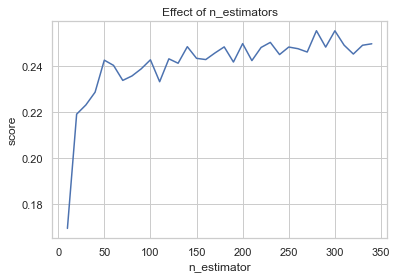

In [56]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [57]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  83.23505291483329
Random Forest Model STD:  939.1314970643649


In [58]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 81.14
R2: 0.25
Adjusted R2: 0.25


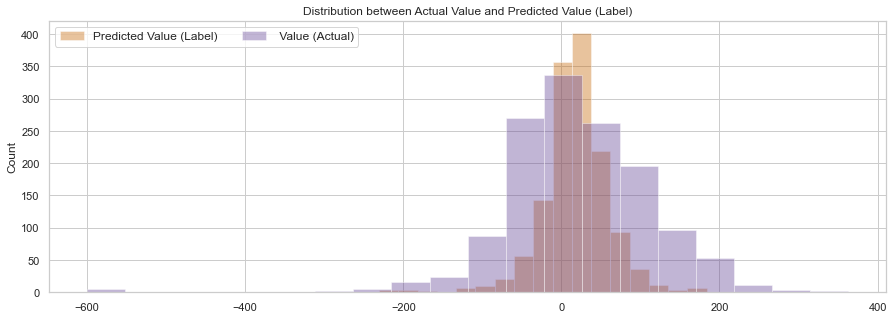

In [59]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [60]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [61]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [62]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  920


In [63]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6695778748180495


$\textbf{Light GBM}$

In [64]:

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))

# Printing out LightGBM Score and STD
lightgbm_score = cross_val_score(lightgbm, x, y, cv=kfolds, scoring='neg_mean_squared_error')
lightgbm_rmse = np.sqrt(-lightgbm_score.mean())
print("LIGHTGBM RMSE: ", lightgbm_rmse)
print("LIGHTGBM STD: ", lightgbm_score.std())

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [65]:
# Training Model for later
lightgbm.fit(train_X, train_y)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                               bagging_seed=9, feature_fraction=0.2319,
                               feature_fraction_seed=9, learning_rate=0.05,
                               max_bin=55, min_data_in_leaf=6,
                               min_sum_hessian_in_leaf=11, n_estimators=720,
                               num_leaves=5, objective='regression'))])

In [66]:
preds_train=lightgbm.predict(train_X)
preds1 = lightgbm.predict(test_X)

Evaluation on test data
RMSE: 86.71
R2: 0.14
Adjusted R2: 0.14


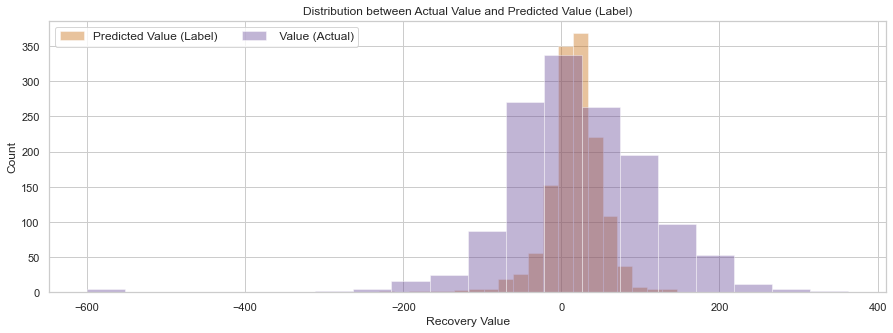

In [67]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_lightgbm = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_lightgbm["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_lightgbm["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [68]:
output_data_lightgbm.head(50)

output_data_lightgbm["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_lightgbm["Prediction"]]
output_data_lightgbm["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_lightgbm["Real"]]

In [69]:
output_data_lightgbm.head(50)
comparison_column = np.where(output_data_lightgbm["Prediction_sign"] == output_data_lightgbm["Real_sign"], True, False)

In [70]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  840


In [71]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.611353711790393


$\textbf{Ridge Regression}$

In [72]:
# Parameters for models
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv=kfolds))
ridge_score = cross_val_score(ridge, x, y, cv=kfolds, scoring='neg_mean_squared_error')
ridge_rmse =  np.sqrt(-ridge_score.mean())
# Printing out Ridge Score and STD
print("RIDGE RMSE: ", ridge_rmse)
print("RIDGE STD: ", ridge_score.std())

RIDGE RMSE:  94.61923867953946
RIDGE STD:  1154.556304768943


In [73]:
ridge.fit(train_X,train_y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                         cv=KFold(n_splits=5, random_state=42, shuffle=True)))])

In [74]:
preds_train=lightgbm.predict(train_X)
preds1 = lightgbm.predict(test_X)

Evaluation on test data
RMSE: 86.71
R2: 0.14
Adjusted R2: 0.14


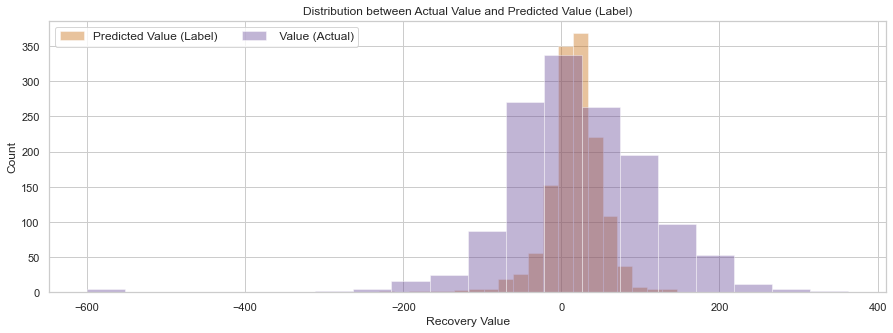

In [75]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_ridge_regression = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_ridge_regression["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_ridge_regression["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [76]:
output_data_ridge_regression["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_ridge_regression["Prediction"]]
output_data_ridge_regression["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_ridge_regression["Real"]]

In [77]:
comparison_column = np.where(output_data_ridge_regression["Prediction_sign"] == output_data_ridge_regression["Real_sign"], True, False)

In [78]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  840


In [79]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.611353711790393


$\textbf{Lasso Regression}$

In [80]:
# Lasso Model
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas = alphas2, random_state = 42, cv=kfolds))

# Printing Lasso Score with Cross-Validation
lasso_score = cross_val_score(lasso, x, y, cv=kfolds, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_score.mean())
print("LASSO RMSE: ", lasso_rmse)
print("LASSO STD: ", lasso_score.std())

LASSO RMSE:  94.61922490907553
LASSO STD:  1158.4516196169575


In [81]:
#train_X, test_X, train_y, y_test
lasso.fit(train_X,train_y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lassocv',
                 LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                 0.0006, 0.0007, 0.0008],
                         cv=KFold(n_splits=5, random_state=42, shuffle=True),
                         max_iter=10000000.0, random_state=42))])

In [82]:
preds_train=lasso.predict(train_X)
preds1 = lasso.predict(test_X)

Evaluation on test data
RMSE: 92.89
R2: 0.02
Adjusted R2: 0.01


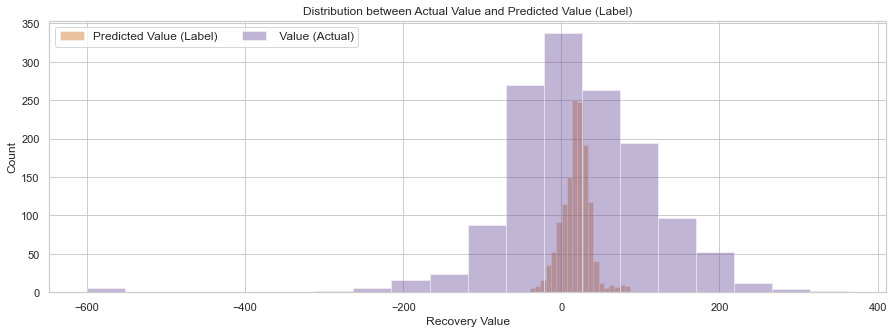

In [83]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_lasso_regression = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_lasso_regression["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_lasso_regression["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [84]:
output_data_lasso_regression["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_lasso_regression["Prediction"]]
output_data_lasso_regression["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_lasso_regression["Real"]]

In [85]:
comparison_column = np.where(output_data_lasso_regression["Prediction_sign"] == output_data_lasso_regression["Real_sign"], True, False)

In [86]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  826


In [87]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6011644832605532


$\textbf{Stacked Models}$

In [88]:
stack_gen = StackingCVRegressor(regressors=(modelCB,rf,ridge), 
                               meta_regressor=rf,
                               use_features_in_secondary=True)

stack_score = cross_val_score(stack_gen, x, y, cv=kfolds, scoring='neg_mean_squared_error')
stack_rmse = np.sqrt(-stack_score.mean())
print("STACK RMSE: ", stack_rmse)
print("STACK STD: ", stack_score.std())

KeyboardInterrupt: 

In [ ]:
#Training Model for later
stack_gen.fit(train_X,train_y)

In [ ]:
preds_train=stack_gen.predict(train_X)
preds1 = stack_gen.predict(test_X)

In [ ]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_stacked_model = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_stacked_model["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_stacked_model["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [ ]:
output_data_stacked_model["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Prediction"]]
output_data_stacked_model["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Real"]]

In [ ]:
comparison_column = np.where(output_data_stacked_model["Prediction_sign"] == output_data_stacked_model["Real_sign"], True, False)

In [ ]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

In [ ]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

$\textbf{XGBoost Regression}$

In [89]:
from sklearn.model_selection import RepeatedKFold
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 63.666 (2.368)


In [90]:
model.fit(train_X,train_y)
preds_train=model.predict(train_X)
preds1 = model.predict(test_X)

Evaluation on test data
RMSE: 84.44
R2: 0.19
Adjusted R2: 0.18
We have a total of True values :  873
Accuracy of True values compared to the total observations : 0.6353711790393013


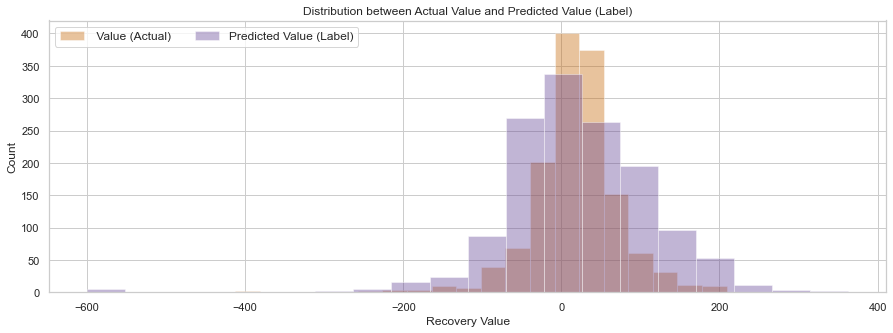

In [91]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_stacked_model = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_stacked_model["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_stacked_model["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



output_data_stacked_model["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Prediction"]]
output_data_stacked_model["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Real"]]

comparison_column = np.where(output_data_stacked_model["Prediction_sign"] == output_data_stacked_model["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

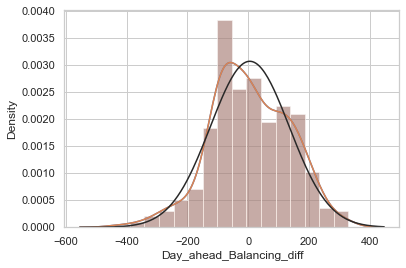

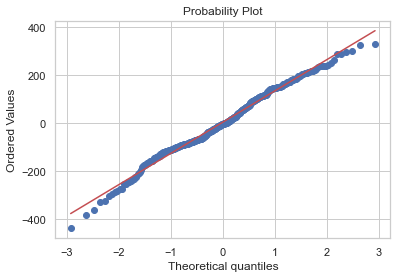

In [92]:
y_validation = april_data["Day_ahead_Balancing_diff"]

X_validation = april_data.drop("Day_ahead_Balancing_diff",axis=1)

from scipy.stats import norm
from scipy import stats
sns.distplot(y_validation);
sns.distplot(y_validation, fit=norm)
fig = plt.figure()
res = stats.probplot(y_validation, plot=plt)


from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = ["RES","Load","Mandatory Hydro","Total FRR","total_imports","total_esxports"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X_validation = ct.fit_transform(X_validation)
#test_X = ct.transform(test_X)



Evaluation on test data
RMSE: 134.58
R2: -0.07
Adjusted R2: -0.11
We have a total of True values :  194
Accuracy of True values compared to the total observations : 0.47549019607843135


array([0.1407767 , 0.81683168])

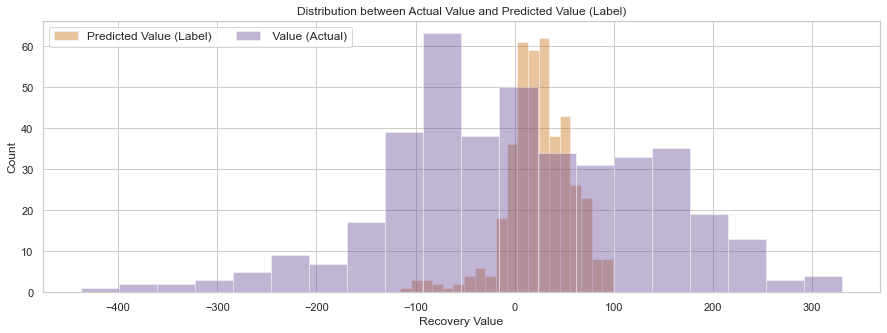

In [94]:



preds_train_validation = rf.predict(train_X_validation)
#preds1_stacked_model = stack_gen.predict(train_X_validation)
#preds1 = rf.predict(test_X)

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(y_validation,preds_train_validation))
#R2 Score
r2_test = r2_score(y_validation,preds_train_validation)
# Adjusted R2 Score
n= train_X_validation.shape[0] # total no of datapoints
p= train_X_validation.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds_train_validation,'Real': y_validation})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)





output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]


output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)


count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))



from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(output_data_random_forest["Real_sign"], output_data_random_forest["Prediction_sign"])
matrix.diagonal()/matrix.sum(axis=1)

$\textbf{Now we are going to add the Uplift feature i=1,2,3 and Holidays with is Weekend Categorical}$

* Random Forest Regression 
* CatBoost Regression

In [92]:
##### Add Uplift 1 
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.tail()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,total_imports,total_exports
2022-04-17 19:00:00,8.102876,2390.0,5708.0,498.5,1791.0,1829.0,0.0
2022-04-17 20:00:00,9.936461,2395.0,5485.0,405.0,1766.0,1839.0,0.0
2022-04-17 21:00:00,9.842898,2370.0,5065.0,140.0,1701.0,1502.0,97.0
2022-04-17 22:00:00,9.795277,2320.0,4551.5,15.0,1606.0,1499.0,414.0
2022-04-17 23:00:00,8.651543,2280.0,4201.0,0.0,1586.0,1501.0,468.0


In [93]:
df_info(x)

,type,Sample,% of NaN,Corr_with_y,Duplicates,Amount Uniques,Uniques,Outliers
Uplift Account 1 (€/MWh),float64,"[2.7385476725, 2.3758374875, 2.143069245000000...",0,NaN,0,5904,Several,0
RES,float64,"[1820.0, 1930.0, 2000.0, 2035.0, 2055.0]",0,NaN,0,857,Several,0
Load,float64,"[5515.5, 5299.0, 5127.5, 5038.0, 4951.5]",0,NaN,0,4219,Several,0
Mandatory Hydro,float64,"[50.0, 50.0, 50.0, 63.0, 76.0]",0,NaN,0,1553,Several,0
Total FRR,float64,"[914.0, 939.0, 949.0, 939.0, 1079.0]",0,NaN,0,475,Several,0
total_imports,float64,"[599.0, 735.0, 897.0, 1041.0, 1096.0]",0,NaN,0,1619,Several,0
total_exports,float64,"[533.0, 337.0, 315.0, 295.0, 293.0]",0,NaN,0,1470,Several,0


Boxplot, IQR, qutliner for Uplift account 1 (€/mwh)


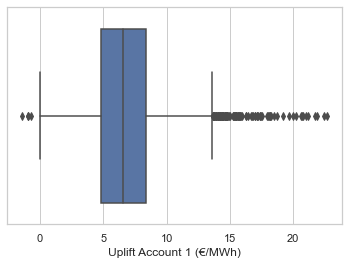

IQR For Uplift account 1 (€/mwh) Column :  3.505742676249998
There are 116 outliers out of 5904 data points.
There are many outliners in Uplift account 1 (€/mwh) columns
Boxplot, IQR, qutliner for Res


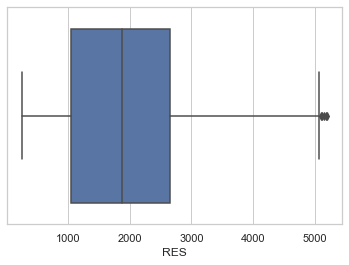

IQR For Res Column :  1610.0
There are 5 outliers out of 5904 data points.
There are many outliners in Res columns
Boxplot, IQR, qutliner for Load


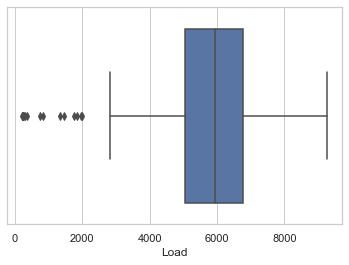

IQR For Load Column :  1709.75
There are 23 outliers out of 5904 data points.
There are many outliners in Load columns
Boxplot, IQR, qutliner for Mandatory hydro


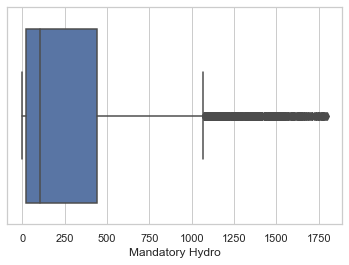

IQR For Mandatory hydro Column :  420.0
There are 598 outliers out of 5904 data points.
There are many outliners in Mandatory hydro columns
Boxplot, IQR, qutliner for Total frr


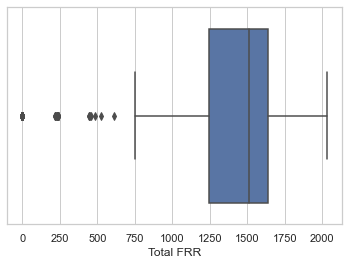

IQR For Total frr Column :  392.0
There are 168 outliers out of 5904 data points.
There are many outliners in Total frr columns
Boxplot, IQR, qutliner for Total_imports


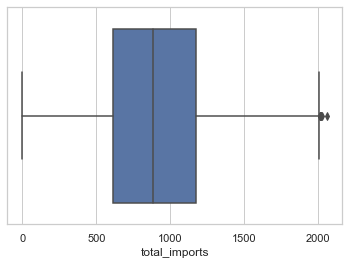

IQR For Total_imports Column :  558.5
There are 9 outliers out of 5904 data points.
There are many outliners in Total_imports columns
Boxplot, IQR, qutliner for Total_exports


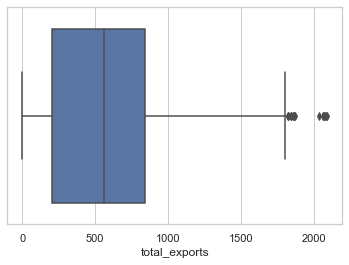

IQR For Total_exports Column :  641.5
There are 17 outliers out of 5904 data points.
There are many outliners in Total_exports columns


In [94]:
%matplotlib inline
from scipy import stats
n = x[x.columns[0]].count()
new_df = x.copy()

for name in x.columns: # this was "for name in names"
    print(f"Boxplot, IQR, qutliner for {name.capitalize()}")
    sns.boxplot(x=x[name])
    q1 = x[name].quantile(0.25)
    q3 = x[name].quantile(0.75)
    lower = q1 - 1.5 * stats.iqr(x[name],axis=0)
    upper = q3 + 1.5 * stats.iqr(x[name],axis=0)
    n_outliers = x[x[name] > upper][name].count() + x[x[name] < lower][name].count()
    plt.show()
    print(f"IQR For {name.capitalize()} Column : ",stats.iqr(x[name],axis=0))
    print(f"There are {n_outliers} outliers out of {n} data points.")
    if n_outliers != 0:
        p = n/n_outliers
        if p > 0.1:
            print(f"There are many outliners in {name.capitalize()} columns")
    
    new_df = new_df[new_df[name] < upper]
    new_df = new_df[new_df[name] > lower]

In [95]:
from holidays import Greece
greek_holidays = Greece()
# Have a look at all the holidays
[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]
def get_holiday(date):
  try:
    day_type = greek_holidays[date]
  except KeyError:
    day_type = 'None'
  return day_type

x['Holidays'] = x.index.map(lambda x: get_holiday(x))

x.head()
holidays=[greek_holidays[date] for date in greek_holidays[datetime.date(2021,8,15):datetime.date(2022,4,17)]]


x.loc[x['Holidays'] =='None','Holidays'] = 0
x.loc[x["Holidays"].isin(holidays),'Holidays'] = 1
x.head()

x["Date"] = pd.to_datetime(x.index)
x["IsWeekend"] = x["Date"].dt.weekday >= 5

x.replace({False: 0, True: 1}, inplace=True)

x = x.drop("Date",axis=1)
# display the dataframe


x.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,total_imports,total_exports,Holidays,IsWeekend
2021-08-15 00:00:00,2.738548,1820.0,5515.5,50.0,914.0,599.0,533.0,1,1
2021-08-15 01:00:00,2.375837,1930.0,5299.0,50.0,939.0,735.0,337.0,1,1
2021-08-15 02:00:00,2.143069,2000.0,5127.5,50.0,949.0,897.0,315.0,1,1
2021-08-15 03:00:00,2.043232,2035.0,5038.0,63.0,939.0,1041.0,295.0,1,1
2021-08-15 04:00:00,2.227400,2055.0,4951.5,76.0,1079.0,1096.0,293.0,1,1


In [96]:
x.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,total_imports,total_exports,Holidays,IsWeekend
2021-08-15 00:00:00,2.738548,1820.0,5515.5,50.0,914.0,599.0,533.0,1,1
2021-08-15 01:00:00,2.375837,1930.0,5299.0,50.0,939.0,735.0,337.0,1,1
2021-08-15 02:00:00,2.143069,2000.0,5127.5,50.0,949.0,897.0,315.0,1,1
2021-08-15 03:00:00,2.043232,2035.0,5038.0,63.0,939.0,1041.0,295.0,1,1
2021-08-15 04:00:00,2.227400,2055.0,4951.5,76.0,1079.0,1096.0,293.0,1,1


In [97]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [98]:
train_X.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,total_imports,total_exports,Holidays,IsWeekend
2022-01-28 13:00:00,7.210557,2530.0,7240.5,160.0,1476.0,568.0,227.0,0,0
2021-09-28 15:00:00,5.531614,1685.0,5883.5,0.0,1764.0,519.0,709.0,0,0
2021-12-30 17:00:00,6.762202,3220.0,7226.0,1625.5,1779.0,501.0,1019.0,0,0
2022-04-10 07:00:00,7.796588,2725.0,4423.5,197.0,1661.0,1142.0,219.0,0,1
2021-10-10 18:00:00,6.703828,955.0,5731.0,581.5,1914.0,893.0,532.0,0,1


In [99]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = ["Uplift Account 1 (€/MWh)","RES","Load","Mandatory Hydro","Total FRR","total_exports","total_imports"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

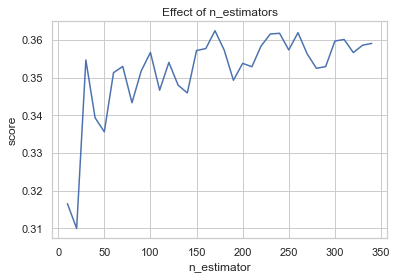

In [100]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [101]:
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  80.86762101780772
Random Forest Model STD:  308.66873353585055


In [102]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 79.72
R2: 0.36
Adjusted R2: 0.36


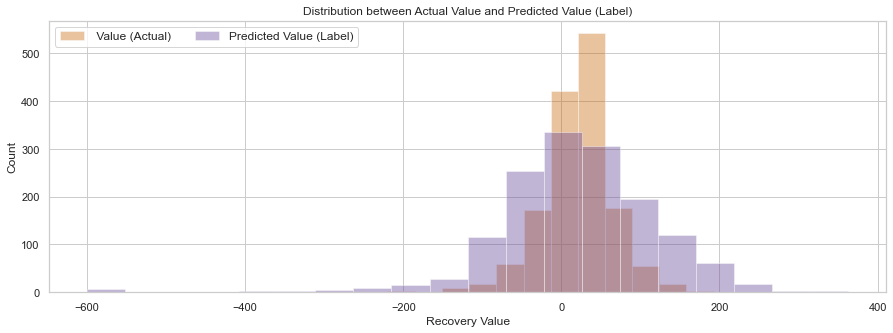

In [103]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [109]:
output_data_random_forest.head(50)
output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [110]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [111]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  1036


In [112]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.7018970189701897


Evaluation on test data
RMSE: 79.17
R2: 0.37
Adjusted R2: 0.37
We have a total of True values :  1048
Accuracy of True values compared to the total observations : 0.7100271002710027


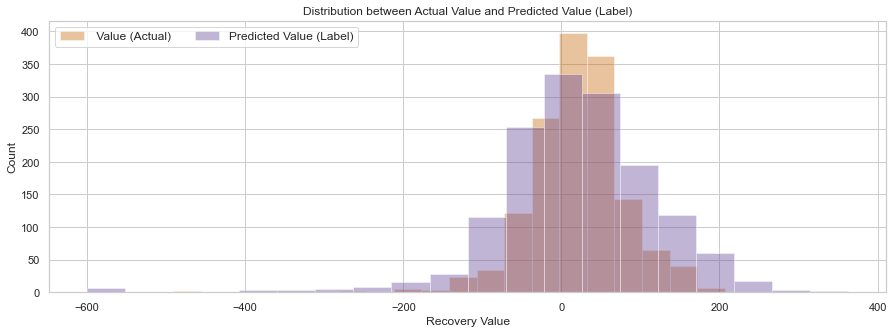

In [113]:
#Training Model for later
stack_gen.fit(train_X,train_y)

preds_train=stack_gen.predict(train_X)
preds1 = stack_gen.predict(test_X)

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_stacked_model = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_stacked_model["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_stacked_model["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



output_data_stacked_model["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Prediction"]]
output_data_stacked_model["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Real"]]

comparison_column = np.where(output_data_stacked_model["Prediction_sign"] == output_data_stacked_model["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

$\textbf{We are going to test the Model is some Data fro  2022/04/26 until 2022/04/30}$

In [244]:
Data_Test = pd.read_csv('Data_classification.csv')
data_may_test = pd.read_csv('Data_optimization_May.csv')


columns_data_test = Data_Test.columns
data_may_test.head()
data_may_columns = data_may_test.columns

In [245]:
Data_Test.head()

,Unnamed: 0,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Diff_direction,Gradient_Boosting_Classification,Neural_network_Classification,Holidays,IsWeekend,Day_ahead_Balancing_diff,Date
0,2022-04-26 00:00:00,9.139706,960.0,4196.0,0.0,841.0,1,0,1,0,0,235.420,2022-04-26 00:00:00
1,2022-04-26 01:00:00,8.887252,910.0,4081.0,0.0,846.0,1,0,1,0,0,222.745,2022-04-26 01:00:00
2,2022-04-26 02:00:00,8.544882,875.0,3999.5,0.0,846.0,1,0,1,0,0,228.630,2022-04-26 02:00:00
3,2022-04-26 03:00:00,8.319490,840.0,4007.5,13.0,861.0,1,0,1,0,0,218.865,2022-04-26 03:00:00
4,2022-04-26 04:00:00,8.380914,780.0,4083.5,86.0,1031.0,1,0,0,0,0,218.980,2022-04-26 04:00:00


In [246]:
Data_Test[columns_data_test[0]] = pd.to_datetime(Data_Test[columns_data_test[0]])
Data_Test.set_index(columns_data_test[0], drop=True, inplace=True)
Data_Test.index.name = None

In [247]:
data_may_test[data_may_columns[0]] = pd.to_datetime(data_may_test[data_may_columns[0]])
data_may_test.set_index(data_may_columns[0], drop=True, inplace=True)
data_may_test.index.name = None

In [248]:
data_train_may = data_may_test.drop(data_may_columns[1],axis=1)
data_train_may = data_train_may.drop(data_may_columns[9],axis=1)
data_train_may

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Total_imports,Total_epxorts,Day_ahead_Balancing_diff,Holidays,IsWeekend
2022-05-01 00:00:00,7.190630,1480.0,3741.0,0.0,896.0,0.0,321.0,60.985051,1,1
2022-05-01 01:00:00,9.164002,1530.0,3621.5,0.0,906.0,0.0,512.0,-153.897500,1,1
2022-05-01 02:00:00,9.272240,1585.0,3546.5,0.0,906.0,0.0,510.0,-202.380837,1,1
2022-05-01 03:00:00,8.837913,1655.0,3516.0,13.0,906.0,2.0,460.0,-111.378457,1,1
2022-05-01 04:00:00,8.880369,1705.0,3491.0,81.0,1091.0,0.0,419.0,-119.081816,1,1
2022-05-01 05:00:00,9.053331,1810.0,3537.5,171.0,1321.0,0.0,287.0,-119.708399,1,1
2022-05-01 06:00:00,8.783511,2145.0,3868.5,193.0,1426.0,0.0,466.0,-131.298384,1,1
2022-05-01 07:00:00,7.789889,2680.0,4369.5,168.0,1416.0,0.0,510.0,-144.970220,1,1
2022-05-01 08:00:00,7.097341,3300.0,4816.0,113.0,1461.0,0.0,460.0,-145.440540,1,1
2022-05-01 09:00:00,5.769529,3805.0,5174.5,50.0,1511.0,37.0,529.0,-148.800000,1,1


In [249]:
Data_Test = Data_Test.drop("Date",axis=1)

In [250]:
Data_Test.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Diff_direction,Gradient_Boosting_Classification,Neural_network_Classification,Holidays,IsWeekend,Day_ahead_Balancing_diff
2022-04-26 00:00:00,9.139706,960.0,4196.0,0.0,841.0,1,0,1,0,0,235.420
2022-04-26 01:00:00,8.887252,910.0,4081.0,0.0,846.0,1,0,1,0,0,222.745
2022-04-26 02:00:00,8.544882,875.0,3999.5,0.0,846.0,1,0,1,0,0,228.630
2022-04-26 03:00:00,8.319490,840.0,4007.5,13.0,861.0,1,0,1,0,0,218.865
2022-04-26 04:00:00,8.380914,780.0,4083.5,86.0,1031.0,1,0,0,0,0,218.980


In [251]:
direction_classification = Data_Test[[columns_data_test[6],columns_data_test[7],columns_data_test[8]]]
Data_Test = Data_Test.drop([columns_data_test[6],columns_data_test[7],columns_data_test[8]],axis=1)


In [252]:
data_scada_test = scada_data.loc[  scada_data.index >= datetime.datetime(2022,4,26)][["TOTAL IMPORTS","TOTAL EXPORTS"]]

In [253]:
Data_Test = Data_Test.drop('Uplift Account 1 (€/MWh)',axis=1)

In [254]:
y_validation = Data_Test["Day_ahead_Balancing_diff"]

X_validation = Data_Test.drop("Day_ahead_Balancing_diff",axis=1)

In [408]:
data_scada_test

,ΑΛΒΑΝΙΑ_IMP,ΒΟΥΛΓΑΡΙΑ_IMP,FYROM_IMP,ΙΤΑΛΙΑ_IMP,ΤΟΥΡΚΙΑ_IMP,ΑΛΒΑΝΙΑ_EXP,ΒΟΥΛΓΑΡΙΑ_EXP,FYROM_EXP,ΙΤΑΛΙΑ_EXP,ΤΟΥΡΚΙΑ_EXP
2022-04-26 00:00:00,186.0,309.0,436.0,0.0,370.0,0.0,0.0,0.0,331.0,0.0
2022-04-26 01:00:00,111.0,332.0,374.0,0.0,441.0,0.0,0.0,0.0,58.0,0.0
2022-04-26 02:00:00,147.0,377.0,461.0,43.0,504.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 03:00:00,150.0,384.0,459.0,0.0,528.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 04:00:00,159.0,389.0,446.0,2.0,523.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 05:00:00,179.0,379.0,459.0,60.0,504.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 06:00:00,261.0,335.0,489.0,164.0,412.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 07:00:00,182.0,192.0,251.0,209.0,318.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 08:00:00,92.0,105.0,98.0,471.0,298.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 09:00:00,64.0,101.0,77.0,181.0,292.0,0.0,0.0,0.0,0.0,0.0


In [410]:
X_validation

,RES,Load,Mandatory Hydro,Total FRR,Holidays,IsWeekend,Total_imports,Total_exports,ΑΛΒΑΝΙΑ_IMP,ΒΟΥΛΓΑΡΙΑ_IMP,FYROM_IMP,ΙΤΑΛΙΑ_IMP,ΤΟΥΡΚΙΑ_IMP,ΑΛΒΑΝΙΑ_EXP,ΒΟΥΛΓΑΡΙΑ_EXP,FYROM_EXP,ΙΤΑΛΙΑ_EXP,ΤΟΥΡΚΙΑ_EXP
2022-04-26 00:00:00,960.0,4196.0,0.0,841.0,0,0,1301.0,331.0,186.0,309.0,436.0,0.0,370.0,0.0,0.0,0.0,331.0,0.0
2022-04-26 01:00:00,910.0,4081.0,0.0,846.0,0,0,1258.0,58.0,111.0,332.0,374.0,0.0,441.0,0.0,0.0,0.0,58.0,0.0
2022-04-26 02:00:00,875.0,3999.5,0.0,846.0,0,0,1532.0,0.0,147.0,377.0,461.0,43.0,504.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 03:00:00,840.0,4007.5,13.0,861.0,0,0,1521.0,0.0,150.0,384.0,459.0,0.0,528.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 04:00:00,780.0,4083.5,86.0,1031.0,0,0,1519.0,0.0,159.0,389.0,446.0,2.0,523.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 05:00:00,815.0,4414.0,198.5,1321.0,0,0,1581.0,0.0,179.0,379.0,459.0,60.0,504.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 06:00:00,1255.0,4928.0,246.0,1521.0,0,0,1661.0,0.0,261.0,335.0,489.0,164.0,412.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 07:00:00,2035.0,5380.0,166.5,1521.0,0,0,1152.0,0.0,182.0,192.0,251.0,209.0,318.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 08:00:00,2795.0,5645.5,62.0,1476.0,0,0,1064.0,0.0,92.0,105.0,98.0,471.0,298.0,0.0,0.0,0.0,0.0,0.0
2022-04-26 09:00:00,3360.0,5781.0,31.0,1456.0,0,0,715.0,0.0,64.0,101.0,77.0,181.0,292.0,0.0,0.0,0.0,0.0,0.0


In [258]:
y_validation_may = data_train_may["Day_ahead_Balancing_diff"]

X_validation_may = data_train_may.drop("Day_ahead_Balancing_diff",axis=1)
X_validation_may["Total_exports"] = X_validation_may["Total_epxorts"]
X_validation_may = X_validation_may.drop("Total_epxorts",axis=1)


In [259]:
X_validation_may =X_validation_may.drop('Uplift Account 1 (€/MWh)',axis=1)

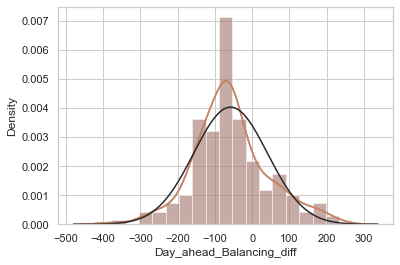

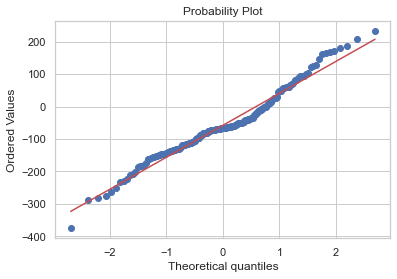

In [118]:
from scipy.stats import norm
from scipy import stats
sns.distplot(y_validation_may);
sns.distplot(y_validation_may, fit=norm)
fig = plt.figure()
res = stats.probplot(y_validation_may, plot=plt)



In [131]:
X_validation["Total_imports"] = data_scada_test["TOTAL IMPORTS"]
X_validation["Total_exports"] = data_scada_test["TOTAL EXPORTS"]
#X_validation = X_validation.drop("Uplift Account 1 (€/MWh)",axis=1)

In [418]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = ["RES","Load","Mandatory Hydro","Total FRR","Total_imports","Total_exports"]

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X_validation = ct.fit_transform(X_validation_may)
#test_X = ct.transform(test_X)

$\textbf{Model Containing mport Exports with Stacked Model}$

Evaluation on test data
RMSE: 124.91
R2: -0.59
Adjusted R2: -0.89


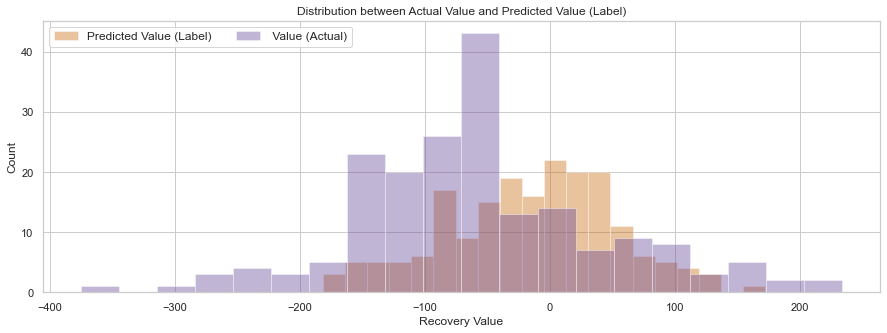

In [420]:


preds_train_validation = modelCB.predict(train_X_validation)
#preds1_stacked_model = stack_gen.predict(train_X_validation)
#preds1 = rf.predict(test_X)

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(y_validation_may,preds_train_validation))
#R2 Score
r2_test = r2_score(y_validation_may,preds_train_validation)
# Adjusted R2 Score
n= train_X_validation.shape[0] # total no of datapoints
p= train_X_validation.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds_train_validation,'Real': y_validation_may})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)





In [421]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]


output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)


count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))



We have a total of True values :  106
Accuracy of True values compared to the total observations : 0.5520833333333334


In [422]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(output_data_random_forest["Real_sign"], output_data_random_forest["Prediction_sign"])
matrix.diagonal()/matrix.sum(axis=1)

array([0.56375839, 0.51162791])

In [423]:
output_data_random_forest

,Prediction,Real,Prediction_sign,Real_sign
2022-05-01 00:00:00,82.085726,60.985051,1,1
2022-05-01 01:00:00,73.870980,-153.897500,1,0
2022-05-01 02:00:00,85.042463,-202.380837,1,0
2022-05-01 03:00:00,75.353707,-111.378457,1,0
2022-05-01 04:00:00,-58.219015,-119.081816,0,0
2022-05-01 05:00:00,-24.320213,-119.708399,0,0
2022-05-01 06:00:00,-3.451774,-131.298384,0,0
2022-05-01 07:00:00,-22.600291,-144.970220,0,0
2022-05-01 08:00:00,-21.292620,-145.440540,0,0
2022-05-01 09:00:00,172.153776,-148.800000,1,0


In [292]:
##### Add Uplift 1 
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()



,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,2.738548,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,2.375837,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2.143069,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2.043232,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2.227400,2055.0,4951.5,76.0,1079.0


In [293]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score


train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [294]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMS:  89.97503332579825


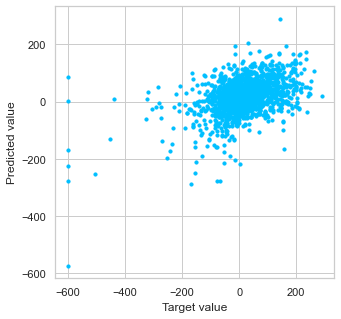

In [295]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(train_X, 
                  train_y)
test_pool = Pool(test_X) 


####{'colsample_bylevel': 4, 'learning_rate': 5, 'max_depth': 4}, 

#### Grid Search 
# {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
modelCB = CatBoostRegressor(iterations=8000,
                           depth=4,
                           learning_rate=0.08,
                           loss_function='RMSE',
                           silent=True)

modelCB.fit(train_pool,plot=True)

preds1 = modelCB.predict(test_pool)

preds_train=modelCB.predict(train_pool)
# evaluate predictions
rms1 = mean_squared_error(test_y, preds1, squared=False) #np.sqrt(np.mean((preds1 - test_y) ** 2))
print("RMS: ", rms1)
#print(preds1)



plt.figure(figsize=(5,5))
plt.scatter(test_y, preds1, s=10, color="deepskyblue")
plt.xlabel("Target value")
plt.ylabel("Predicted value")
print(train_pool)

Accuracy is :  -203.56052802726896


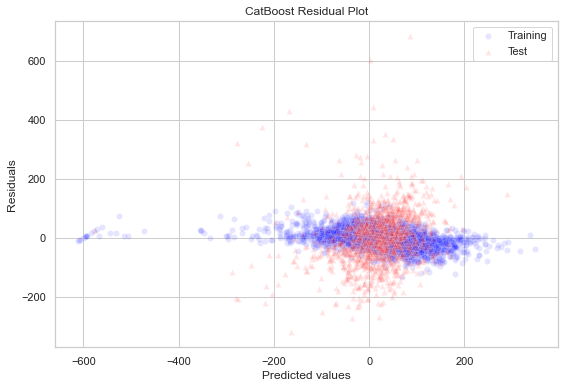

Evaluation on test data
RMSE: 89.98
R2: 0.16
Adjusted R2: 0.16
We have a total of True values :  963
Accuracy of True values compared to the total observations : 0.6524390243902439
Test set evaluation:
_____________________________________
MAE: 66.74849362568084
MSE: 8095.506621978506
RMSE: 89.97503332579825
R2 Square 0.16060137646481554
__________________________________
Train set evaluation:
_____________________________________
MAE: 21.74787897810217
MSE: 822.8535059824767
RMSE: 28.685423231712594
R2 Square 0.9160409474749318
__________________________________
Learning rate set to 0.052543
0:	learn: 102.1978165	total: 10.7ms	remaining: 10.7s
1:	learn: 101.5624586	total: 14.4ms	remaining: 7.17s
2:	learn: 101.0179821	total: 18ms	remaining: 5.99s
3:	learn: 100.5346062	total: 22.4ms	remaining: 5.57s
4:	learn: 100.0849358	total: 25.9ms	remaining: 5.16s
5:	learn: 99.5692605	total: 29.5ms	remaining: 4.89s
6:	learn: 99.1364292	total: 33.3ms	remaining: 4.73s
7:	learn: 98.7494503	total: 37ms	

189:	learn: 81.2721056	total: 807ms	remaining: 3.44s
190:	learn: 81.2400667	total: 811ms	remaining: 3.43s
191:	learn: 81.1967429	total: 814ms	remaining: 3.43s
192:	learn: 81.1505603	total: 818ms	remaining: 3.42s
193:	learn: 81.1073570	total: 822ms	remaining: 3.42s
194:	learn: 81.0641278	total: 826ms	remaining: 3.41s
195:	learn: 81.0151144	total: 830ms	remaining: 3.4s
196:	learn: 80.9706789	total: 833ms	remaining: 3.4s
197:	learn: 80.9269642	total: 837ms	remaining: 3.39s
198:	learn: 80.8955604	total: 841ms	remaining: 3.38s
199:	learn: 80.8535506	total: 844ms	remaining: 3.38s
200:	learn: 80.7866250	total: 847ms	remaining: 3.37s
201:	learn: 80.7389941	total: 851ms	remaining: 3.36s
202:	learn: 80.6857688	total: 856ms	remaining: 3.36s
203:	learn: 80.6393738	total: 860ms	remaining: 3.35s
204:	learn: 80.5948060	total: 863ms	remaining: 3.35s
205:	learn: 80.5306991	total: 867ms	remaining: 3.34s
206:	learn: 80.4942546	total: 870ms	remaining: 3.33s
207:	learn: 80.4399543	total: 874ms	remaining: 3

364:	learn: 74.7615221	total: 1.65s	remaining: 2.87s
365:	learn: 74.7419929	total: 1.65s	remaining: 2.87s
366:	learn: 74.6992977	total: 1.66s	remaining: 2.87s
367:	learn: 74.6600478	total: 1.67s	remaining: 2.86s
368:	learn: 74.6311601	total: 1.67s	remaining: 2.86s
369:	learn: 74.6165934	total: 1.68s	remaining: 2.86s
370:	learn: 74.5846638	total: 1.68s	remaining: 2.85s
371:	learn: 74.5703118	total: 1.69s	remaining: 2.85s
372:	learn: 74.5452047	total: 1.69s	remaining: 2.85s
373:	learn: 74.5021743	total: 1.7s	remaining: 2.84s
374:	learn: 74.4905918	total: 1.7s	remaining: 2.83s
375:	learn: 74.4396316	total: 1.71s	remaining: 2.83s
376:	learn: 74.4299710	total: 1.71s	remaining: 2.83s
377:	learn: 74.4070867	total: 1.71s	remaining: 2.82s
378:	learn: 74.3835456	total: 1.72s	remaining: 2.81s
379:	learn: 74.3564047	total: 1.72s	remaining: 2.81s
380:	learn: 74.3250249	total: 1.73s	remaining: 2.8s
381:	learn: 74.3064225	total: 1.73s	remaining: 2.8s
382:	learn: 74.2855277	total: 1.74s	remaining: 2.8

528:	learn: 70.4739908	total: 2.46s	remaining: 2.19s
529:	learn: 70.4554089	total: 2.46s	remaining: 2.18s
530:	learn: 70.4357625	total: 2.46s	remaining: 2.17s
531:	learn: 70.4092209	total: 2.47s	remaining: 2.17s
532:	learn: 70.3835264	total: 2.48s	remaining: 2.17s
533:	learn: 70.3537256	total: 2.48s	remaining: 2.16s
534:	learn: 70.3292439	total: 2.49s	remaining: 2.16s
535:	learn: 70.3005834	total: 2.49s	remaining: 2.16s
536:	learn: 70.2876613	total: 2.49s	remaining: 2.15s
537:	learn: 70.2626074	total: 2.5s	remaining: 2.15s
538:	learn: 70.2419383	total: 2.51s	remaining: 2.14s
539:	learn: 70.2195441	total: 2.51s	remaining: 2.14s
540:	learn: 70.1884421	total: 2.52s	remaining: 2.13s
541:	learn: 70.1697771	total: 2.52s	remaining: 2.13s
542:	learn: 70.1447021	total: 2.53s	remaining: 2.13s
543:	learn: 70.1222265	total: 2.53s	remaining: 2.12s
544:	learn: 70.0902407	total: 2.54s	remaining: 2.12s
545:	learn: 70.0708775	total: 2.54s	remaining: 2.12s
546:	learn: 70.0483884	total: 2.55s	remaining: 

691:	learn: 66.9837084	total: 3.28s	remaining: 1.46s
692:	learn: 66.9603493	total: 3.29s	remaining: 1.46s
693:	learn: 66.9391421	total: 3.29s	remaining: 1.45s
694:	learn: 66.9226079	total: 3.3s	remaining: 1.45s
695:	learn: 66.8986762	total: 3.3s	remaining: 1.44s
696:	learn: 66.8861331	total: 3.31s	remaining: 1.44s
697:	learn: 66.8648015	total: 3.31s	remaining: 1.43s
698:	learn: 66.8483100	total: 3.32s	remaining: 1.43s
699:	learn: 66.8239361	total: 3.33s	remaining: 1.43s
700:	learn: 66.8102957	total: 3.33s	remaining: 1.42s
701:	learn: 66.7948553	total: 3.33s	remaining: 1.41s
702:	learn: 66.7804875	total: 3.34s	remaining: 1.41s
703:	learn: 66.7656912	total: 3.34s	remaining: 1.41s
704:	learn: 66.7479537	total: 3.35s	remaining: 1.4s
705:	learn: 66.7221292	total: 3.36s	remaining: 1.4s
706:	learn: 66.6975604	total: 3.36s	remaining: 1.39s
707:	learn: 66.6666812	total: 3.36s	remaining: 1.39s
708:	learn: 66.6442821	total: 3.37s	remaining: 1.38s
709:	learn: 66.6327436	total: 3.38s	remaining: 1.3

854:	learn: 64.1139593	total: 4.12s	remaining: 698ms
855:	learn: 64.1064239	total: 4.12s	remaining: 694ms
856:	learn: 64.0932037	total: 4.13s	remaining: 689ms
857:	learn: 64.0868802	total: 4.13s	remaining: 684ms
858:	learn: 64.0779995	total: 4.14s	remaining: 679ms
859:	learn: 64.0638850	total: 4.14s	remaining: 675ms
860:	learn: 64.0560659	total: 4.15s	remaining: 670ms
861:	learn: 64.0436271	total: 4.15s	remaining: 665ms
862:	learn: 64.0126909	total: 4.16s	remaining: 660ms
863:	learn: 64.0025926	total: 4.16s	remaining: 655ms
864:	learn: 63.9872753	total: 4.17s	remaining: 650ms
865:	learn: 63.9828714	total: 4.17s	remaining: 646ms
866:	learn: 63.9624235	total: 4.18s	remaining: 641ms
867:	learn: 63.9527116	total: 4.18s	remaining: 636ms
868:	learn: 63.9466154	total: 4.19s	remaining: 631ms
869:	learn: 63.9339861	total: 4.19s	remaining: 626ms
870:	learn: 63.9174449	total: 4.2s	remaining: 622ms
871:	learn: 63.8986570	total: 4.21s	remaining: 618ms
872:	learn: 63.8940642	total: 4.21s	remaining: 

12:	learn: 97.2702604	total: 57.6ms	remaining: 4.37s
13:	learn: 97.0045984	total: 62ms	remaining: 4.37s
14:	learn: 96.7040447	total: 65.5ms	remaining: 4.3s
15:	learn: 96.4577725	total: 72.1ms	remaining: 4.43s
16:	learn: 96.1656117	total: 76.1ms	remaining: 4.4s
17:	learn: 95.9898806	total: 79.5ms	remaining: 4.34s
18:	learn: 95.7799162	total: 86.2ms	remaining: 4.45s
19:	learn: 95.6043648	total: 90.6ms	remaining: 4.44s
20:	learn: 95.4143462	total: 94ms	remaining: 4.38s
21:	learn: 95.2072213	total: 98.2ms	remaining: 4.37s
22:	learn: 94.9490287	total: 104ms	remaining: 4.44s
23:	learn: 94.7367447	total: 108ms	remaining: 4.4s
24:	learn: 94.5443290	total: 112ms	remaining: 4.38s
25:	learn: 94.3670639	total: 119ms	remaining: 4.46s
26:	learn: 94.1480087	total: 123ms	remaining: 4.43s
27:	learn: 93.9650131	total: 130ms	remaining: 4.51s
28:	learn: 93.7997006	total: 137ms	remaining: 4.58s
29:	learn: 93.6193723	total: 141ms	remaining: 4.55s
30:	learn: 93.4000618	total: 148ms	remaining: 4.64s
31:	learn

187:	learn: 81.6859806	total: 893ms	remaining: 3.86s
188:	learn: 81.6295669	total: 897ms	remaining: 3.85s
189:	learn: 81.5871325	total: 902ms	remaining: 3.85s
190:	learn: 81.5437810	total: 907ms	remaining: 3.84s
191:	learn: 81.5097081	total: 911ms	remaining: 3.83s
192:	learn: 81.4603088	total: 916ms	remaining: 3.83s
193:	learn: 81.4172522	total: 921ms	remaining: 3.83s
194:	learn: 81.3837136	total: 925ms	remaining: 3.82s
195:	learn: 81.3437836	total: 930ms	remaining: 3.81s
196:	learn: 81.3056492	total: 935ms	remaining: 3.81s
197:	learn: 81.2681330	total: 940ms	remaining: 3.81s
198:	learn: 81.2179811	total: 944ms	remaining: 3.8s
199:	learn: 81.1777803	total: 952ms	remaining: 3.81s
200:	learn: 81.1304445	total: 956ms	remaining: 3.8s
201:	learn: 81.0824398	total: 960ms	remaining: 3.79s
202:	learn: 81.0445633	total: 964ms	remaining: 3.78s
203:	learn: 80.9956471	total: 969ms	remaining: 3.78s
204:	learn: 80.9429254	total: 973ms	remaining: 3.77s
205:	learn: 80.8531599	total: 977ms	remaining: 3

369:	learn: 74.5839275	total: 1.57s	remaining: 2.68s
370:	learn: 74.5352079	total: 1.58s	remaining: 2.68s
371:	learn: 74.4914942	total: 1.58s	remaining: 2.67s
372:	learn: 74.4642134	total: 1.59s	remaining: 2.67s
373:	learn: 74.4368179	total: 1.59s	remaining: 2.67s
374:	learn: 74.4167282	total: 1.6s	remaining: 2.66s
375:	learn: 74.3866143	total: 1.6s	remaining: 2.65s
376:	learn: 74.3559669	total: 1.6s	remaining: 2.65s
377:	learn: 74.3271394	total: 1.61s	remaining: 2.65s
378:	learn: 74.3081385	total: 1.61s	remaining: 2.65s
379:	learn: 74.2943582	total: 1.62s	remaining: 2.64s
380:	learn: 74.2709788	total: 1.62s	remaining: 2.64s
381:	learn: 74.2418758	total: 1.63s	remaining: 2.63s
382:	learn: 74.2051930	total: 1.63s	remaining: 2.63s
383:	learn: 74.1854648	total: 1.64s	remaining: 2.63s
384:	learn: 74.1578979	total: 1.64s	remaining: 2.63s
385:	learn: 74.1308123	total: 1.65s	remaining: 2.62s
386:	learn: 74.1066862	total: 1.66s	remaining: 2.62s
387:	learn: 74.0769914	total: 1.66s	remaining: 2.

535:	learn: 70.0646329	total: 2.25s	remaining: 1.95s
536:	learn: 70.0219232	total: 2.25s	remaining: 1.94s
537:	learn: 70.0043117	total: 2.25s	remaining: 1.94s
538:	learn: 69.9849591	total: 2.26s	remaining: 1.93s
539:	learn: 69.9510301	total: 2.26s	remaining: 1.93s
540:	learn: 69.9153924	total: 2.26s	remaining: 1.92s
541:	learn: 69.8939659	total: 2.27s	remaining: 1.92s
542:	learn: 69.8755168	total: 2.27s	remaining: 1.91s
543:	learn: 69.8573741	total: 2.27s	remaining: 1.91s
544:	learn: 69.8337821	total: 2.28s	remaining: 1.9s
545:	learn: 69.8145463	total: 2.28s	remaining: 1.9s
546:	learn: 69.7907045	total: 2.29s	remaining: 1.89s
547:	learn: 69.7720203	total: 2.29s	remaining: 1.89s
548:	learn: 69.7566838	total: 2.29s	remaining: 1.88s
549:	learn: 69.7426103	total: 2.3s	remaining: 1.88s
550:	learn: 69.7118684	total: 2.3s	remaining: 1.87s
551:	learn: 69.6674399	total: 2.3s	remaining: 1.87s
552:	learn: 69.6540718	total: 2.31s	remaining: 1.87s
553:	learn: 69.6223400	total: 2.31s	remaining: 1.86

705:	learn: 66.3964401	total: 2.9s	remaining: 1.21s
706:	learn: 66.3789489	total: 2.91s	remaining: 1.2s
707:	learn: 66.3572683	total: 2.92s	remaining: 1.2s
708:	learn: 66.3252033	total: 2.92s	remaining: 1.2s
709:	learn: 66.3031747	total: 2.92s	remaining: 1.19s
710:	learn: 66.2858827	total: 2.93s	remaining: 1.19s
711:	learn: 66.2679316	total: 2.93s	remaining: 1.19s
712:	learn: 66.2485356	total: 2.94s	remaining: 1.18s
713:	learn: 66.2247343	total: 2.94s	remaining: 1.18s
714:	learn: 66.2040568	total: 2.95s	remaining: 1.17s
715:	learn: 66.1870166	total: 2.95s	remaining: 1.17s
716:	learn: 66.1757527	total: 2.96s	remaining: 1.17s
717:	learn: 66.1621228	total: 2.96s	remaining: 1.16s
718:	learn: 66.1340741	total: 2.97s	remaining: 1.16s
719:	learn: 66.1281448	total: 2.97s	remaining: 1.16s
720:	learn: 66.1249619	total: 2.98s	remaining: 1.15s
721:	learn: 66.1029494	total: 2.98s	remaining: 1.15s
722:	learn: 66.0878278	total: 2.98s	remaining: 1.14s
723:	learn: 66.0601711	total: 2.99s	remaining: 1.1

869:	learn: 63.5162081	total: 3.57s	remaining: 534ms
870:	learn: 63.4888126	total: 3.58s	remaining: 530ms
871:	learn: 63.4828813	total: 3.58s	remaining: 526ms
872:	learn: 63.4654073	total: 3.59s	remaining: 522ms
873:	learn: 63.4500112	total: 3.59s	remaining: 518ms
874:	learn: 63.4415483	total: 3.6s	remaining: 514ms
875:	learn: 63.4111487	total: 3.6s	remaining: 510ms
876:	learn: 63.3972407	total: 3.61s	remaining: 506ms
877:	learn: 63.3875091	total: 3.61s	remaining: 502ms
878:	learn: 63.3664305	total: 3.62s	remaining: 498ms
879:	learn: 63.3507739	total: 3.62s	remaining: 494ms
880:	learn: 63.3303651	total: 3.63s	remaining: 490ms
881:	learn: 63.3054653	total: 3.63s	remaining: 486ms
882:	learn: 63.2881835	total: 3.63s	remaining: 482ms
883:	learn: 63.2666016	total: 3.64s	remaining: 478ms
884:	learn: 63.2559008	total: 3.65s	remaining: 474ms
885:	learn: 63.2403849	total: 3.65s	remaining: 470ms
886:	learn: 63.2322518	total: 3.66s	remaining: 466ms
887:	learn: 63.2051182	total: 3.66s	remaining: 4

36:	learn: 89.1892676	total: 132ms	remaining: 3.43s
37:	learn: 88.9868473	total: 135ms	remaining: 3.43s
38:	learn: 88.8793066	total: 139ms	remaining: 3.43s
39:	learn: 88.7620722	total: 143ms	remaining: 3.43s
40:	learn: 88.6465570	total: 147ms	remaining: 3.43s
41:	learn: 88.5454338	total: 150ms	remaining: 3.43s
42:	learn: 88.3719723	total: 154ms	remaining: 3.43s
43:	learn: 88.2695227	total: 158ms	remaining: 3.43s
44:	learn: 88.1542489	total: 162ms	remaining: 3.43s
45:	learn: 88.0344942	total: 165ms	remaining: 3.42s
46:	learn: 87.9486988	total: 169ms	remaining: 3.42s
47:	learn: 87.8304450	total: 173ms	remaining: 3.42s
48:	learn: 87.7019705	total: 176ms	remaining: 3.42s
49:	learn: 87.6000374	total: 180ms	remaining: 3.43s
50:	learn: 87.4669674	total: 185ms	remaining: 3.45s
51:	learn: 87.3435700	total: 189ms	remaining: 3.44s
52:	learn: 87.2346082	total: 193ms	remaining: 3.44s
53:	learn: 87.1029809	total: 196ms	remaining: 3.44s
54:	learn: 87.0295636	total: 200ms	remaining: 3.43s
55:	learn: 8

200:	learn: 78.4726213	total: 805ms	remaining: 3.2s
201:	learn: 78.4039451	total: 810ms	remaining: 3.2s
202:	learn: 78.3645243	total: 816ms	remaining: 3.2s
203:	learn: 78.2829343	total: 819ms	remaining: 3.19s
204:	learn: 78.2095832	total: 823ms	remaining: 3.19s
205:	learn: 78.1381355	total: 826ms	remaining: 3.19s
206:	learn: 78.0949554	total: 830ms	remaining: 3.18s
207:	learn: 78.0656381	total: 834ms	remaining: 3.17s
208:	learn: 78.0277746	total: 838ms	remaining: 3.17s
209:	learn: 77.9950743	total: 842ms	remaining: 3.17s
210:	learn: 77.9353345	total: 845ms	remaining: 3.16s
211:	learn: 77.8983553	total: 849ms	remaining: 3.16s
212:	learn: 77.8473137	total: 853ms	remaining: 3.15s
213:	learn: 77.8051172	total: 857ms	remaining: 3.15s
214:	learn: 77.7586118	total: 860ms	remaining: 3.14s
215:	learn: 77.7182523	total: 865ms	remaining: 3.14s
216:	learn: 77.6786658	total: 870ms	remaining: 3.14s
217:	learn: 77.6418159	total: 876ms	remaining: 3.14s
218:	learn: 77.5838684	total: 880ms	remaining: 3.

362:	learn: 72.3520486	total: 1.47s	remaining: 2.57s
363:	learn: 72.3040299	total: 1.47s	remaining: 2.57s
364:	learn: 72.2747292	total: 1.47s	remaining: 2.56s
365:	learn: 72.2335675	total: 1.48s	remaining: 2.56s
366:	learn: 72.2141447	total: 1.48s	remaining: 2.55s
367:	learn: 72.1752704	total: 1.48s	remaining: 2.55s
368:	learn: 72.1382660	total: 1.49s	remaining: 2.54s
369:	learn: 72.1215951	total: 1.49s	remaining: 2.54s
370:	learn: 72.0934312	total: 1.49s	remaining: 2.53s
371:	learn: 72.0594515	total: 1.5s	remaining: 2.53s
372:	learn: 72.0248311	total: 1.5s	remaining: 2.52s
373:	learn: 71.9872145	total: 1.5s	remaining: 2.52s
374:	learn: 71.9607587	total: 1.51s	remaining: 2.52s
375:	learn: 71.9171646	total: 1.51s	remaining: 2.51s
376:	learn: 71.8694934	total: 1.52s	remaining: 2.51s
377:	learn: 71.8348667	total: 1.52s	remaining: 2.5s
378:	learn: 71.8029024	total: 1.52s	remaining: 2.5s
379:	learn: 71.7725189	total: 1.53s	remaining: 2.49s
380:	learn: 71.7493577	total: 1.53s	remaining: 2.49

536:	learn: 67.7022294	total: 2.14s	remaining: 1.85s
537:	learn: 67.6825821	total: 2.15s	remaining: 1.84s
538:	learn: 67.6588413	total: 2.15s	remaining: 1.84s
539:	learn: 67.6404863	total: 2.15s	remaining: 1.83s
540:	learn: 67.6172224	total: 2.16s	remaining: 1.83s
541:	learn: 67.5953621	total: 2.16s	remaining: 1.83s
542:	learn: 67.5774433	total: 2.17s	remaining: 1.82s
543:	learn: 67.5610424	total: 2.17s	remaining: 1.82s
544:	learn: 67.5386680	total: 2.18s	remaining: 1.82s
545:	learn: 67.5016456	total: 2.18s	remaining: 1.81s
546:	learn: 67.4753633	total: 2.19s	remaining: 1.81s
547:	learn: 67.4403897	total: 2.19s	remaining: 1.81s
548:	learn: 67.3907125	total: 2.2s	remaining: 1.8s
549:	learn: 67.3698590	total: 2.2s	remaining: 1.8s
550:	learn: 67.3404435	total: 2.21s	remaining: 1.8s
551:	learn: 67.3169235	total: 2.21s	remaining: 1.79s
552:	learn: 67.2925490	total: 2.21s	remaining: 1.79s
553:	learn: 67.2633359	total: 2.22s	remaining: 1.78s
554:	learn: 67.2458623	total: 2.22s	remaining: 1.78

706:	learn: 64.0357707	total: 2.81s	remaining: 1.16s
707:	learn: 64.0237762	total: 2.81s	remaining: 1.16s
708:	learn: 64.0005446	total: 2.82s	remaining: 1.16s
709:	learn: 63.9675913	total: 2.82s	remaining: 1.15s
710:	learn: 63.9483445	total: 2.83s	remaining: 1.15s
711:	learn: 63.9315077	total: 2.83s	remaining: 1.14s
712:	learn: 63.9097207	total: 2.83s	remaining: 1.14s
713:	learn: 63.8918630	total: 2.84s	remaining: 1.14s
714:	learn: 63.8713087	total: 2.84s	remaining: 1.13s
715:	learn: 63.8551115	total: 2.84s	remaining: 1.13s
716:	learn: 63.8406895	total: 2.85s	remaining: 1.12s
717:	learn: 63.8190104	total: 2.85s	remaining: 1.12s
718:	learn: 63.8002321	total: 2.85s	remaining: 1.12s
719:	learn: 63.7740505	total: 2.86s	remaining: 1.11s
720:	learn: 63.7592640	total: 2.86s	remaining: 1.11s
721:	learn: 63.7350453	total: 2.87s	remaining: 1.1s
722:	learn: 63.7160912	total: 2.87s	remaining: 1.1s
723:	learn: 63.6992194	total: 2.88s	remaining: 1.1s
724:	learn: 63.6828872	total: 2.88s	remaining: 1.

872:	learn: 60.9892807	total: 3.48s	remaining: 507ms
873:	learn: 60.9720878	total: 3.49s	remaining: 503ms
874:	learn: 60.9538794	total: 3.49s	remaining: 499ms
875:	learn: 60.9375774	total: 3.5s	remaining: 495ms
876:	learn: 60.9152771	total: 3.5s	remaining: 491ms
877:	learn: 60.8990889	total: 3.51s	remaining: 487ms
878:	learn: 60.8898040	total: 3.51s	remaining: 483ms
879:	learn: 60.8778667	total: 3.51s	remaining: 479ms
880:	learn: 60.8609516	total: 3.52s	remaining: 475ms
881:	learn: 60.8488341	total: 3.52s	remaining: 471ms
882:	learn: 60.8305343	total: 3.52s	remaining: 467ms
883:	learn: 60.8199927	total: 3.53s	remaining: 463ms
884:	learn: 60.8146978	total: 3.53s	remaining: 459ms
885:	learn: 60.7989111	total: 3.54s	remaining: 455ms
886:	learn: 60.7691352	total: 3.54s	remaining: 451ms
887:	learn: 60.7588625	total: 3.55s	remaining: 447ms
888:	learn: 60.7354948	total: 3.55s	remaining: 443ms
889:	learn: 60.7189784	total: 3.55s	remaining: 439ms
890:	learn: 60.6870139	total: 3.56s	remaining: 4

32:	learn: 90.5884822	total: 121ms	remaining: 3.55s
33:	learn: 90.4356051	total: 125ms	remaining: 3.55s
34:	learn: 90.2816511	total: 129ms	remaining: 3.56s
35:	learn: 90.1202516	total: 133ms	remaining: 3.56s
36:	learn: 89.9372656	total: 137ms	remaining: 3.56s
37:	learn: 89.8084068	total: 140ms	remaining: 3.55s
38:	learn: 89.6927199	total: 144ms	remaining: 3.55s
39:	learn: 89.5652190	total: 148ms	remaining: 3.54s
40:	learn: 89.4038387	total: 151ms	remaining: 3.54s
41:	learn: 89.2939441	total: 155ms	remaining: 3.54s
42:	learn: 89.1291798	total: 159ms	remaining: 3.54s
43:	learn: 89.0311368	total: 164ms	remaining: 3.56s
44:	learn: 88.9109265	total: 167ms	remaining: 3.55s
45:	learn: 88.7995446	total: 170ms	remaining: 3.53s
46:	learn: 88.6929277	total: 174ms	remaining: 3.54s
47:	learn: 88.5824492	total: 178ms	remaining: 3.53s
48:	learn: 88.4602591	total: 181ms	remaining: 3.52s
49:	learn: 88.3570940	total: 185ms	remaining: 3.51s
50:	learn: 88.2394345	total: 188ms	remaining: 3.5s
51:	learn: 88

211:	learn: 78.6873280	total: 798ms	remaining: 2.96s
212:	learn: 78.6131161	total: 803ms	remaining: 2.97s
213:	learn: 78.5728205	total: 807ms	remaining: 2.96s
214:	learn: 78.5239019	total: 810ms	remaining: 2.96s
215:	learn: 78.4821129	total: 814ms	remaining: 2.95s
216:	learn: 78.4342658	total: 818ms	remaining: 2.95s
217:	learn: 78.3999039	total: 822ms	remaining: 2.95s
218:	learn: 78.3533477	total: 826ms	remaining: 2.94s
219:	learn: 78.3063983	total: 829ms	remaining: 2.94s
220:	learn: 78.2675079	total: 834ms	remaining: 2.94s
221:	learn: 78.1971820	total: 837ms	remaining: 2.93s
222:	learn: 78.1517343	total: 841ms	remaining: 2.93s
223:	learn: 78.0889700	total: 849ms	remaining: 2.94s
224:	learn: 78.0162566	total: 853ms	remaining: 2.94s
225:	learn: 77.9651227	total: 857ms	remaining: 2.94s
226:	learn: 77.9131507	total: 863ms	remaining: 2.94s
227:	learn: 77.8644861	total: 866ms	remaining: 2.93s
228:	learn: 77.8133550	total: 870ms	remaining: 2.93s
229:	learn: 77.7836899	total: 874ms	remaining:

382:	learn: 72.4219862	total: 1.46s	remaining: 2.35s
383:	learn: 72.3969141	total: 1.47s	remaining: 2.35s
384:	learn: 72.3817872	total: 1.47s	remaining: 2.35s
385:	learn: 72.3494183	total: 1.47s	remaining: 2.34s
386:	learn: 72.3113745	total: 1.48s	remaining: 2.34s
387:	learn: 72.2892087	total: 1.48s	remaining: 2.34s
388:	learn: 72.2599945	total: 1.48s	remaining: 2.33s
389:	learn: 72.2355228	total: 1.49s	remaining: 2.33s
390:	learn: 72.2078287	total: 1.49s	remaining: 2.33s
391:	learn: 72.1637897	total: 1.5s	remaining: 2.32s
392:	learn: 72.1223737	total: 1.5s	remaining: 2.32s
393:	learn: 72.0761696	total: 1.5s	remaining: 2.31s
394:	learn: 72.0441622	total: 1.51s	remaining: 2.31s
395:	learn: 72.0120878	total: 1.51s	remaining: 2.31s
396:	learn: 72.0028487	total: 1.52s	remaining: 2.31s
397:	learn: 71.9647965	total: 1.52s	remaining: 2.3s
398:	learn: 71.9354064	total: 1.52s	remaining: 2.3s
399:	learn: 71.9119070	total: 1.53s	remaining: 2.29s
400:	learn: 71.8980632	total: 1.53s	remaining: 2.29

556:	learn: 68.0446916	total: 2.13s	remaining: 1.69s
557:	learn: 68.0313073	total: 2.13s	remaining: 1.69s
558:	learn: 68.0086783	total: 2.14s	remaining: 1.69s
559:	learn: 68.0036934	total: 2.14s	remaining: 1.68s
560:	learn: 67.9868067	total: 2.14s	remaining: 1.68s
561:	learn: 67.9601909	total: 2.15s	remaining: 1.67s
562:	learn: 67.9316938	total: 2.15s	remaining: 1.67s
563:	learn: 67.9087393	total: 2.15s	remaining: 1.67s
564:	learn: 67.8912234	total: 2.16s	remaining: 1.66s
565:	learn: 67.8692659	total: 2.16s	remaining: 1.66s
566:	learn: 67.8418408	total: 2.17s	remaining: 1.65s
567:	learn: 67.8258362	total: 2.17s	remaining: 1.65s
568:	learn: 67.8033573	total: 2.17s	remaining: 1.65s
569:	learn: 67.7854950	total: 2.18s	remaining: 1.64s
570:	learn: 67.7527926	total: 2.19s	remaining: 1.64s
571:	learn: 67.7291781	total: 2.19s	remaining: 1.64s
572:	learn: 67.7185726	total: 2.19s	remaining: 1.63s
573:	learn: 67.6828999	total: 2.19s	remaining: 1.63s
574:	learn: 67.6667230	total: 2.2s	remaining: 

717:	learn: 64.9569604	total: 2.8s	remaining: 1.1s
718:	learn: 64.9459199	total: 2.81s	remaining: 1.1s
719:	learn: 64.9255355	total: 2.81s	remaining: 1.09s
720:	learn: 64.9084616	total: 2.82s	remaining: 1.09s
721:	learn: 64.8826395	total: 2.82s	remaining: 1.08s
722:	learn: 64.8626315	total: 2.82s	remaining: 1.08s
723:	learn: 64.8559292	total: 2.83s	remaining: 1.08s
724:	learn: 64.8349633	total: 2.83s	remaining: 1.07s
725:	learn: 64.8155024	total: 2.83s	remaining: 1.07s
726:	learn: 64.7944530	total: 2.84s	remaining: 1.07s
727:	learn: 64.7839078	total: 2.84s	remaining: 1.06s
728:	learn: 64.7662035	total: 2.85s	remaining: 1.06s
729:	learn: 64.7430410	total: 2.85s	remaining: 1.05s
730:	learn: 64.7233665	total: 2.86s	remaining: 1.05s
731:	learn: 64.7004716	total: 2.86s	remaining: 1.05s
732:	learn: 64.6870605	total: 2.86s	remaining: 1.04s
733:	learn: 64.6741354	total: 2.87s	remaining: 1.04s
734:	learn: 64.6522400	total: 2.87s	remaining: 1.03s
735:	learn: 64.6365357	total: 2.88s	remaining: 1.

897:	learn: 61.9946866	total: 3.48s	remaining: 395ms
898:	learn: 61.9804856	total: 3.48s	remaining: 391ms
899:	learn: 61.9598504	total: 3.48s	remaining: 387ms
900:	learn: 61.9346677	total: 3.49s	remaining: 383ms
901:	learn: 61.9225990	total: 3.49s	remaining: 379ms
902:	learn: 61.9049383	total: 3.5s	remaining: 376ms
903:	learn: 61.8901472	total: 3.5s	remaining: 372ms
904:	learn: 61.8812035	total: 3.5s	remaining: 368ms
905:	learn: 61.8646331	total: 3.51s	remaining: 364ms
906:	learn: 61.8499968	total: 3.51s	remaining: 360ms
907:	learn: 61.8320498	total: 3.52s	remaining: 356ms
908:	learn: 61.8117277	total: 3.52s	remaining: 352ms
909:	learn: 61.7988694	total: 3.52s	remaining: 348ms
910:	learn: 61.7855918	total: 3.53s	remaining: 344ms
911:	learn: 61.7744426	total: 3.53s	remaining: 341ms
912:	learn: 61.7581547	total: 3.53s	remaining: 337ms
913:	learn: 61.7397561	total: 3.54s	remaining: 333ms
914:	learn: 61.7274346	total: 3.54s	remaining: 329ms
915:	learn: 61.6984692	total: 3.54s	remaining: 32

60:	learn: 84.7721286	total: 233ms	remaining: 3.58s
61:	learn: 84.6705982	total: 236ms	remaining: 3.58s
62:	learn: 84.5584235	total: 240ms	remaining: 3.57s
63:	learn: 84.4686202	total: 244ms	remaining: 3.56s
64:	learn: 84.3526397	total: 248ms	remaining: 3.56s
65:	learn: 84.2838885	total: 251ms	remaining: 3.56s
66:	learn: 84.2170357	total: 255ms	remaining: 3.55s
67:	learn: 84.1003672	total: 259ms	remaining: 3.54s
68:	learn: 83.9974450	total: 262ms	remaining: 3.54s
69:	learn: 83.9383383	total: 266ms	remaining: 3.53s
70:	learn: 83.8249722	total: 270ms	remaining: 3.53s
71:	learn: 83.7748938	total: 273ms	remaining: 3.52s
72:	learn: 83.6705211	total: 277ms	remaining: 3.52s
73:	learn: 83.5774473	total: 281ms	remaining: 3.51s
74:	learn: 83.4759415	total: 284ms	remaining: 3.5s
75:	learn: 83.4145000	total: 288ms	remaining: 3.5s
76:	learn: 83.3706101	total: 292ms	remaining: 3.5s
77:	learn: 83.3175104	total: 295ms	remaining: 3.49s
78:	learn: 83.2437289	total: 299ms	remaining: 3.48s
79:	learn: 83.1

217:	learn: 76.2035656	total: 904ms	remaining: 3.24s
218:	learn: 76.1700497	total: 909ms	remaining: 3.24s
219:	learn: 76.1483684	total: 914ms	remaining: 3.24s
220:	learn: 76.1065703	total: 919ms	remaining: 3.24s
221:	learn: 76.0689790	total: 923ms	remaining: 3.23s
222:	learn: 76.0375565	total: 929ms	remaining: 3.23s
223:	learn: 76.0084517	total: 934ms	remaining: 3.23s
224:	learn: 75.9739736	total: 939ms	remaining: 3.23s
225:	learn: 75.9177781	total: 946ms	remaining: 3.24s
226:	learn: 75.8733711	total: 950ms	remaining: 3.24s
227:	learn: 75.8405321	total: 956ms	remaining: 3.23s
228:	learn: 75.8030650	total: 961ms	remaining: 3.23s
229:	learn: 75.7605135	total: 965ms	remaining: 3.23s
230:	learn: 75.7312910	total: 970ms	remaining: 3.23s
231:	learn: 75.6993106	total: 975ms	remaining: 3.23s
232:	learn: 75.6559711	total: 980ms	remaining: 3.22s
233:	learn: 75.6251125	total: 984ms	remaining: 3.22s
234:	learn: 75.5809543	total: 989ms	remaining: 3.22s
235:	learn: 75.5192965	total: 992ms	remaining:

387:	learn: 70.4838892	total: 1.58s	remaining: 2.5s
388:	learn: 70.4650087	total: 1.59s	remaining: 2.49s
389:	learn: 70.4421081	total: 1.59s	remaining: 2.49s
390:	learn: 70.4248852	total: 1.59s	remaining: 2.48s
391:	learn: 70.3888247	total: 1.6s	remaining: 2.48s
392:	learn: 70.3475055	total: 1.6s	remaining: 2.47s
393:	learn: 70.3285852	total: 1.6s	remaining: 2.47s
394:	learn: 70.3039508	total: 1.61s	remaining: 2.46s
395:	learn: 70.2613492	total: 1.61s	remaining: 2.46s
396:	learn: 70.2440088	total: 1.62s	remaining: 2.46s
397:	learn: 70.2120518	total: 1.62s	remaining: 2.45s
398:	learn: 70.1744193	total: 1.63s	remaining: 2.45s
399:	learn: 70.1389099	total: 1.63s	remaining: 2.44s
400:	learn: 70.1251051	total: 1.63s	remaining: 2.44s
401:	learn: 70.0957794	total: 1.64s	remaining: 2.43s
402:	learn: 70.0392450	total: 1.64s	remaining: 2.43s
403:	learn: 70.0186079	total: 1.64s	remaining: 2.42s
404:	learn: 69.9972914	total: 1.65s	remaining: 2.42s
405:	learn: 69.9796318	total: 1.65s	remaining: 2.4

571:	learn: 66.0426157	total: 2.25s	remaining: 1.69s
572:	learn: 66.0182208	total: 2.26s	remaining: 1.68s
573:	learn: 66.0007085	total: 2.26s	remaining: 1.68s
574:	learn: 65.9878179	total: 2.27s	remaining: 1.67s
575:	learn: 65.9713756	total: 2.27s	remaining: 1.67s
576:	learn: 65.9528754	total: 2.27s	remaining: 1.67s
577:	learn: 65.9314258	total: 2.28s	remaining: 1.66s
578:	learn: 65.9115905	total: 2.28s	remaining: 1.66s
579:	learn: 65.8942768	total: 2.28s	remaining: 1.65s
580:	learn: 65.8748017	total: 2.29s	remaining: 1.65s
581:	learn: 65.8494224	total: 2.29s	remaining: 1.65s
582:	learn: 65.8298938	total: 2.29s	remaining: 1.64s
583:	learn: 65.8134098	total: 2.3s	remaining: 1.64s
584:	learn: 65.8038429	total: 2.3s	remaining: 1.63s
585:	learn: 65.7747491	total: 2.31s	remaining: 1.63s
586:	learn: 65.7537280	total: 2.31s	remaining: 1.62s
587:	learn: 65.7352216	total: 2.31s	remaining: 1.62s
588:	learn: 65.7060975	total: 2.32s	remaining: 1.62s
589:	learn: 65.6832031	total: 2.32s	remaining: 1

761:	learn: 62.3480520	total: 2.92s	remaining: 913ms
762:	learn: 62.3146989	total: 2.92s	remaining: 909ms
763:	learn: 62.3018288	total: 2.93s	remaining: 905ms
764:	learn: 62.2691460	total: 2.93s	remaining: 901ms
765:	learn: 62.2470130	total: 2.94s	remaining: 897ms
766:	learn: 62.2325401	total: 2.94s	remaining: 893ms
767:	learn: 62.2122847	total: 2.94s	remaining: 889ms
768:	learn: 62.1958774	total: 2.95s	remaining: 886ms
769:	learn: 62.1762325	total: 2.95s	remaining: 882ms
770:	learn: 62.1577100	total: 2.96s	remaining: 878ms
771:	learn: 62.1302072	total: 2.96s	remaining: 874ms
772:	learn: 62.1158662	total: 2.96s	remaining: 870ms
773:	learn: 62.0905223	total: 2.97s	remaining: 866ms
774:	learn: 62.0818198	total: 2.97s	remaining: 862ms
775:	learn: 62.0706547	total: 2.97s	remaining: 858ms
776:	learn: 62.0565602	total: 2.98s	remaining: 854ms
777:	learn: 62.0439305	total: 2.98s	remaining: 850ms
778:	learn: 62.0232185	total: 2.98s	remaining: 847ms
779:	learn: 61.9949194	total: 2.99s	remaining:

941:	learn: 59.3696500	total: 3.58s	remaining: 221ms
942:	learn: 59.3391344	total: 3.59s	remaining: 217ms
943:	learn: 59.3285548	total: 3.59s	remaining: 213ms
944:	learn: 59.3091279	total: 3.59s	remaining: 209ms
945:	learn: 59.2940483	total: 3.6s	remaining: 205ms
946:	learn: 59.2857274	total: 3.6s	remaining: 202ms
947:	learn: 59.2669926	total: 3.6s	remaining: 198ms
948:	learn: 59.2497060	total: 3.61s	remaining: 194ms
949:	learn: 59.2385486	total: 3.61s	remaining: 190ms
950:	learn: 59.2191731	total: 3.62s	remaining: 186ms
951:	learn: 59.1933520	total: 3.62s	remaining: 183ms
952:	learn: 59.1787257	total: 3.63s	remaining: 179ms
953:	learn: 59.1663570	total: 3.63s	remaining: 175ms
954:	learn: 59.1550742	total: 3.63s	remaining: 171ms
955:	learn: 59.1320569	total: 3.64s	remaining: 167ms
956:	learn: 59.1167731	total: 3.64s	remaining: 164ms
957:	learn: 59.1032177	total: 3.64s	remaining: 160ms
958:	learn: 59.0905768	total: 3.65s	remaining: 156ms
959:	learn: 59.0734519	total: 3.65s	remaining: 15

113:	learn: 80.6586613	total: 402ms	remaining: 3.12s
114:	learn: 80.6193598	total: 405ms	remaining: 3.12s
115:	learn: 80.5814439	total: 409ms	remaining: 3.11s
116:	learn: 80.5393711	total: 412ms	remaining: 3.11s
117:	learn: 80.4918122	total: 417ms	remaining: 3.11s
118:	learn: 80.4555369	total: 420ms	remaining: 3.11s
119:	learn: 80.4091177	total: 424ms	remaining: 3.11s
120:	learn: 80.3577659	total: 428ms	remaining: 3.11s
121:	learn: 80.3110177	total: 431ms	remaining: 3.1s
122:	learn: 80.2872640	total: 435ms	remaining: 3.1s
123:	learn: 80.2116693	total: 438ms	remaining: 3.1s
124:	learn: 80.1725957	total: 443ms	remaining: 3.1s
125:	learn: 80.1151670	total: 449ms	remaining: 3.11s
126:	learn: 80.0635556	total: 452ms	remaining: 3.11s
127:	learn: 80.0302280	total: 456ms	remaining: 3.11s
128:	learn: 79.9830392	total: 460ms	remaining: 3.1s
129:	learn: 79.9351320	total: 464ms	remaining: 3.11s
130:	learn: 79.9021728	total: 468ms	remaining: 3.1s
131:	learn: 79.8596538	total: 472ms	remaining: 3.11s

302:	learn: 73.5643423	total: 1.08s	remaining: 2.48s
303:	learn: 73.5201826	total: 1.08s	remaining: 2.48s
304:	learn: 73.5046036	total: 1.08s	remaining: 2.47s
305:	learn: 73.4754542	total: 1.09s	remaining: 2.47s
306:	learn: 73.4384728	total: 1.09s	remaining: 2.47s
307:	learn: 73.4053728	total: 1.1s	remaining: 2.46s
308:	learn: 73.3749072	total: 1.1s	remaining: 2.46s
309:	learn: 73.3444849	total: 1.1s	remaining: 2.46s
310:	learn: 73.3241792	total: 1.11s	remaining: 2.46s
311:	learn: 73.2825879	total: 1.11s	remaining: 2.45s
312:	learn: 73.2542813	total: 1.11s	remaining: 2.45s
313:	learn: 73.2056813	total: 1.12s	remaining: 2.44s
314:	learn: 73.1736226	total: 1.12s	remaining: 2.44s
315:	learn: 73.1498926	total: 1.13s	remaining: 2.44s
316:	learn: 73.1251841	total: 1.13s	remaining: 2.44s
317:	learn: 73.1024180	total: 1.13s	remaining: 2.43s
318:	learn: 73.0651630	total: 1.14s	remaining: 2.43s
319:	learn: 73.0329350	total: 1.14s	remaining: 2.42s
320:	learn: 73.0101777	total: 1.14s	remaining: 2.

490:	learn: 68.5728350	total: 1.75s	remaining: 1.81s
491:	learn: 68.5521526	total: 1.75s	remaining: 1.81s
492:	learn: 68.5205269	total: 1.75s	remaining: 1.8s
493:	learn: 68.4955607	total: 1.76s	remaining: 1.8s
494:	learn: 68.4685255	total: 1.76s	remaining: 1.8s
495:	learn: 68.4531615	total: 1.77s	remaining: 1.79s
496:	learn: 68.4250902	total: 1.77s	remaining: 1.79s
497:	learn: 68.4040230	total: 1.77s	remaining: 1.79s
498:	learn: 68.3879653	total: 1.78s	remaining: 1.78s
499:	learn: 68.3610474	total: 1.78s	remaining: 1.78s
500:	learn: 68.3420943	total: 1.78s	remaining: 1.78s
501:	learn: 68.3238406	total: 1.79s	remaining: 1.77s
502:	learn: 68.3138617	total: 1.79s	remaining: 1.77s
503:	learn: 68.2793892	total: 1.8s	remaining: 1.77s
504:	learn: 68.2556590	total: 1.8s	remaining: 1.76s
505:	learn: 68.2184360	total: 1.8s	remaining: 1.76s
506:	learn: 68.1941606	total: 1.81s	remaining: 1.76s
507:	learn: 68.1673477	total: 1.81s	remaining: 1.75s
508:	learn: 68.1468326	total: 1.81s	remaining: 1.75s

682:	learn: 64.6206152	total: 2.42s	remaining: 1.12s
683:	learn: 64.5988524	total: 2.42s	remaining: 1.12s
684:	learn: 64.5731950	total: 2.42s	remaining: 1.11s
685:	learn: 64.5365881	total: 2.43s	remaining: 1.11s
686:	learn: 64.5133852	total: 2.43s	remaining: 1.11s
687:	learn: 64.4911774	total: 2.44s	remaining: 1.1s
688:	learn: 64.4608167	total: 2.44s	remaining: 1.1s
689:	learn: 64.4357042	total: 2.44s	remaining: 1.1s
690:	learn: 64.4264999	total: 2.45s	remaining: 1.09s
691:	learn: 64.4149007	total: 2.45s	remaining: 1.09s
692:	learn: 64.4014043	total: 2.45s	remaining: 1.09s
693:	learn: 64.3874701	total: 2.46s	remaining: 1.08s
694:	learn: 64.3680985	total: 2.46s	remaining: 1.08s
695:	learn: 64.3368917	total: 2.47s	remaining: 1.08s
696:	learn: 64.3167323	total: 2.47s	remaining: 1.07s
697:	learn: 64.2711323	total: 2.47s	remaining: 1.07s
698:	learn: 64.2550889	total: 2.48s	remaining: 1.07s
699:	learn: 64.2319563	total: 2.48s	remaining: 1.06s
700:	learn: 64.2237195	total: 2.49s	remaining: 1.

870:	learn: 61.2726001	total: 3.09s	remaining: 458ms
871:	learn: 61.2618154	total: 3.09s	remaining: 454ms
872:	learn: 61.2476146	total: 3.1s	remaining: 451ms
873:	learn: 61.2329649	total: 3.1s	remaining: 447ms
874:	learn: 61.2173590	total: 3.1s	remaining: 443ms
875:	learn: 61.1891876	total: 3.11s	remaining: 440ms
876:	learn: 61.1783902	total: 3.11s	remaining: 436ms
877:	learn: 61.1569187	total: 3.12s	remaining: 433ms
878:	learn: 61.1401013	total: 3.12s	remaining: 429ms
879:	learn: 61.1357710	total: 3.12s	remaining: 426ms
880:	learn: 61.1237313	total: 3.13s	remaining: 422ms
881:	learn: 61.1113807	total: 3.13s	remaining: 419ms
882:	learn: 61.1004439	total: 3.13s	remaining: 415ms
883:	learn: 61.0786864	total: 3.14s	remaining: 412ms
884:	learn: 61.0594069	total: 3.14s	remaining: 408ms
885:	learn: 61.0487820	total: 3.14s	remaining: 405ms
886:	learn: 61.0328716	total: 3.15s	remaining: 401ms
887:	learn: 61.0171804	total: 3.15s	remaining: 397ms
888:	learn: 60.9991796	total: 3.15s	remaining: 39

48:	learn: 87.1246464	total: 189ms	remaining: 3.67s
49:	learn: 87.0207389	total: 193ms	remaining: 3.66s
50:	learn: 86.8859437	total: 196ms	remaining: 3.65s
51:	learn: 86.8043114	total: 200ms	remaining: 3.65s
52:	learn: 86.7213753	total: 204ms	remaining: 3.64s
53:	learn: 86.6462462	total: 207ms	remaining: 3.63s
54:	learn: 86.5405276	total: 211ms	remaining: 3.62s
55:	learn: 86.4370600	total: 215ms	remaining: 3.62s
56:	learn: 86.3427754	total: 219ms	remaining: 3.62s
57:	learn: 86.2487578	total: 222ms	remaining: 3.61s
58:	learn: 86.1576570	total: 226ms	remaining: 3.6s
59:	learn: 86.0879786	total: 229ms	remaining: 3.59s
60:	learn: 85.9840425	total: 234ms	remaining: 3.6s
61:	learn: 85.8523301	total: 237ms	remaining: 3.59s
62:	learn: 85.7670567	total: 241ms	remaining: 3.58s
63:	learn: 85.6914118	total: 245ms	remaining: 3.58s
64:	learn: 85.6111610	total: 248ms	remaining: 3.57s
65:	learn: 85.5302325	total: 251ms	remaining: 3.56s
66:	learn: 85.4510114	total: 255ms	remaining: 3.55s
67:	learn: 85.

232:	learn: 76.9746212	total: 861ms	remaining: 2.83s
233:	learn: 76.9419966	total: 866ms	remaining: 2.83s
234:	learn: 76.8873014	total: 871ms	remaining: 2.83s
235:	learn: 76.8617121	total: 876ms	remaining: 2.83s
236:	learn: 76.8226388	total: 880ms	remaining: 2.83s
237:	learn: 76.8058467	total: 885ms	remaining: 2.83s
238:	learn: 76.7780231	total: 890ms	remaining: 2.83s
239:	learn: 76.7501293	total: 894ms	remaining: 2.83s
240:	learn: 76.7161466	total: 899ms	remaining: 2.83s
241:	learn: 76.6673124	total: 903ms	remaining: 2.83s
242:	learn: 76.6196884	total: 911ms	remaining: 2.84s
243:	learn: 76.5894903	total: 916ms	remaining: 2.84s
244:	learn: 76.5285742	total: 921ms	remaining: 2.84s
245:	learn: 76.4820183	total: 926ms	remaining: 2.84s
246:	learn: 76.4424600	total: 931ms	remaining: 2.84s
247:	learn: 76.3897107	total: 936ms	remaining: 2.84s
248:	learn: 76.3532509	total: 940ms	remaining: 2.83s
249:	learn: 76.3100590	total: 943ms	remaining: 2.83s
250:	learn: 76.2699737	total: 948ms	remaining:

414:	learn: 71.0888900	total: 1.53s	remaining: 2.15s
415:	learn: 71.0632497	total: 1.53s	remaining: 2.15s
416:	learn: 71.0319136	total: 1.54s	remaining: 2.15s
417:	learn: 71.0083875	total: 1.54s	remaining: 2.14s
418:	learn: 70.9772727	total: 1.54s	remaining: 2.14s
419:	learn: 70.9434083	total: 1.55s	remaining: 2.14s
420:	learn: 70.9274357	total: 1.55s	remaining: 2.13s
421:	learn: 70.9047419	total: 1.55s	remaining: 2.13s
422:	learn: 70.8679702	total: 1.56s	remaining: 2.13s
423:	learn: 70.8268849	total: 1.56s	remaining: 2.12s
424:	learn: 70.7896762	total: 1.56s	remaining: 2.12s
425:	learn: 70.7677493	total: 1.57s	remaining: 2.12s
426:	learn: 70.7441833	total: 1.57s	remaining: 2.11s
427:	learn: 70.7263715	total: 1.58s	remaining: 2.11s
428:	learn: 70.7029614	total: 1.58s	remaining: 2.1s
429:	learn: 70.6782973	total: 1.58s	remaining: 2.1s
430:	learn: 70.6548617	total: 1.59s	remaining: 2.1s
431:	learn: 70.6393968	total: 1.59s	remaining: 2.09s
432:	learn: 70.6012814	total: 1.59s	remaining: 2.

600:	learn: 66.5966812	total: 2.2s	remaining: 1.46s
601:	learn: 66.5696288	total: 2.2s	remaining: 1.46s
602:	learn: 66.5602058	total: 2.21s	remaining: 1.45s
603:	learn: 66.5410105	total: 2.21s	remaining: 1.45s
604:	learn: 66.4986867	total: 2.21s	remaining: 1.45s
605:	learn: 66.4821023	total: 2.22s	remaining: 1.44s
606:	learn: 66.4580196	total: 2.22s	remaining: 1.44s
607:	learn: 66.4370021	total: 2.23s	remaining: 1.43s
608:	learn: 66.4181003	total: 2.23s	remaining: 1.43s
609:	learn: 66.4026642	total: 2.23s	remaining: 1.43s
610:	learn: 66.3852876	total: 2.24s	remaining: 1.42s
611:	learn: 66.3529132	total: 2.24s	remaining: 1.42s
612:	learn: 66.3314601	total: 2.24s	remaining: 1.42s
613:	learn: 66.3125515	total: 2.25s	remaining: 1.41s
614:	learn: 66.2828417	total: 2.25s	remaining: 1.41s
615:	learn: 66.2678963	total: 2.26s	remaining: 1.41s
616:	learn: 66.2468269	total: 2.26s	remaining: 1.4s
617:	learn: 66.2282399	total: 2.26s	remaining: 1.4s
618:	learn: 66.2130316	total: 2.27s	remaining: 1.4

783:	learn: 63.0116678	total: 2.86s	remaining: 789ms
784:	learn: 62.9968567	total: 2.87s	remaining: 786ms
785:	learn: 62.9787177	total: 2.87s	remaining: 782ms
786:	learn: 62.9569189	total: 2.88s	remaining: 778ms
787:	learn: 62.9360840	total: 2.88s	remaining: 775ms
788:	learn: 62.9235164	total: 2.88s	remaining: 771ms
789:	learn: 62.9072377	total: 2.89s	remaining: 767ms
790:	learn: 62.8868904	total: 2.89s	remaining: 764ms
791:	learn: 62.8705408	total: 2.89s	remaining: 760ms
792:	learn: 62.8534792	total: 2.9s	remaining: 756ms
793:	learn: 62.8346436	total: 2.9s	remaining: 753ms
794:	learn: 62.8246319	total: 2.9s	remaining: 749ms
795:	learn: 62.8033856	total: 2.91s	remaining: 745ms
796:	learn: 62.7911655	total: 2.91s	remaining: 742ms
797:	learn: 62.7693150	total: 2.92s	remaining: 738ms
798:	learn: 62.7563447	total: 2.92s	remaining: 734ms
799:	learn: 62.7412972	total: 2.92s	remaining: 731ms
800:	learn: 62.7249356	total: 2.93s	remaining: 727ms
801:	learn: 62.7007379	total: 2.93s	remaining: 72

971:	learn: 59.9367334	total: 3.54s	remaining: 102ms
972:	learn: 59.9291052	total: 3.54s	remaining: 98.3ms
973:	learn: 59.9078938	total: 3.54s	remaining: 94.6ms
974:	learn: 59.8967051	total: 3.55s	remaining: 91ms
975:	learn: 59.8806344	total: 3.55s	remaining: 87.3ms
976:	learn: 59.8645587	total: 3.56s	remaining: 83.7ms
977:	learn: 59.8436249	total: 3.56s	remaining: 80.1ms
978:	learn: 59.8397400	total: 3.56s	remaining: 76.4ms
979:	learn: 59.8269207	total: 3.57s	remaining: 72.8ms
980:	learn: 59.8140307	total: 3.57s	remaining: 69.1ms
981:	learn: 59.7952302	total: 3.57s	remaining: 65.5ms
982:	learn: 59.7889823	total: 3.58s	remaining: 61.9ms
983:	learn: 59.7707208	total: 3.58s	remaining: 58.2ms
984:	learn: 59.7483159	total: 3.58s	remaining: 54.6ms
985:	learn: 59.7349561	total: 3.59s	remaining: 51ms
986:	learn: 59.7179626	total: 3.59s	remaining: 47.3ms
987:	learn: 59.7018421	total: 3.6s	remaining: 43.7ms
988:	learn: 59.6912240	total: 3.6s	remaining: 40ms
989:	learn: 59.6728460	total: 3.6s	re

129:	learn: 82.0295967	total: 527ms	remaining: 3.53s
130:	learn: 81.9434539	total: 531ms	remaining: 3.52s
131:	learn: 81.9177541	total: 538ms	remaining: 3.54s
132:	learn: 81.8771578	total: 542ms	remaining: 3.53s
133:	learn: 81.8290833	total: 546ms	remaining: 3.53s
134:	learn: 81.7807810	total: 557ms	remaining: 3.57s
135:	learn: 81.7433387	total: 561ms	remaining: 3.56s
136:	learn: 81.7086689	total: 568ms	remaining: 3.58s
137:	learn: 81.6740475	total: 572ms	remaining: 3.57s
138:	learn: 81.6401612	total: 576ms	remaining: 3.57s
139:	learn: 81.5887090	total: 583ms	remaining: 3.58s
140:	learn: 81.5479182	total: 587ms	remaining: 3.58s
141:	learn: 81.5063805	total: 592ms	remaining: 3.58s
142:	learn: 81.4657357	total: 600ms	remaining: 3.6s
143:	learn: 81.4172358	total: 604ms	remaining: 3.59s
144:	learn: 81.3850081	total: 608ms	remaining: 3.58s
145:	learn: 81.3203262	total: 615ms	remaining: 3.6s
146:	learn: 81.2789935	total: 618ms	remaining: 3.59s
147:	learn: 81.2215843	total: 622ms	remaining: 3

296:	learn: 74.7472617	total: 1.36s	remaining: 3.22s
297:	learn: 74.7157601	total: 1.37s	remaining: 3.22s
298:	learn: 74.6690635	total: 1.37s	remaining: 3.22s
299:	learn: 74.6441108	total: 1.38s	remaining: 3.21s
300:	learn: 74.6187529	total: 1.38s	remaining: 3.21s
301:	learn: 74.5777424	total: 1.39s	remaining: 3.2s
302:	learn: 74.5354585	total: 1.39s	remaining: 3.2s
303:	learn: 74.4982917	total: 1.39s	remaining: 3.19s
304:	learn: 74.4527545	total: 1.4s	remaining: 3.18s
305:	learn: 74.4186632	total: 1.4s	remaining: 3.18s
306:	learn: 74.3984618	total: 1.4s	remaining: 3.17s
307:	learn: 74.3592183	total: 1.41s	remaining: 3.16s
308:	learn: 74.3202476	total: 1.41s	remaining: 3.16s
309:	learn: 74.2854327	total: 1.42s	remaining: 3.15s
310:	learn: 74.2584151	total: 1.42s	remaining: 3.15s
311:	learn: 74.2226723	total: 1.43s	remaining: 3.14s
312:	learn: 74.2003178	total: 1.43s	remaining: 3.14s
313:	learn: 74.1749476	total: 1.43s	remaining: 3.13s
314:	learn: 74.1395499	total: 1.44s	remaining: 3.12

473:	learn: 69.6800546	total: 2.04s	remaining: 2.26s
474:	learn: 69.6634338	total: 2.04s	remaining: 2.25s
475:	learn: 69.6433456	total: 2.04s	remaining: 2.25s
476:	learn: 69.6150963	total: 2.05s	remaining: 2.24s
477:	learn: 69.5878398	total: 2.05s	remaining: 2.24s
478:	learn: 69.5701054	total: 2.05s	remaining: 2.23s
479:	learn: 69.5469656	total: 2.06s	remaining: 2.23s
480:	learn: 69.5324275	total: 2.06s	remaining: 2.22s
481:	learn: 69.5018611	total: 2.06s	remaining: 2.22s
482:	learn: 69.4867710	total: 2.07s	remaining: 2.21s
483:	learn: 69.4516208	total: 2.07s	remaining: 2.21s
484:	learn: 69.4269532	total: 2.08s	remaining: 2.21s
485:	learn: 69.4099591	total: 2.08s	remaining: 2.2s
486:	learn: 69.3919991	total: 2.08s	remaining: 2.19s
487:	learn: 69.3827323	total: 2.09s	remaining: 2.19s
488:	learn: 69.3624326	total: 2.09s	remaining: 2.19s
489:	learn: 69.3430115	total: 2.1s	remaining: 2.18s
490:	learn: 69.3286945	total: 2.1s	remaining: 2.18s
491:	learn: 69.3092788	total: 2.1s	remaining: 2.1

653:	learn: 65.6380304	total: 2.72s	remaining: 1.44s
654:	learn: 65.6157691	total: 2.72s	remaining: 1.43s
655:	learn: 65.6052457	total: 2.73s	remaining: 1.43s
656:	learn: 65.5859438	total: 2.73s	remaining: 1.43s
657:	learn: 65.5716356	total: 2.73s	remaining: 1.42s
658:	learn: 65.5591924	total: 2.74s	remaining: 1.42s
659:	learn: 65.5305061	total: 2.74s	remaining: 1.41s
660:	learn: 65.5115488	total: 2.75s	remaining: 1.41s
661:	learn: 65.4953941	total: 2.75s	remaining: 1.4s
662:	learn: 65.4708237	total: 2.75s	remaining: 1.4s
663:	learn: 65.4652093	total: 2.76s	remaining: 1.4s
664:	learn: 65.4528442	total: 2.76s	remaining: 1.39s
665:	learn: 65.4333437	total: 2.77s	remaining: 1.39s
666:	learn: 65.4114132	total: 2.77s	remaining: 1.38s
667:	learn: 65.4038642	total: 2.77s	remaining: 1.38s
668:	learn: 65.3899015	total: 2.78s	remaining: 1.37s
669:	learn: 65.3669745	total: 2.78s	remaining: 1.37s
670:	learn: 65.3512935	total: 2.79s	remaining: 1.36s
671:	learn: 65.3241099	total: 2.79s	remaining: 1.

855:	learn: 62.0918480	total: 3.56s	remaining: 598ms
856:	learn: 62.0778248	total: 3.56s	remaining: 594ms
857:	learn: 62.0662229	total: 3.56s	remaining: 590ms
858:	learn: 62.0524561	total: 3.57s	remaining: 586ms
859:	learn: 62.0227984	total: 3.57s	remaining: 582ms
860:	learn: 62.0047983	total: 3.58s	remaining: 577ms
861:	learn: 61.9860508	total: 3.58s	remaining: 573ms
862:	learn: 61.9588552	total: 3.58s	remaining: 569ms
863:	learn: 61.9403549	total: 3.59s	remaining: 565ms
864:	learn: 61.9226323	total: 3.59s	remaining: 560ms
865:	learn: 61.9078627	total: 3.59s	remaining: 556ms
866:	learn: 61.8945451	total: 3.6s	remaining: 552ms
867:	learn: 61.8700120	total: 3.6s	remaining: 548ms
868:	learn: 61.8518708	total: 3.61s	remaining: 544ms
869:	learn: 61.8266250	total: 3.61s	remaining: 539ms
870:	learn: 61.8126104	total: 3.61s	remaining: 535ms
871:	learn: 61.8032125	total: 3.62s	remaining: 531ms
872:	learn: 61.7859595	total: 3.62s	remaining: 527ms
873:	learn: 61.7702496	total: 3.63s	remaining: 5

16:	learn: 90.1808259	total: 65ms	remaining: 3.76s
17:	learn: 89.9966608	total: 69.5ms	remaining: 3.79s
18:	learn: 89.7969059	total: 73ms	remaining: 3.77s
19:	learn: 89.5404626	total: 77ms	remaining: 3.77s
20:	learn: 89.3690460	total: 80.5ms	remaining: 3.75s
21:	learn: 89.1862707	total: 84ms	remaining: 3.73s
22:	learn: 88.9297333	total: 87.6ms	remaining: 3.72s
23:	learn: 88.7577083	total: 91.4ms	remaining: 3.71s
24:	learn: 88.6225026	total: 95ms	remaining: 3.7s
25:	learn: 88.4076342	total: 98.9ms	remaining: 3.71s
26:	learn: 88.2603474	total: 105ms	remaining: 3.78s
27:	learn: 88.1324553	total: 109ms	remaining: 3.77s
28:	learn: 87.9640336	total: 112ms	remaining: 3.76s
29:	learn: 87.8171719	total: 117ms	remaining: 3.77s
30:	learn: 87.6804119	total: 120ms	remaining: 3.76s
31:	learn: 87.5607369	total: 125ms	remaining: 3.77s
32:	learn: 87.4075533	total: 128ms	remaining: 3.76s
33:	learn: 87.2642667	total: 132ms	remaining: 3.76s
34:	learn: 87.0987435	total: 136ms	remaining: 3.75s
35:	learn: 86

194:	learn: 77.0049349	total: 733ms	remaining: 3.03s
195:	learn: 76.9640276	total: 737ms	remaining: 3.02s
196:	learn: 76.9112613	total: 741ms	remaining: 3.02s
197:	learn: 76.8569571	total: 744ms	remaining: 3.01s
198:	learn: 76.8207730	total: 748ms	remaining: 3.01s
199:	learn: 76.7843767	total: 752ms	remaining: 3.01s
200:	learn: 76.7558554	total: 755ms	remaining: 3s
201:	learn: 76.7189311	total: 759ms	remaining: 3s
202:	learn: 76.6750745	total: 762ms	remaining: 2.99s
203:	learn: 76.6297469	total: 766ms	remaining: 2.99s
204:	learn: 76.5812189	total: 770ms	remaining: 2.98s
205:	learn: 76.5338990	total: 773ms	remaining: 2.98s
206:	learn: 76.5077507	total: 777ms	remaining: 2.98s
207:	learn: 76.4541385	total: 781ms	remaining: 2.97s
208:	learn: 76.4197928	total: 785ms	remaining: 2.97s
209:	learn: 76.3870275	total: 789ms	remaining: 2.97s
210:	learn: 76.3395613	total: 793ms	remaining: 2.96s
211:	learn: 76.2828655	total: 796ms	remaining: 2.96s
212:	learn: 76.2324264	total: 799ms	remaining: 2.95s

377:	learn: 70.7027594	total: 1.4s	remaining: 2.31s
378:	learn: 70.6661080	total: 1.4s	remaining: 2.3s
379:	learn: 70.6391835	total: 1.41s	remaining: 2.3s
380:	learn: 70.6270312	total: 1.41s	remaining: 2.29s
381:	learn: 70.6124734	total: 1.42s	remaining: 2.29s
382:	learn: 70.5644562	total: 1.42s	remaining: 2.29s
383:	learn: 70.5390386	total: 1.42s	remaining: 2.28s
384:	learn: 70.5007137	total: 1.43s	remaining: 2.28s
385:	learn: 70.4650090	total: 1.43s	remaining: 2.28s
386:	learn: 70.4249049	total: 1.43s	remaining: 2.27s
387:	learn: 70.3933474	total: 1.44s	remaining: 2.27s
388:	learn: 70.3692803	total: 1.44s	remaining: 2.26s
389:	learn: 70.3440315	total: 1.45s	remaining: 2.26s
390:	learn: 70.3214593	total: 1.45s	remaining: 2.26s
391:	learn: 70.2875548	total: 1.45s	remaining: 2.26s
392:	learn: 70.2610589	total: 1.46s	remaining: 2.25s
393:	learn: 70.2126490	total: 1.46s	remaining: 2.25s
394:	learn: 70.1840857	total: 1.46s	remaining: 2.24s
395:	learn: 70.1627864	total: 1.47s	remaining: 2.2

560:	learn: 66.3062802	total: 2.07s	remaining: 1.62s
561:	learn: 66.2904394	total: 2.08s	remaining: 1.62s
562:	learn: 66.2656001	total: 2.08s	remaining: 1.61s
563:	learn: 66.2534974	total: 2.08s	remaining: 1.61s
564:	learn: 66.2405636	total: 2.09s	remaining: 1.61s
565:	learn: 66.2176498	total: 2.09s	remaining: 1.6s
566:	learn: 66.2107325	total: 2.09s	remaining: 1.6s
567:	learn: 66.1693229	total: 2.1s	remaining: 1.6s
568:	learn: 66.1526598	total: 2.1s	remaining: 1.59s
569:	learn: 66.1269531	total: 2.11s	remaining: 1.59s
570:	learn: 66.1171048	total: 2.11s	remaining: 1.58s
571:	learn: 66.0908292	total: 2.11s	remaining: 1.58s
572:	learn: 66.0740127	total: 2.12s	remaining: 1.58s
573:	learn: 66.0519001	total: 2.12s	remaining: 1.57s
574:	learn: 66.0426379	total: 2.12s	remaining: 1.57s
575:	learn: 66.0178065	total: 2.13s	remaining: 1.57s
576:	learn: 65.9952993	total: 2.13s	remaining: 1.56s
577:	learn: 65.9736474	total: 2.13s	remaining: 1.56s
578:	learn: 65.9515381	total: 2.14s	remaining: 1.55

728:	learn: 63.1484144	total: 2.75s	remaining: 1.02s
729:	learn: 63.1423101	total: 2.75s	remaining: 1.02s
730:	learn: 63.1255413	total: 2.75s	remaining: 1.01s
731:	learn: 63.1012459	total: 2.76s	remaining: 1.01s
732:	learn: 63.0885214	total: 2.76s	remaining: 1s
733:	learn: 63.0755315	total: 2.77s	remaining: 1s
734:	learn: 63.0631954	total: 2.77s	remaining: 999ms
735:	learn: 63.0493628	total: 2.77s	remaining: 995ms
736:	learn: 63.0402419	total: 2.78s	remaining: 991ms
737:	learn: 63.0198868	total: 2.78s	remaining: 988ms
738:	learn: 63.0020562	total: 2.79s	remaining: 984ms
739:	learn: 62.9857911	total: 2.79s	remaining: 980ms
740:	learn: 62.9768335	total: 2.79s	remaining: 976ms
741:	learn: 62.9537443	total: 2.8s	remaining: 973ms
742:	learn: 62.9405867	total: 2.8s	remaining: 969ms
743:	learn: 62.9381662	total: 2.81s	remaining: 965ms
744:	learn: 62.9174531	total: 2.81s	remaining: 962ms
745:	learn: 62.8790585	total: 2.81s	remaining: 958ms
746:	learn: 62.8671129	total: 2.82s	remaining: 955ms
7

885:	learn: 60.6183302	total: 3.42s	remaining: 440ms
886:	learn: 60.6058071	total: 3.42s	remaining: 436ms
887:	learn: 60.5932418	total: 3.42s	remaining: 432ms
888:	learn: 60.5648910	total: 3.43s	remaining: 428ms
889:	learn: 60.5590588	total: 3.44s	remaining: 425ms
890:	learn: 60.5418449	total: 3.44s	remaining: 421ms
891:	learn: 60.5335617	total: 3.45s	remaining: 417ms
892:	learn: 60.5064516	total: 3.45s	remaining: 413ms
893:	learn: 60.4966684	total: 3.45s	remaining: 409ms
894:	learn: 60.4751981	total: 3.46s	remaining: 406ms
895:	learn: 60.4665493	total: 3.46s	remaining: 402ms
896:	learn: 60.4484962	total: 3.47s	remaining: 398ms
897:	learn: 60.4242825	total: 3.48s	remaining: 395ms
898:	learn: 60.4133135	total: 3.48s	remaining: 391ms
899:	learn: 60.3998684	total: 3.48s	remaining: 387ms
900:	learn: 60.3781475	total: 3.49s	remaining: 384ms
901:	learn: 60.3681405	total: 3.49s	remaining: 380ms
902:	learn: 60.3461762	total: 3.5s	remaining: 376ms
903:	learn: 60.3317028	total: 3.51s	remaining: 

64:	learn: 82.9567714	total: 251ms	remaining: 3.61s
65:	learn: 82.8987363	total: 255ms	remaining: 3.61s
66:	learn: 82.8185213	total: 262ms	remaining: 3.65s
67:	learn: 82.7145133	total: 266ms	remaining: 3.65s
68:	learn: 82.6442954	total: 270ms	remaining: 3.64s
69:	learn: 82.5600778	total: 277ms	remaining: 3.68s
70:	learn: 82.4663509	total: 281ms	remaining: 3.68s
71:	learn: 82.3979452	total: 285ms	remaining: 3.67s
72:	learn: 82.3115205	total: 294ms	remaining: 3.73s
73:	learn: 82.2462856	total: 297ms	remaining: 3.72s
74:	learn: 82.1808368	total: 301ms	remaining: 3.71s
75:	learn: 82.1031412	total: 309ms	remaining: 3.75s
76:	learn: 82.0539651	total: 312ms	remaining: 3.74s
77:	learn: 81.9590533	total: 319ms	remaining: 3.77s
78:	learn: 81.9082468	total: 323ms	remaining: 3.76s
79:	learn: 81.8323355	total: 326ms	remaining: 3.75s
80:	learn: 81.7770147	total: 333ms	remaining: 3.78s
81:	learn: 81.7088351	total: 337ms	remaining: 3.77s
82:	learn: 81.6362498	total: 341ms	remaining: 3.77s
83:	learn: 8

243:	learn: 73.6618231	total: 1.08s	remaining: 3.35s
244:	learn: 73.6327052	total: 1.09s	remaining: 3.35s
245:	learn: 73.5839956	total: 1.09s	remaining: 3.35s
246:	learn: 73.5435238	total: 1.09s	remaining: 3.34s
247:	learn: 73.5102731	total: 1.1s	remaining: 3.34s
248:	learn: 73.4891743	total: 1.11s	remaining: 3.34s
249:	learn: 73.4489870	total: 1.11s	remaining: 3.33s
250:	learn: 73.4114267	total: 1.12s	remaining: 3.33s
251:	learn: 73.3882356	total: 1.12s	remaining: 3.33s
252:	learn: 73.3528549	total: 1.12s	remaining: 3.32s
253:	learn: 73.3032558	total: 1.13s	remaining: 3.33s
254:	learn: 73.2603184	total: 1.14s	remaining: 3.32s
255:	learn: 73.2289321	total: 1.14s	remaining: 3.31s
256:	learn: 73.2059460	total: 1.15s	remaining: 3.32s
257:	learn: 73.1731628	total: 1.15s	remaining: 3.31s
258:	learn: 73.1356714	total: 1.16s	remaining: 3.31s
259:	learn: 73.0968018	total: 1.16s	remaining: 3.31s
260:	learn: 73.0727653	total: 1.17s	remaining: 3.31s
261:	learn: 73.0054548	total: 1.17s	remaining: 

402:	learn: 68.5622526	total: 1.75s	remaining: 2.6s
403:	learn: 68.5337080	total: 1.76s	remaining: 2.59s
404:	learn: 68.5200857	total: 1.76s	remaining: 2.58s
405:	learn: 68.5032313	total: 1.76s	remaining: 2.58s
406:	learn: 68.4884795	total: 1.77s	remaining: 2.58s
407:	learn: 68.4586364	total: 1.77s	remaining: 2.57s
408:	learn: 68.4320556	total: 1.77s	remaining: 2.56s
409:	learn: 68.3769929	total: 1.78s	remaining: 2.56s
410:	learn: 68.3410962	total: 1.78s	remaining: 2.56s
411:	learn: 68.3090634	total: 1.79s	remaining: 2.55s
412:	learn: 68.2895017	total: 1.79s	remaining: 2.54s
413:	learn: 68.2676893	total: 1.79s	remaining: 2.54s
414:	learn: 68.2431731	total: 1.8s	remaining: 2.53s
415:	learn: 68.2166666	total: 1.8s	remaining: 2.53s
416:	learn: 68.1881851	total: 1.8s	remaining: 2.52s
417:	learn: 68.1440035	total: 1.81s	remaining: 2.52s
418:	learn: 68.1352319	total: 1.81s	remaining: 2.51s
419:	learn: 68.1087923	total: 1.81s	remaining: 2.51s
420:	learn: 68.0927413	total: 1.82s	remaining: 2.5

593:	learn: 64.0509472	total: 2.42s	remaining: 1.66s
594:	learn: 64.0180892	total: 2.43s	remaining: 1.65s
595:	learn: 64.0076951	total: 2.43s	remaining: 1.65s
596:	learn: 63.9953248	total: 2.43s	remaining: 1.64s
597:	learn: 63.9804762	total: 2.44s	remaining: 1.64s
598:	learn: 63.9526780	total: 2.44s	remaining: 1.63s
599:	learn: 63.9299929	total: 2.44s	remaining: 1.63s
600:	learn: 63.9156074	total: 2.45s	remaining: 1.63s
601:	learn: 63.8882542	total: 2.45s	remaining: 1.62s
602:	learn: 63.8692235	total: 2.46s	remaining: 1.62s
603:	learn: 63.8562237	total: 2.46s	remaining: 1.61s
604:	learn: 63.8257376	total: 2.46s	remaining: 1.61s
605:	learn: 63.8103517	total: 2.47s	remaining: 1.6s
606:	learn: 63.7683324	total: 2.47s	remaining: 1.6s
607:	learn: 63.7471219	total: 2.48s	remaining: 1.6s
608:	learn: 63.7250270	total: 2.48s	remaining: 1.59s
609:	learn: 63.7051273	total: 2.48s	remaining: 1.59s
610:	learn: 63.6766342	total: 2.49s	remaining: 1.58s
611:	learn: 63.6538803	total: 2.49s	remaining: 1.

786:	learn: 60.5735603	total: 3.1s	remaining: 838ms
787:	learn: 60.5583520	total: 3.1s	remaining: 834ms
788:	learn: 60.5492930	total: 3.1s	remaining: 830ms
789:	learn: 60.5283122	total: 3.11s	remaining: 826ms
790:	learn: 60.5153369	total: 3.11s	remaining: 822ms
791:	learn: 60.5055186	total: 3.11s	remaining: 818ms
792:	learn: 60.4882710	total: 3.12s	remaining: 814ms
793:	learn: 60.4786803	total: 3.12s	remaining: 810ms
794:	learn: 60.4638555	total: 3.12s	remaining: 806ms
795:	learn: 60.4485030	total: 3.13s	remaining: 802ms
796:	learn: 60.4290493	total: 3.13s	remaining: 798ms
797:	learn: 60.4079834	total: 3.13s	remaining: 794ms
798:	learn: 60.3870531	total: 3.14s	remaining: 790ms
799:	learn: 60.3606101	total: 3.14s	remaining: 786ms
800:	learn: 60.3277899	total: 3.15s	remaining: 782ms
801:	learn: 60.3168548	total: 3.15s	remaining: 778ms
802:	learn: 60.3119875	total: 3.16s	remaining: 774ms
803:	learn: 60.2982127	total: 3.16s	remaining: 770ms
804:	learn: 60.2897037	total: 3.16s	remaining: 76

975:	learn: 57.6531852	total: 3.77s	remaining: 92.6ms
976:	learn: 57.6355488	total: 3.77s	remaining: 88.8ms
977:	learn: 57.6200153	total: 3.77s	remaining: 84.9ms
978:	learn: 57.6053224	total: 3.78s	remaining: 81ms
979:	learn: 57.5983085	total: 3.78s	remaining: 77.2ms
980:	learn: 57.5864703	total: 3.79s	remaining: 73.3ms
981:	learn: 57.5740843	total: 3.79s	remaining: 69.5ms
982:	learn: 57.5583585	total: 3.79s	remaining: 65.6ms
983:	learn: 57.5492700	total: 3.8s	remaining: 61.7ms
984:	learn: 57.5432440	total: 3.8s	remaining: 57.9ms
985:	learn: 57.5378227	total: 3.8s	remaining: 54ms
986:	learn: 57.5199641	total: 3.81s	remaining: 50.1ms
987:	learn: 57.5056049	total: 3.81s	remaining: 46.3ms
988:	learn: 57.4804346	total: 3.81s	remaining: 42.4ms
989:	learn: 57.4707884	total: 3.82s	remaining: 38.6ms
990:	learn: 57.4565704	total: 3.82s	remaining: 34.7ms
991:	learn: 57.4315552	total: 3.83s	remaining: 30.9ms
992:	learn: 57.4210405	total: 3.83s	remaining: 27ms
993:	learn: 57.4080348	total: 3.83s	r

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Cat Boost,21.747879,822.853506,28.685423,0.916041,-0.620584


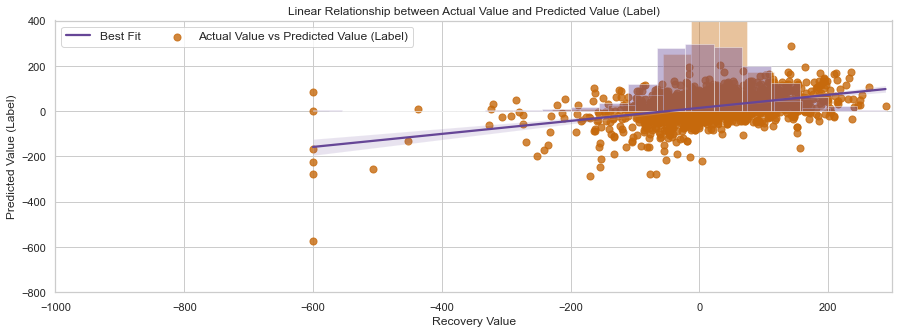

In [296]:
val_preds = modelCB.predict(test_X)
MAPE=np.mean(np.abs((test_y - val_preds) / test_y)) * 100
# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, test_y))
print("Accuracy is : ",  100-MAPE)

def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6)):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

train_preds = modelCB.predict(train_X)

residual_plot(train_y, train_preds, 
              test_y, val_preds, 
              title="CatBoost Residual Plot")

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_CATBOOST = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_CATBOOST["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_CATBOOST["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="Real", y="Prediction", data=output_data_CATBOOST, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Recovery Value")
plt.xlim([-1000, 300])
plt.ylim([-800,400])
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

output_data_CATBOOST.head(50)
output_data_CATBOOST["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Prediction"]]
output_data_CATBOOST["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Real"]]

output_data_CATBOOST.head(50)
comparison_column = np.where(output_data_CATBOOST["Prediction_sign"] == output_data_CATBOOST["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from catboost import cv
def cross_val(model):
    pred = cross_val_score(model, x, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square
#### Cat Boost
print('Test set evaluation:\n_____________________________________')
print_evaluate(test_y, val_preds)
print('Train set evaluation:\n_____________________________________')
print_evaluate(train_y, train_preds)


#### Light GBM 
results_bsic_Catboost = pd.DataFrame(data=[["Cat Boost", *evaluate(train_y, train_preds) ,cross_val(CatBoostRegressor())]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_bsic_Catboost




#feat_importances = modelCB.get_feature_importance(prettified=True)
#feat_importances
#plt.figure(figsize=(12, 10))
#sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:, :])
#plt.title('CatBoost features importance:')
#feat_importances.tail(100)
#feat_importances.loc[:, :]

In [297]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6524390243902439


$\textbf{We now add Uplift 2}$

* Λογαριασμός Προσαυξήσεων Ισχύος Εξισορρόπησης
* Χρησιμοποιείται για τον επιμερισμό του κόστους παροχής Ισχύος Εξισορρόπησης απο τους Παρόχους Υπηρεσιών Εξισορρόπησης
 $$Uplift = BALCAP_t \cdot \frac{MQ}{\sum MQ}$$

In [91]:
###### Add Uplift 2 to see if there is going to be any significant difference in the evaluation of our model
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()

,Uplift Account 1 (€/MWh),Uplift Account 2 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,2.738548,0.662670,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,2.375837,1.098814,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2.143069,1.201918,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2.043232,1.117085,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2.227400,1.156230,2055.0,4951.5,76.0,1079.0


In [92]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [93]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

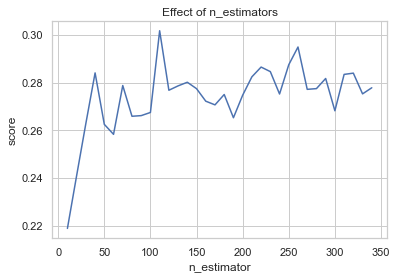

In [94]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [95]:
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  87.56460699353708
Random Forest Model STD:  541.6060295606619


In [96]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 84.03
R2: 0.28
Adjusted R2: 0.28


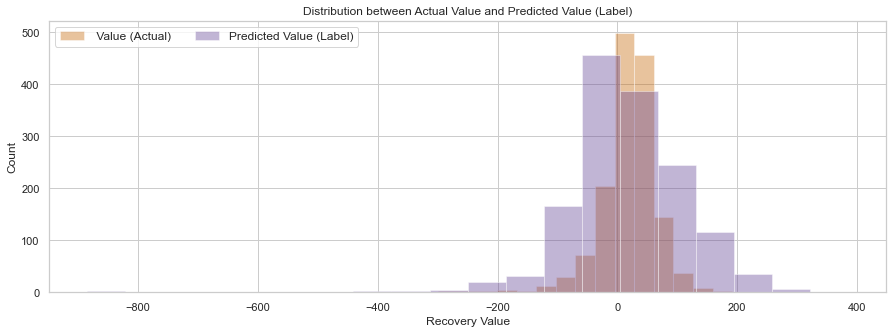

In [97]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest_with_uplift2 = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest_with_uplift2["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest_with_uplift2["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [98]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [99]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [100]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  983


In [102]:
print('Accuracy', count/len(comparison_column))

Accuracy 0.6659891598915989


$\textbf{Regression with a deep neural Network (DNN) Keras}$

In [180]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [181]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [182]:
dataset = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[7],columns_data[8],columns_data[9],columns_data[14],columns_data[16],columns_data[17]], axis=1)
dataset.head()



train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [183]:
train_dataset.head()
test_dataset.head()
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RES,4428.0,1945.449036,1035.571408,260.00,1053.750000,1870.000000,2675.000000,5195.00000
Load,4428.0,5925.086871,1167.601717,220.00,5055.125000,5929.750000,6766.250000,9258.50000
Mandatory Hydro,4428.0,320.378952,432.948268,0.00,19.000000,106.000000,442.000000,1798.00000
Total FRR,4428.0,1396.218232,366.367226,0.00,1244.000000,1512.500000,1636.000000,2029.00000
Day_ahead_Balancing_diff,4428.0,16.768615,105.706552,-1015.24,-37.168252,15.202925,77.344871,362.62531


In [184]:
train_dataset.head()

,RES,Load,Mandatory Hydro,Total FRR,Day_ahead_Balancing_diff
2021-09-18 12:00:00,3490.0,6849.0,26.0,1574.0,-29.703505
2022-01-13 22:00:00,2435.0,6663.5,615.5,1846.0,-32.743655
2022-04-07 18:00:00,2460.0,6082.5,468.0,1746.0,-69.701767
2021-11-16 15:00:00,2140.0,6360.0,84.5,1729.0,13.535551
2021-09-03 08:00:00,3155.0,6798.5,320.0,1714.0,92.220675


In [185]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Day_ahead_Balancing_diff')
test_labels = test_features.pop('Day_ahead_Balancing_diff')

In [186]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [187]:
normalizer.adapt(np.array(train_features))

In [188]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [189]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 20.1 s


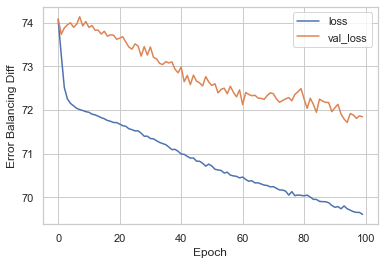

In [190]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')

  plt.xlabel('Epoch')
  plt.ylabel('Error Balancing Diff')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [191]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [192]:
test_results

{'dnn_model': 72.20266723632812}

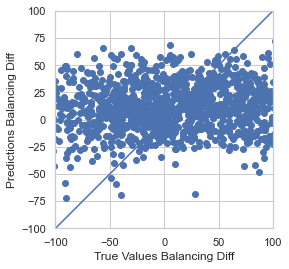

In [193]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Balancing Diff')
plt.ylabel('Predictions Balancing Diff')
lims = [-100, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

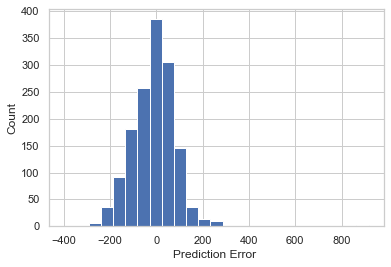

In [194]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error ')
_ = plt.ylabel('Count')

In [195]:
test_labels

2021-08-15 00:00:00     57.123433
2021-08-15 07:00:00     31.875812
2021-08-15 19:00:00     19.302691
2021-08-15 21:00:00     53.604033
2021-08-16 00:00:00     44.733231
                          ...    
2022-04-17 05:00:00    -11.875000
2022-04-17 07:00:00    105.435523
2022-04-17 08:00:00    -90.572857
2022-04-17 13:00:00   -173.203768
2022-04-17 21:00:00    -95.576083
Name: Day_ahead_Balancing_diff, Length: 1476, dtype: float64

In [196]:
test_predictions

array([ 17.798191  , -24.098473  , -10.896747  , ..., -35.622215  ,
        -3.7792625 ,  -0.48693445], dtype=float32)

Evaluation on test data
RMSE: 102.42
R2: 0.02
Adjusted R2: 0.02


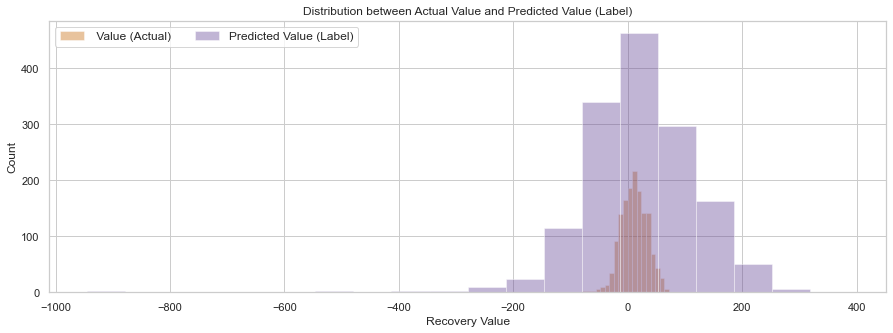

In [197]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_labels,test_predictions))
#R2 Score
r2_test = r2_score(test_labels,test_predictions)
# Adjusted R2 Score
n= train_features.shape[0] # total no of datapoints
p= train_features.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_keras = pd.DataFrame({
                      'Prediction': test_predictions,'Real': test_labels})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_keras["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_keras["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [198]:
output_keras.head(50)
output_keras["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_keras["Prediction"]]
output_keras["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_keras["Real"]]

comparison_column = np.where(output_keras["Prediction_sign"] == output_keras["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

We have a total of True values :  853
Accuracy of True values compared to the total observations : 0.5779132791327913
